# Ross Sea synthetic gravity inversion

Here we try to recover the true bathymetry of the Ross Sea from a synthetic airborne gravity survey. See notebook `Ross_Sea_synthetic_model.ipynb` for the creation of this synthetic gravity data and the low-resolution starting model of bathymetry. 

import packages

In [4]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import pathlib
import pickle
import verde as vd
import xarray as xr
import pandas as pd
import numpy as np
from polartoolkit import maps, fetch, regions, profiles
from polartoolkit import utils as polar_utils
import string
import os
import RIS_gravity_inversion.synthetic as RIS_synth
import RIS_gravity_inversion.plotting as RIS_plotting
import pygmt
import scipy as sp

os.environ['POLARTOOLKIT_HEMISPHERE']='south'

logging.getLogger().setLevel(logging.INFO)

from invert4geom import inversion, plotting, synthetic, uncertainty, utils, regional, cross_validation, optimization

# Get synthetic model data

INFO:root:using preprocessed 5km grid since spacing is > 5km


INFO:root:returning grid with new region and/or registration, same spacing


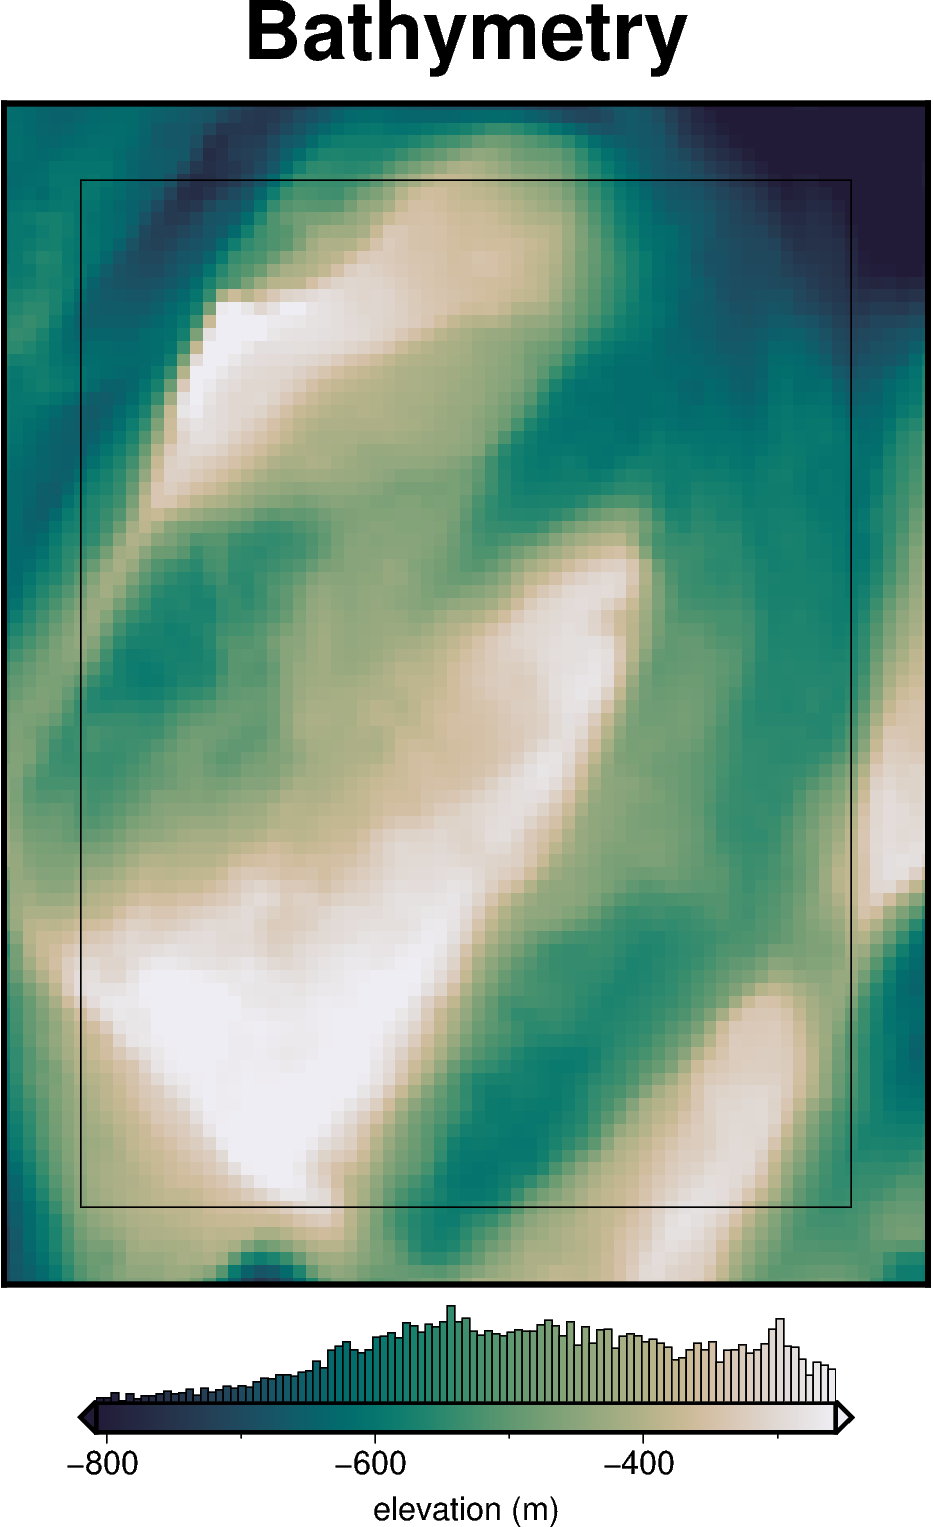

  0%|          | 0/4941 [00:00<?, ?it/s]

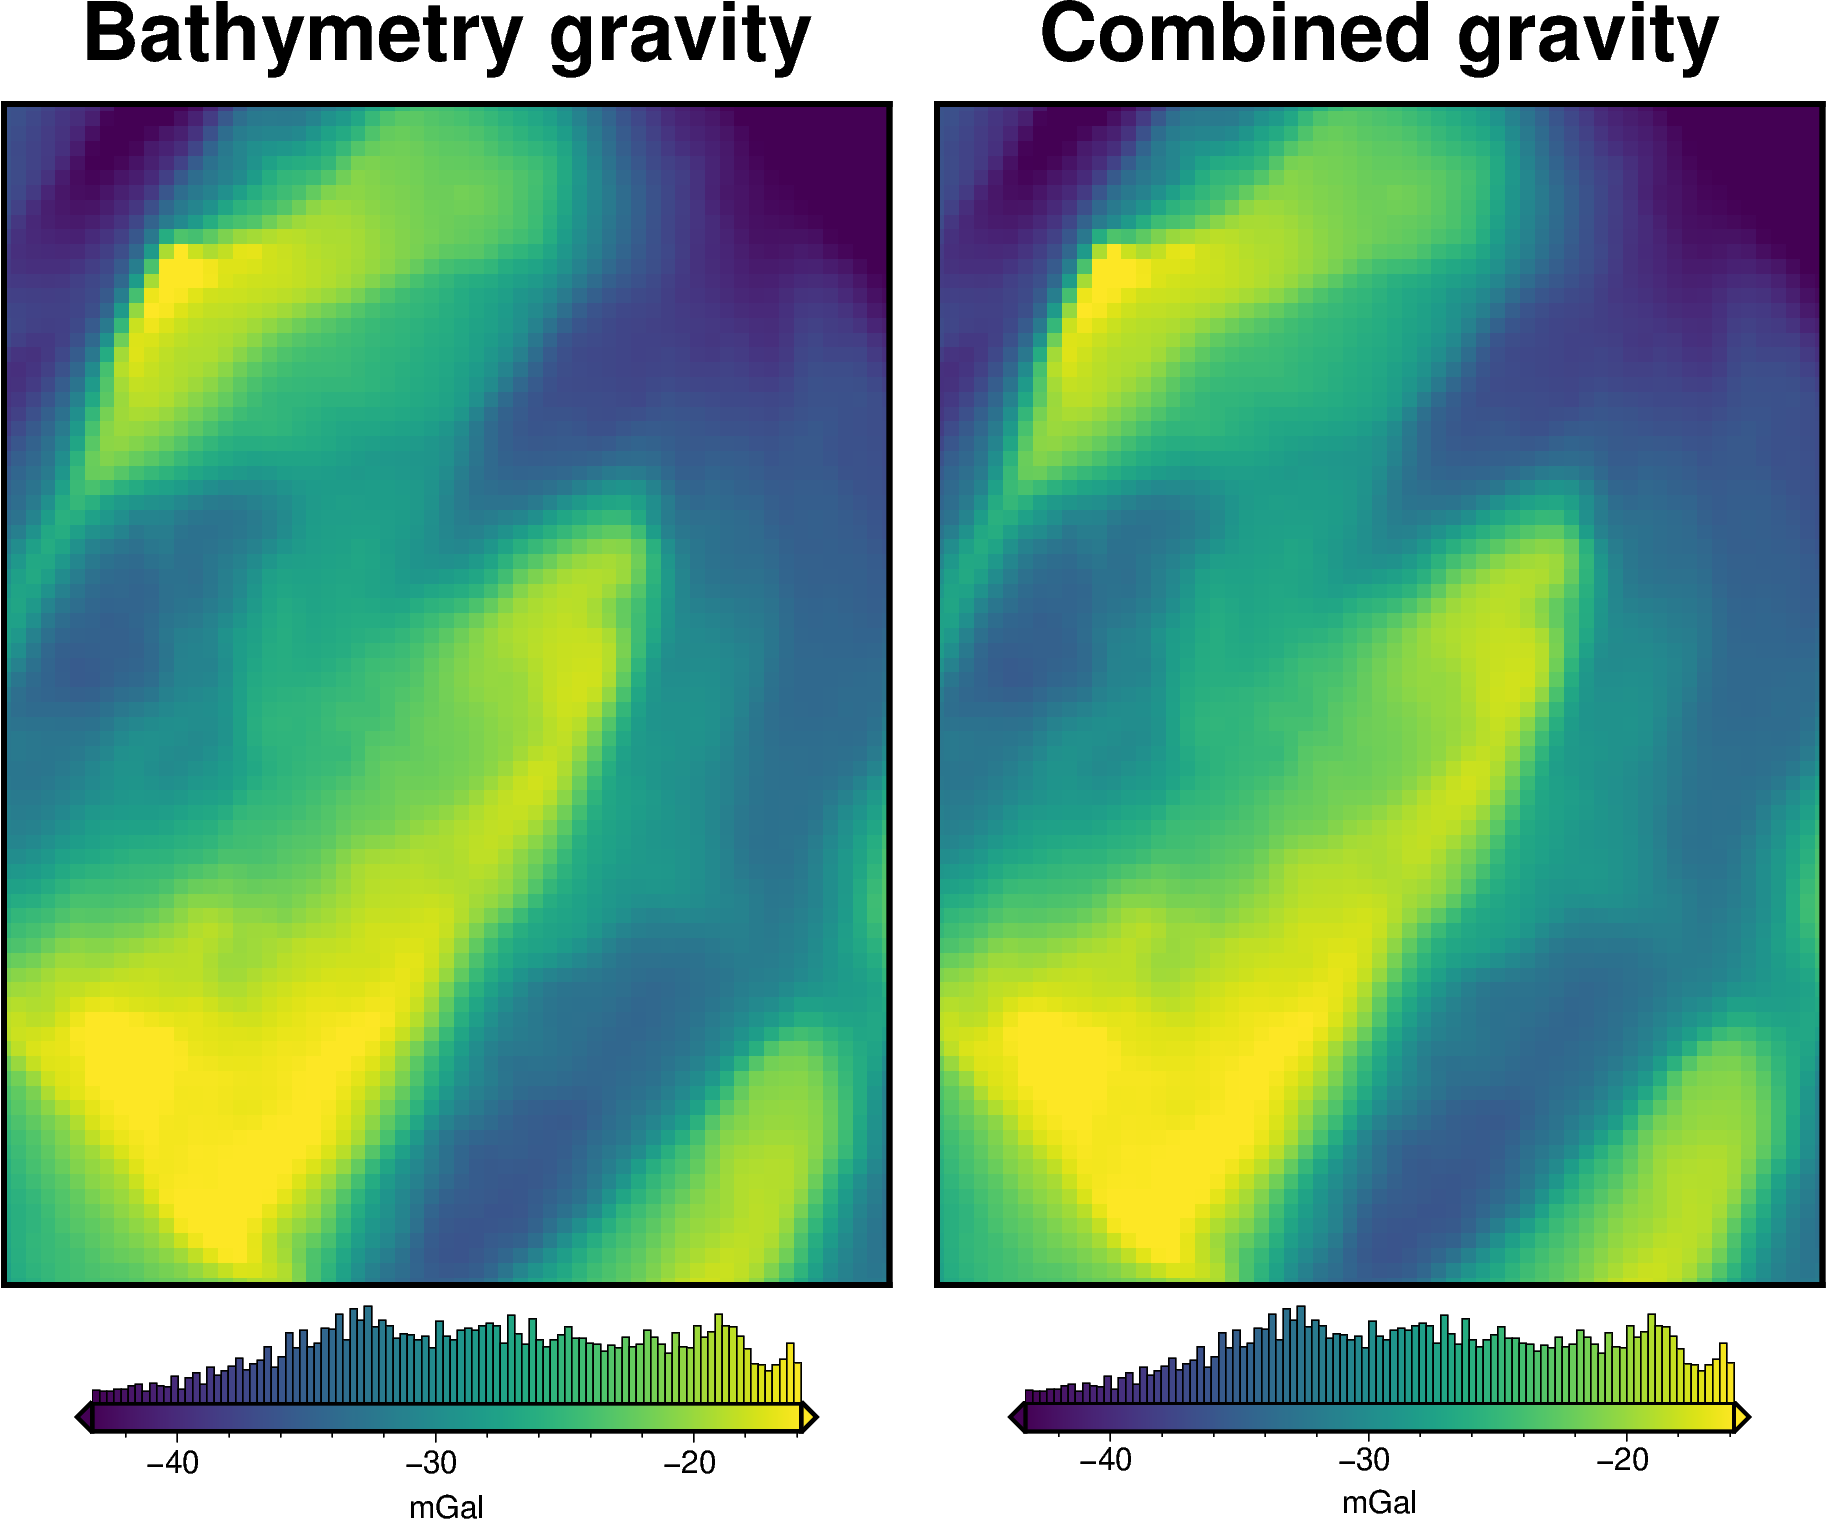

In [5]:
# set grid parameters
spacing = 5e3
inversion_region = (-40e3, 260e3, -1800e3, -1400e3)

true_density_contrast = 1476

bathymetry, basement, grav_df = RIS_synth.load_synthetic_model(
    spacing=spacing,
    buffer=spacing*6,
    # gravity_noise=0,
    zref=0,
    bathymetry_density_contrast=true_density_contrast,
)
buffer_region = polar_utils.get_grid_info(bathymetry)[1]

In [6]:
grav_df.head()

,northing,easting,upward,bathymetry_grav,basement_grav,disturbance,gravity_anomaly
0,-1800000.0,-40000.0,1000.0,-28.046289,0,-28.046289,-28.046289
1,-1800000.0,-35000.0,1000.0,-26.714502,0,-26.714502,-26.714502
2,-1800000.0,-30000.0,1000.0,-25.919276,0,-25.919276,-25.919276
3,-1800000.0,-25000.0,1000.0,-25.236960,0,-25.236960,-25.236960
4,-1800000.0,-20000.0,1000.0,-24.610928,0,-24.610928,-24.610928


# Make starting bathymetry model

In [7]:
# semi-regularly spaced
constraint_points = RIS_synth.constraint_layout_number(
    shape=(4,5),
    region=inversion_region,
    padding=-spacing,
)

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points,
    bathymetry,
    "true_upward",
    coord_names=("easting", "northing"),
)
constraint_points["upward"] = constraint_points.true_upward
constraint_points.head()

,northing,easting,true_upward,upward
0,-1756000.0,1250.0,-277.117397,-277.117397
1,-1756000.0,73750.0,-292.754172,-292.754172
2,-1756000.0,146250.0,-587.490438,-587.490438
3,-1756000.0,218750.0,-303.910608,-303.910608
4,-1678000.0,1250.0,-356.930926,-356.930926


In [10]:
# # re-sample depths with uncertainty to emulate measurement errors
# # set each points uncertainty equal to 2% of depth
# uncert = np.abs(0.02 * constraint_points.upward)
# constraint_points.loc[constraint_points.index, "uncert"] = uncert

# constraint_points = uncertainty.randomly_sample_data(
#     seed=0,
#     data_df=constraint_points,
#     data_col="upward",
#     uncert_col="uncert",
# )

# # create weights column
# constraint_points["weight"] = 1 / (constraint_points.uncert**2)

# constraint_points.head()

In [11]:
# grid the sampled values using verde
starting_topography_kwargs=dict(
    method="splines",
    region=buffer_region,
    spacing=spacing,
    constraints_df=constraint_points,
    dampings=None,
)
starting_bathymetry = utils.create_topography(**starting_topography_kwargs)

starting_bathymetry

<xarray.DataArray 'scalars' (northing: 93, easting: 73)> Size: 54kB
array([[-306.27646204, -301.11328455, -296.14330811, ..., -136.72275749,
        -133.56247234, -130.90278552],
       [-309.23858022, -303.98041825, -298.91207899, ..., -141.4887454 ,
        -138.50192797, -136.02065391],
       [-312.27191015, -306.91508978, -301.74433524, ..., -146.43003056,
        -143.64038179, -141.35749105],
       ...,
       [-928.66251693, -917.88043654, -906.84555987, ..., -854.58896833,
        -862.85099753, -870.81154897],
       [-938.2697604 , -927.29383174, -916.05662461, ..., -859.61863513,
        -868.01943284, -876.12134531],
       [-947.80748693, -936.6526941 , -925.23245144, ..., -864.83953674,
        -873.35985613, -881.58608866]])
Coordinates:
  * easting   (easting) float64 584B -7e+04 -6.5e+04 -6e+04 ... 2.85e+05 2.9e+05
  * northing  (northing) float64 744B -1.83e+06 -1.825e+06 ... -1.37e+06
Attributes:
    metadata:  Generated by SplineCV(cv=KFold(n_splits=5, random_state=0, shu...
    damping:   None

In [12]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    starting_bathymetry,
    "starting_bathymetry",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.starting_bathymetry)
print(f"RMSE: {rmse:.2f} m")

RMSE: 0.19 m


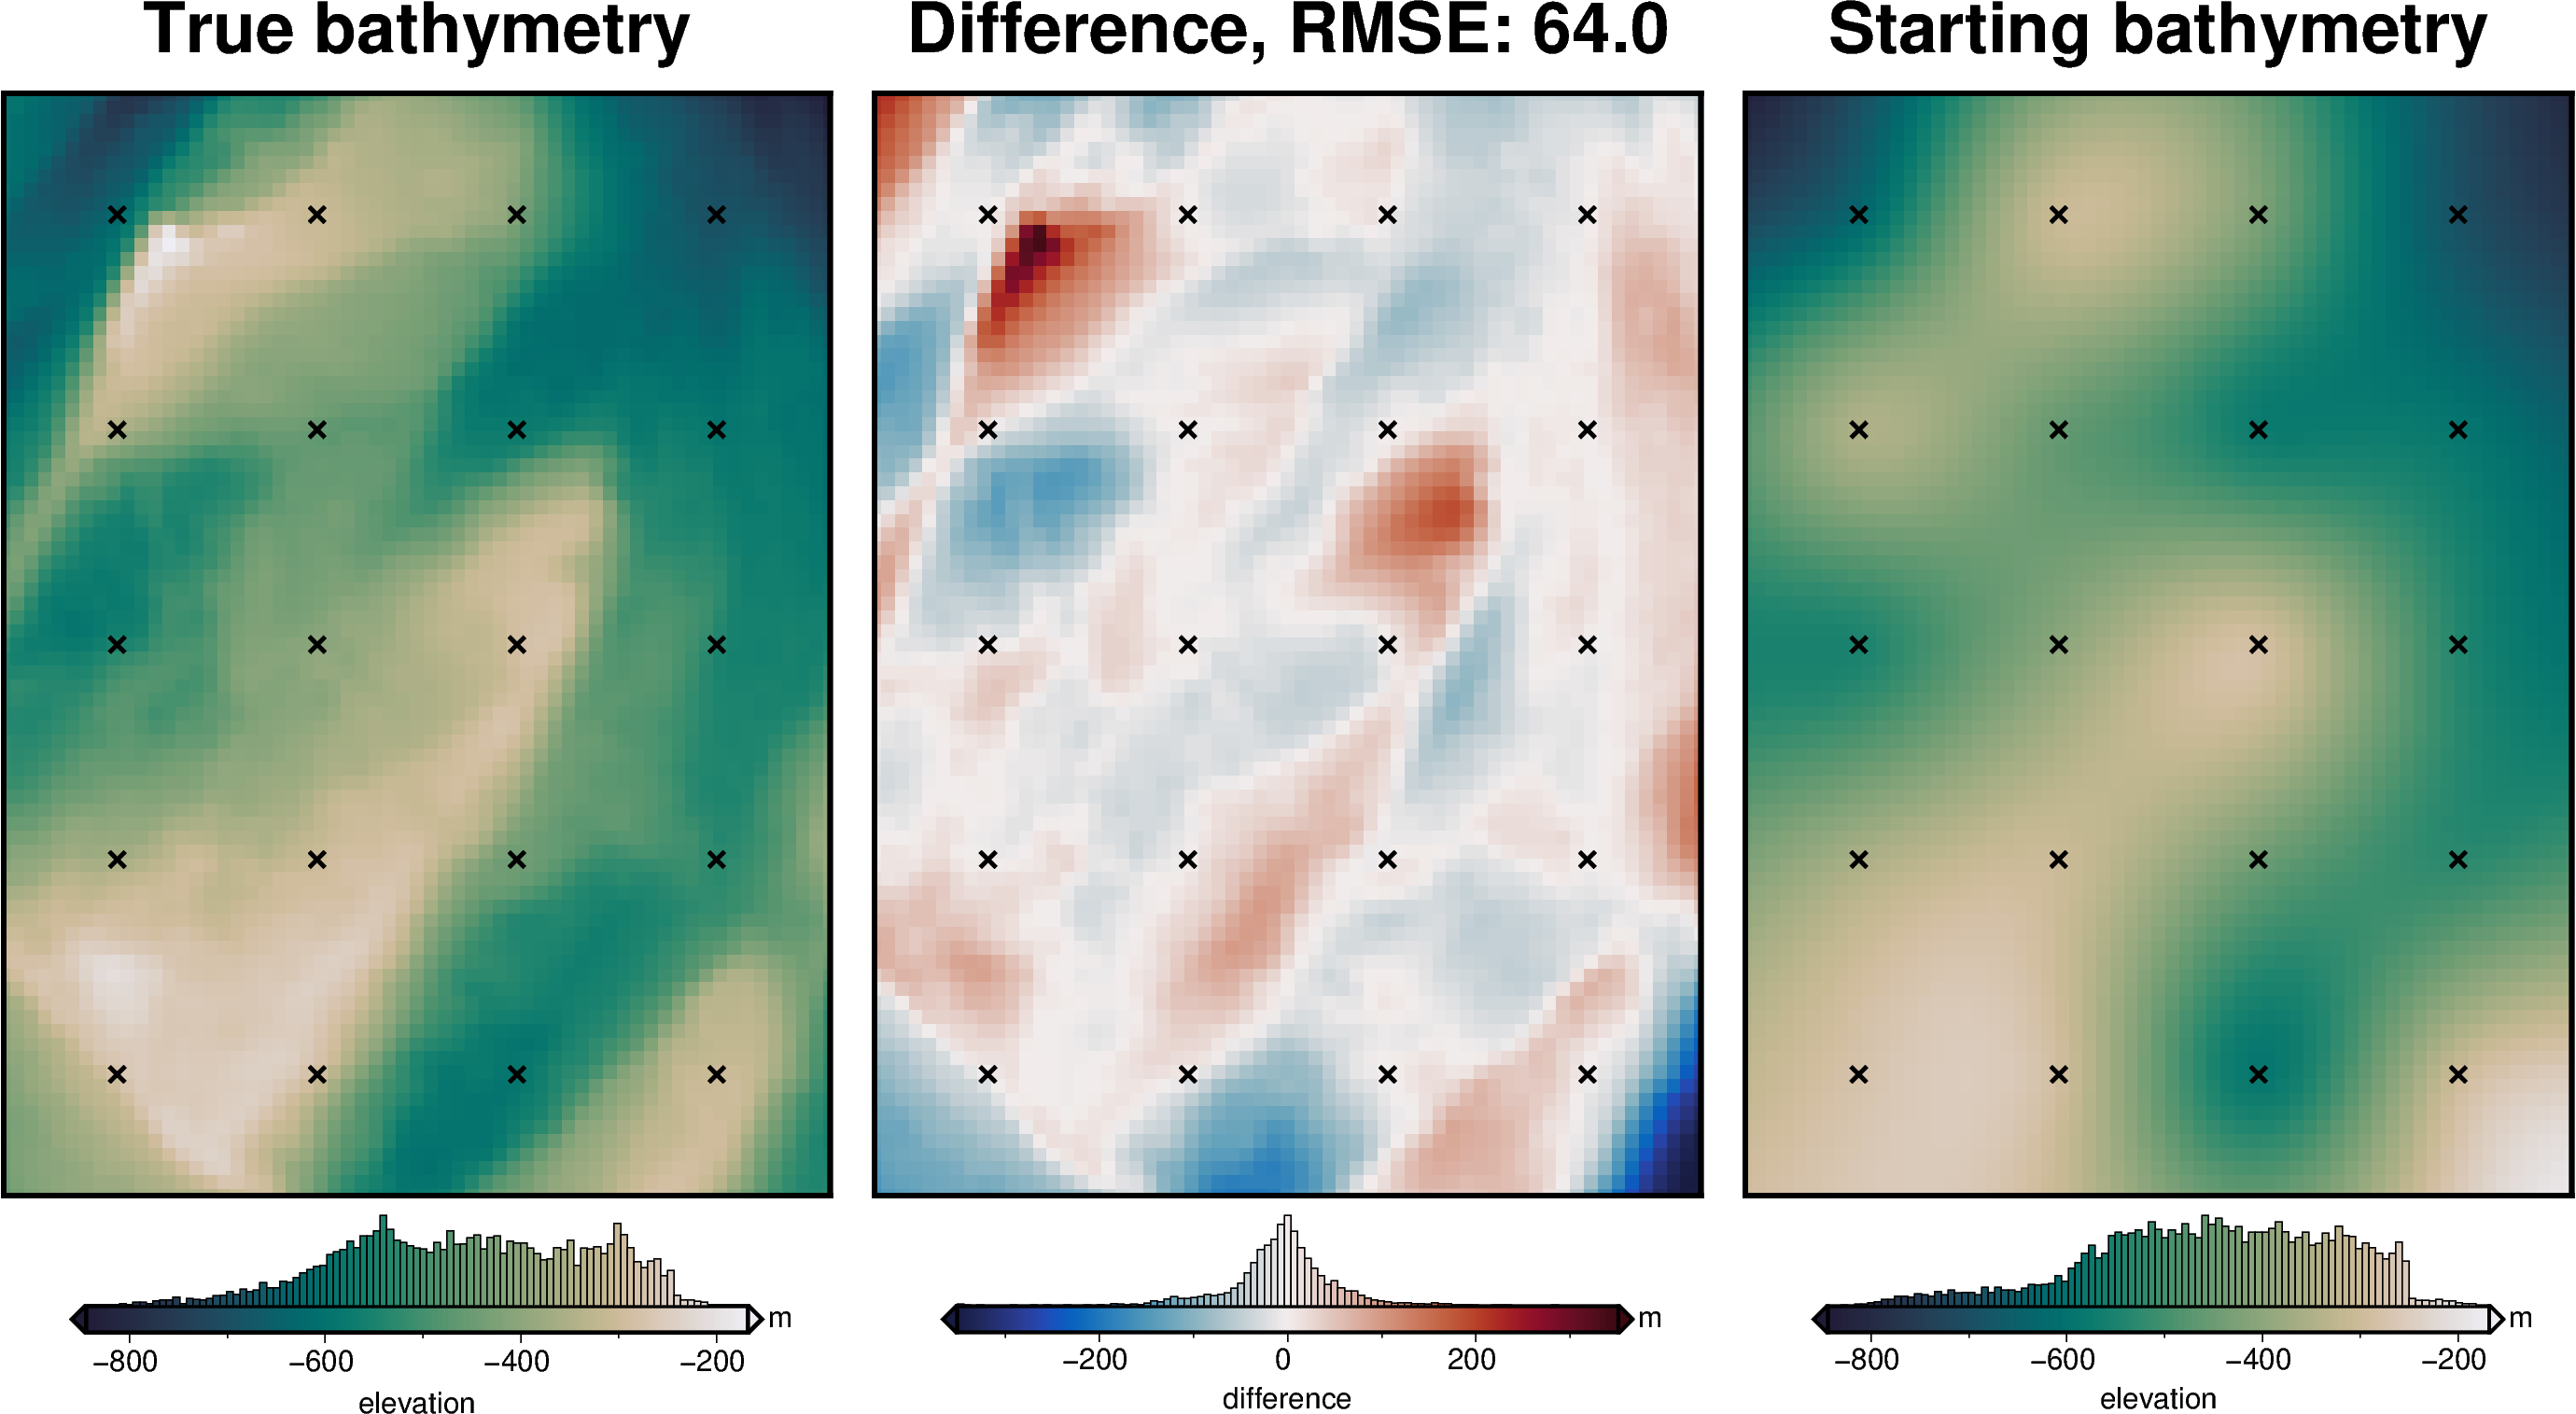

In [81]:
# compare starting and actual bathymetry grids
grids = polar_utils.grd_compare(
    bathymetry,
    starting_bathymetry,
    fig_height=10,
    plot=True,
    plot_type="pygmt",
    cmap="rain",
    reverse_cpt=True,
    diff_cmap="balance+h0",
    grid1_name="True bathymetry",
    grid2_name="Starting bathymetry",
    title="Difference",
    title_font="18p,Helvetica-Bold,black",
    cbar_unit="m",
    cbar_label="elevation",
    RMSE_decimals=0,
    region=inversion_region,
    inset=False,
    hist=True,
    cbar_yoffset=1,
    label_font="16p,Helvetica,black",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
)

In [13]:
# the true density contrast is 1476 kg/m3
density_contrast = 1350

# set the reference level from the prisms to 0
zref = 0

density_grid = xr.where(
    starting_bathymetry >=  zref,
    density_contrast,
    -density_contrast,
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_bathymetry,
    zref,
    density=density_grid,
)

grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,upward,bathymetry_grav,basement_grav,disturbance,gravity_anomaly,starting_gravity
0,-1800000.0,-40000.0,1000.0,-28.046289,0,-28.046289,-28.046289,-16.300420
1,-1800000.0,-35000.0,1000.0,-26.714502,0,-26.714502,-26.714502,-16.069866
2,-1800000.0,-30000.0,1000.0,-25.919276,0,-25.919276,-25.919276,-15.845227
3,-1800000.0,-25000.0,1000.0,-25.236960,0,-25.236960,-25.236960,-15.629333
4,-1800000.0,-20000.0,1000.0,-24.610928,0,-24.610928,-24.610928,-15.424289
...,...,...,...,...,...,...,...,...
4936,-1400000.0,240000.0,1000.0,-48.323584,0,-48.323584,-48.323584,-42.088044
4937,-1400000.0,245000.0,1000.0,-48.356131,0,-48.356131,-48.356131,-42.673106
4938,-1400000.0,250000.0,1000.0,-49.079005,0,-49.079005,-49.079005,-43.214539
4939,-1400000.0,255000.0,1000.0,-49.877171,0,-49.877171,-49.877171,-43.711150


In [14]:
regional_grav_kwargs = dict(
    grav_df=grav_df,
    method="constant",
    constant=0,
)
grav_df = regional.regional_separation(**regional_grav_kwargs)

grav_df

,northing,easting,upward,bathymetry_grav,basement_grav,disturbance,gravity_anomaly,starting_gravity,misfit,reg,res
0,-1800000.0,-40000.0,1000.0,-28.046289,0,-28.046289,-28.046289,-16.300420,-11.745870,0,-11.745870
1,-1800000.0,-35000.0,1000.0,-26.714502,0,-26.714502,-26.714502,-16.069866,-10.644636,0,-10.644636
2,-1800000.0,-30000.0,1000.0,-25.919276,0,-25.919276,-25.919276,-15.845227,-10.074049,0,-10.074049
3,-1800000.0,-25000.0,1000.0,-25.236960,0,-25.236960,-25.236960,-15.629333,-9.607628,0,-9.607628
4,-1800000.0,-20000.0,1000.0,-24.610928,0,-24.610928,-24.610928,-15.424289,-9.186639,0,-9.186639
...,...,...,...,...,...,...,...,...,...,...,...
4936,-1400000.0,240000.0,1000.0,-48.323584,0,-48.323584,-48.323584,-42.088044,-6.235540,0,-6.235540
4937,-1400000.0,245000.0,1000.0,-48.356131,0,-48.356131,-48.356131,-42.673106,-5.683026,0,-5.683026
4938,-1400000.0,250000.0,1000.0,-49.079005,0,-49.079005,-49.079005,-43.214539,-5.864466,0,-5.864466
4939,-1400000.0,255000.0,1000.0,-49.877171,0,-49.877171,-49.877171,-43.711150,-6.166022,0,-6.166022


makecpt [ERROR]: Option T: min >= max


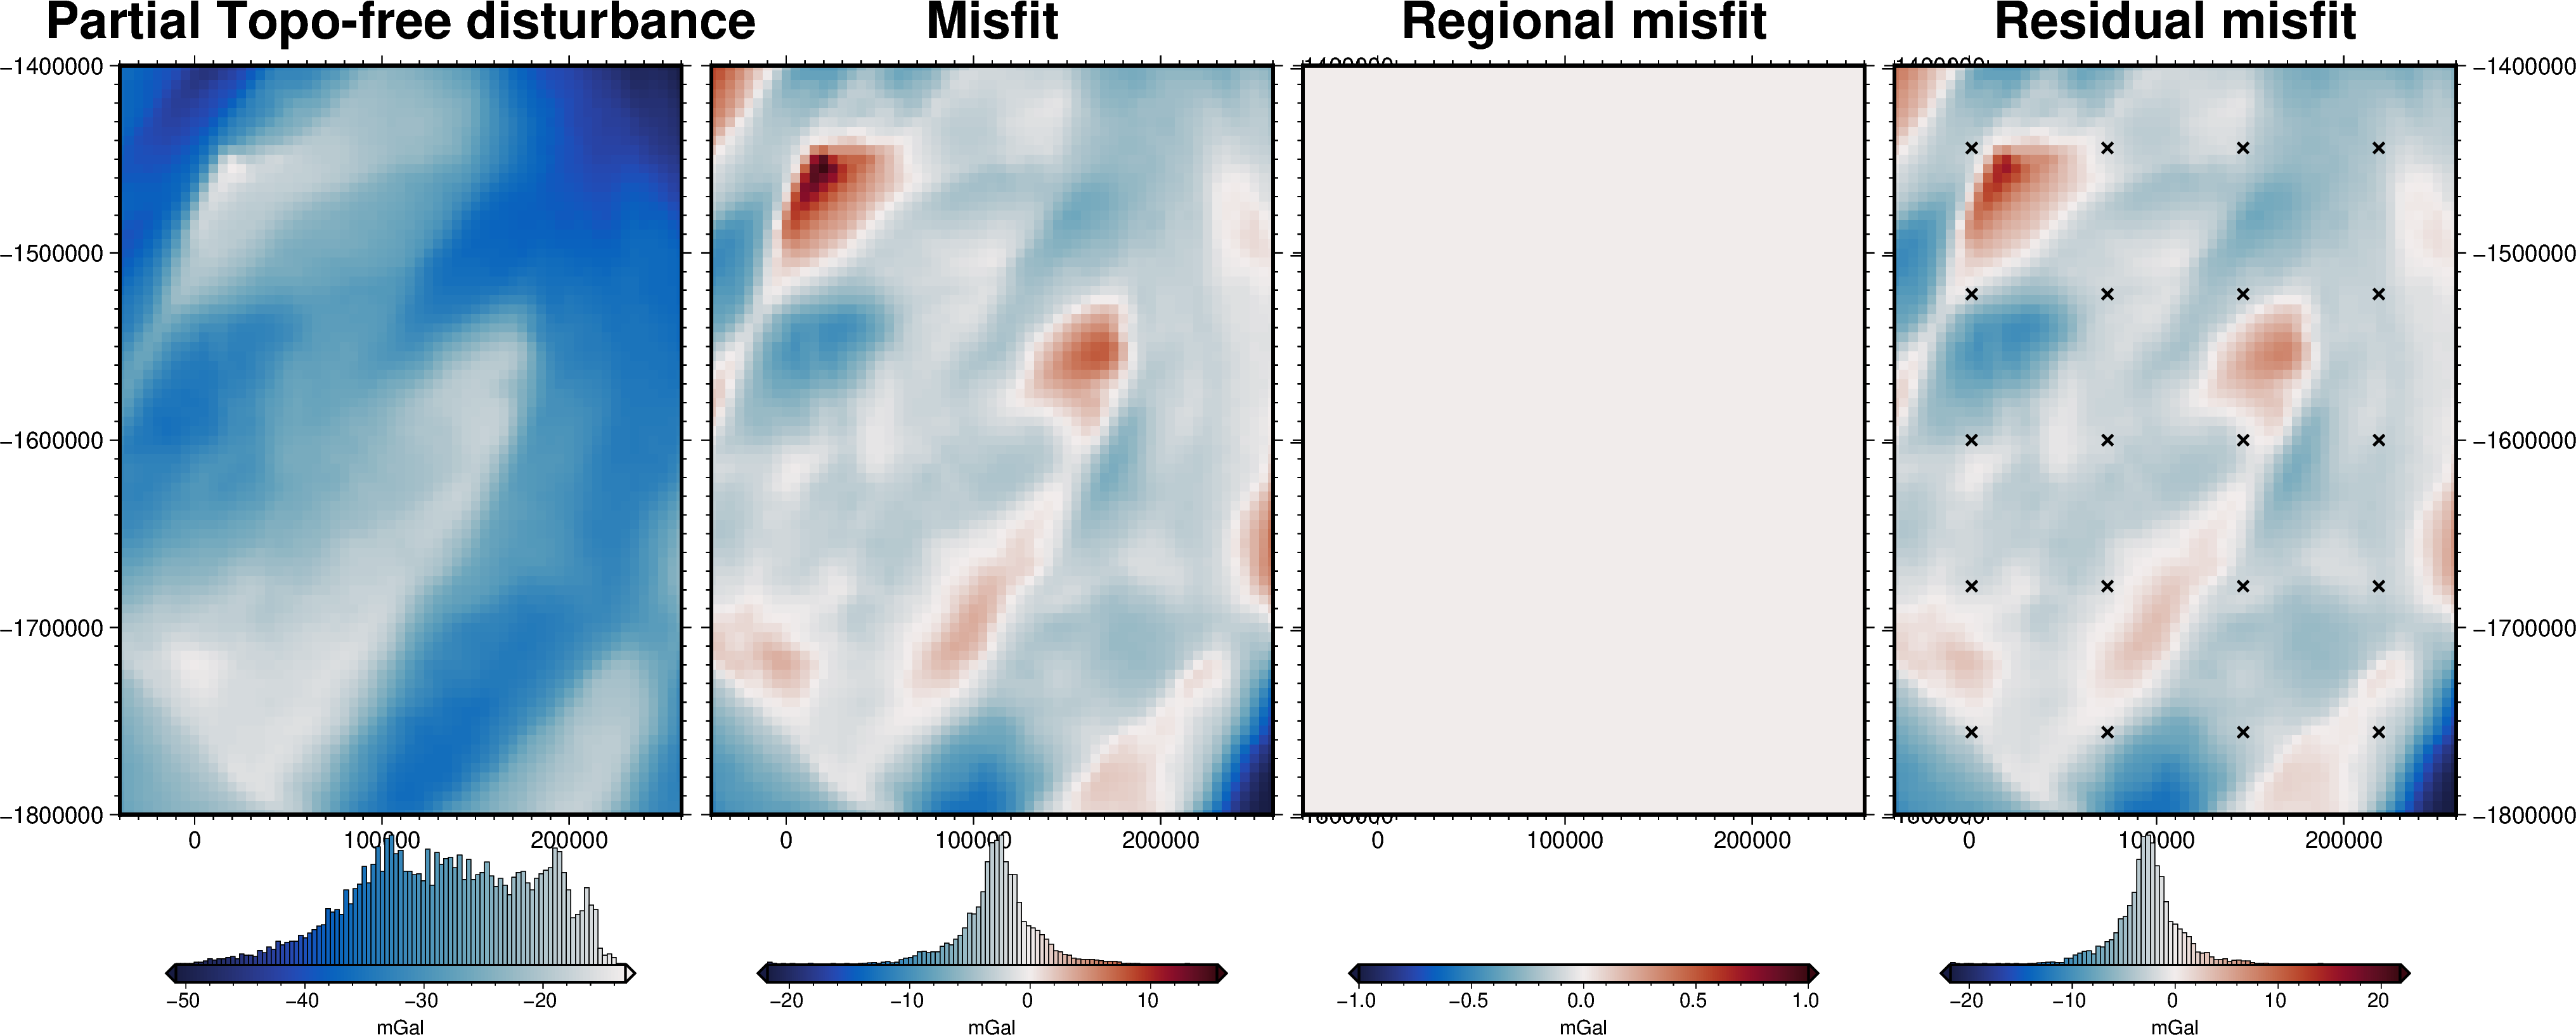

In [84]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    region=inversion_region,
    fig_height=10,
    title="Partial Topo-free disturbance",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.misfit,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Regional misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.res,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=[-vd.maxabs(grav_grid.res), vd.maxabs(grav_grid.res)],
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
)
fig.show()

In [15]:
# set kwargs to pass to the inversion
kwargs = {
    # set stopping criteria
    "max_iterations": 200,
    "l2_norm_tolerance": .2**.5, # square root of the gravity noise
    "delta_l2_norm_tolerance": 1.008,
}


# Damping Cross Validation

INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_02_damping_cv'
INFO:invert4geom:running damping cross validation


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 2
INFO:invert4geom:	parameter: {'damping': 0.024577958705414526}
INFO:invert4geom:	scores: [0.07517995195968112]
INFO:invert4geom:results saved to ../../results/Ross_Sea_02_damping_cv_results.pickle.pickle


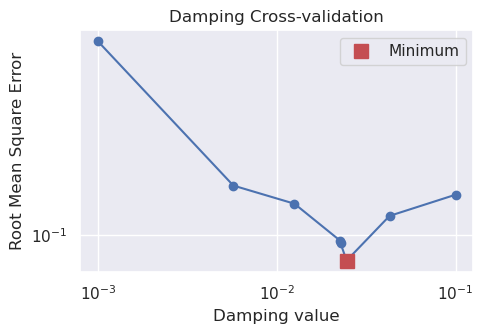

In [35]:
logging.getLogger().setLevel(logging.INFO)

# run the inversion workflow, including a cross validation for the damping parameter
results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    starting_prisms=starting_prisms,
    # for creating test/train splits
    grav_spacing=spacing,
    inversion_region=inversion_region,
    run_damping_cv=True,
    damping_limits=(0.001, 0.1),
    damping_cv_trials=8,
    plot_cv=True,
    fname="../../results/Ross_Sea_02_damping_cv",
    **kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [16]:
# load saved inversion results
with pathlib.Path("../../results/Ross_Sea_02_damping_cv_results.pickle").open("rb") as f:
    results = pickle.load(f)

# load study
with pathlib.Path("../../results/Ross_Sea_02_damping_cv_damping_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [17]:
best_damping = parameters.get("Solver damping")
best_damping

0.024577958705414526

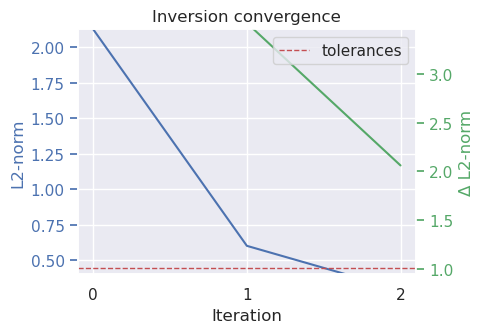

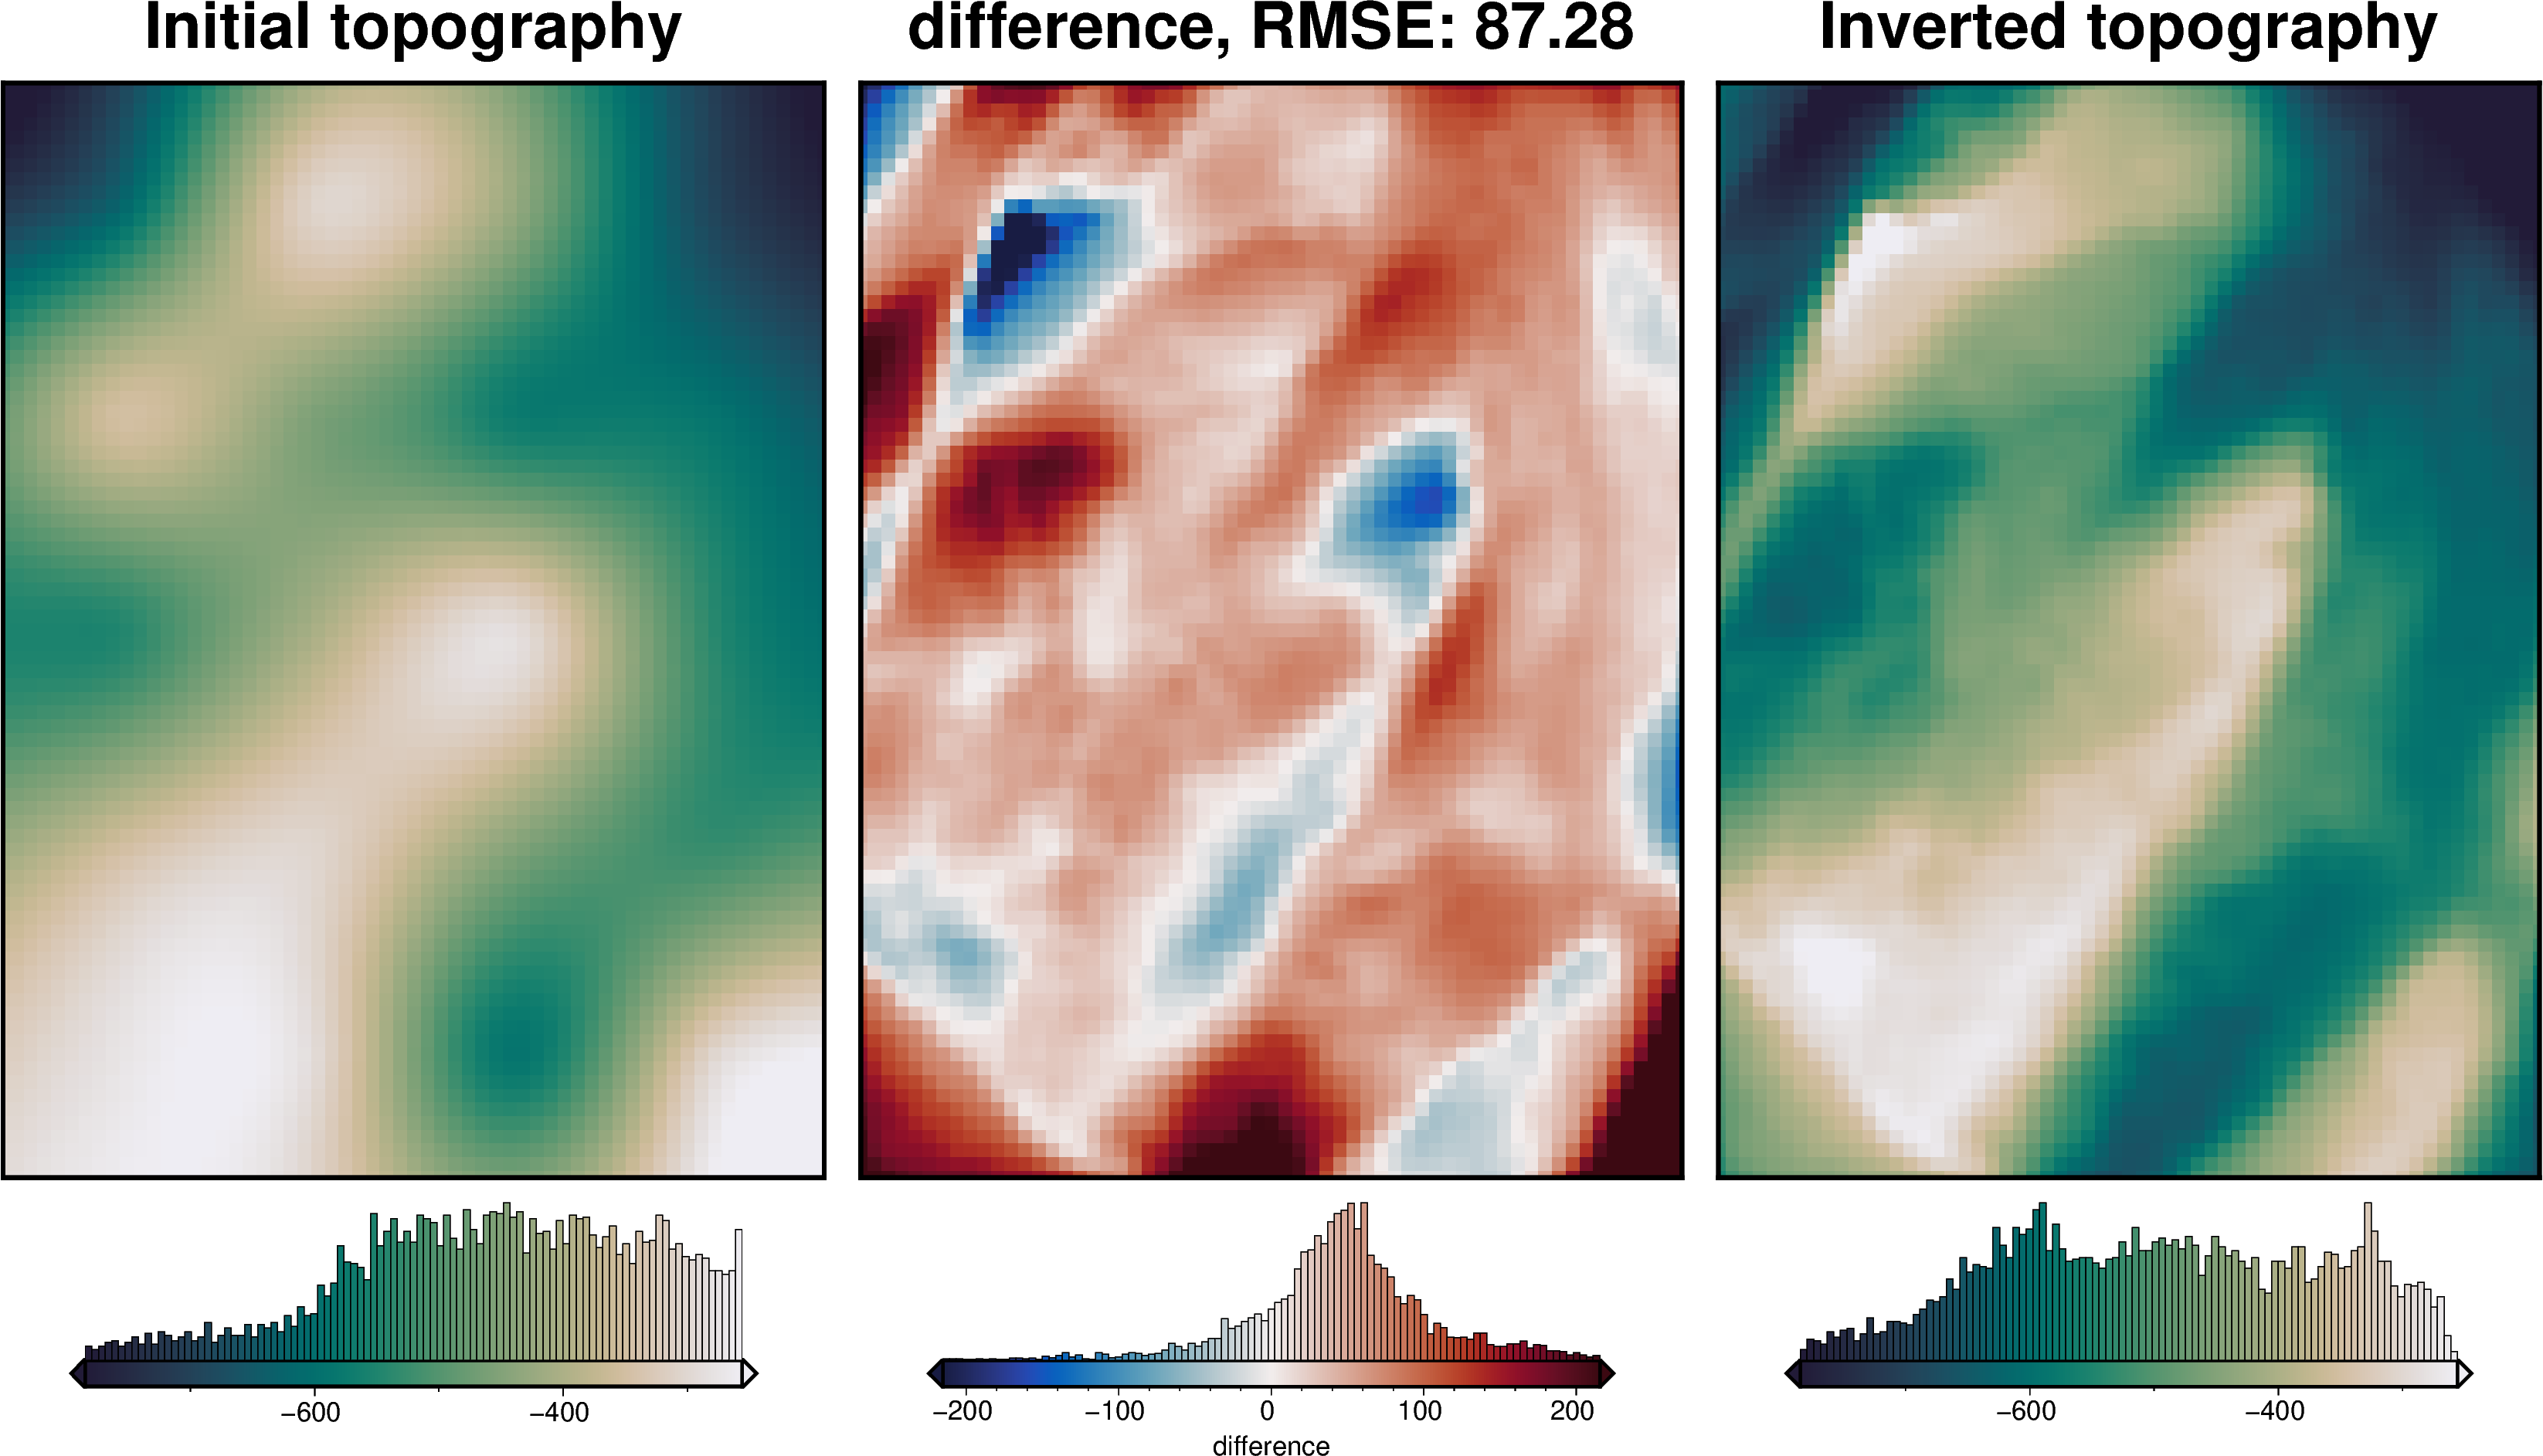

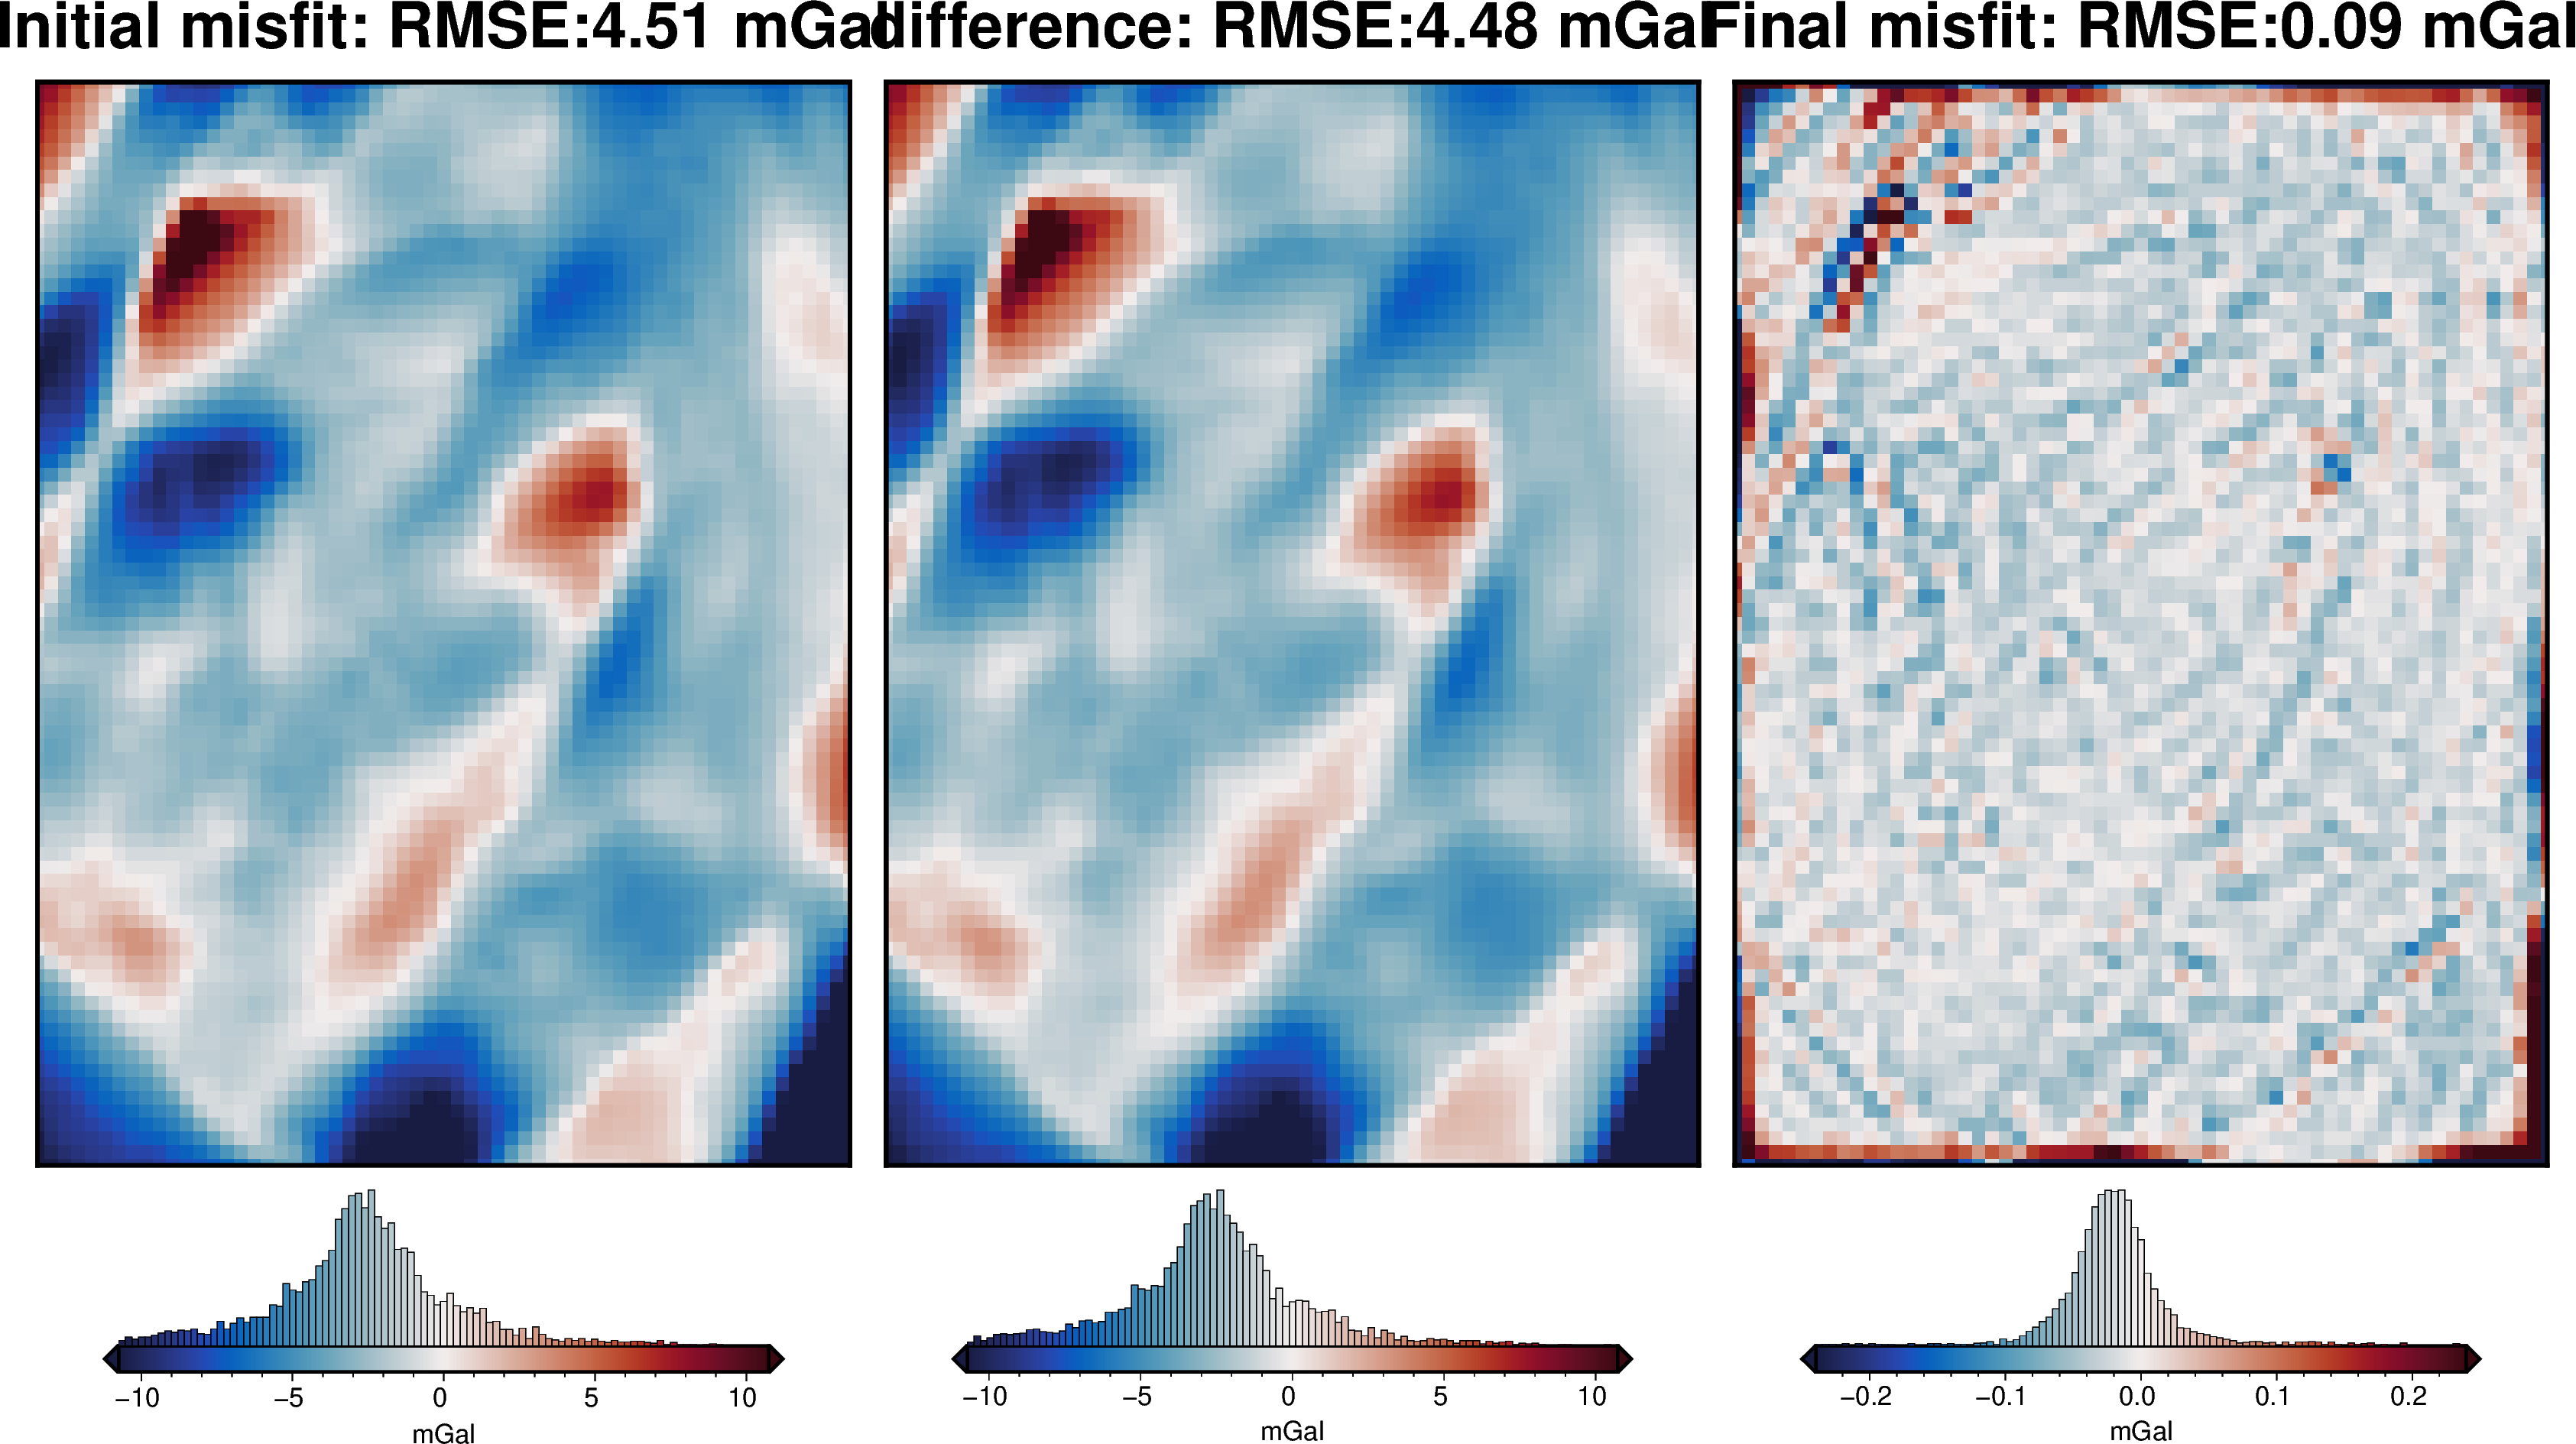

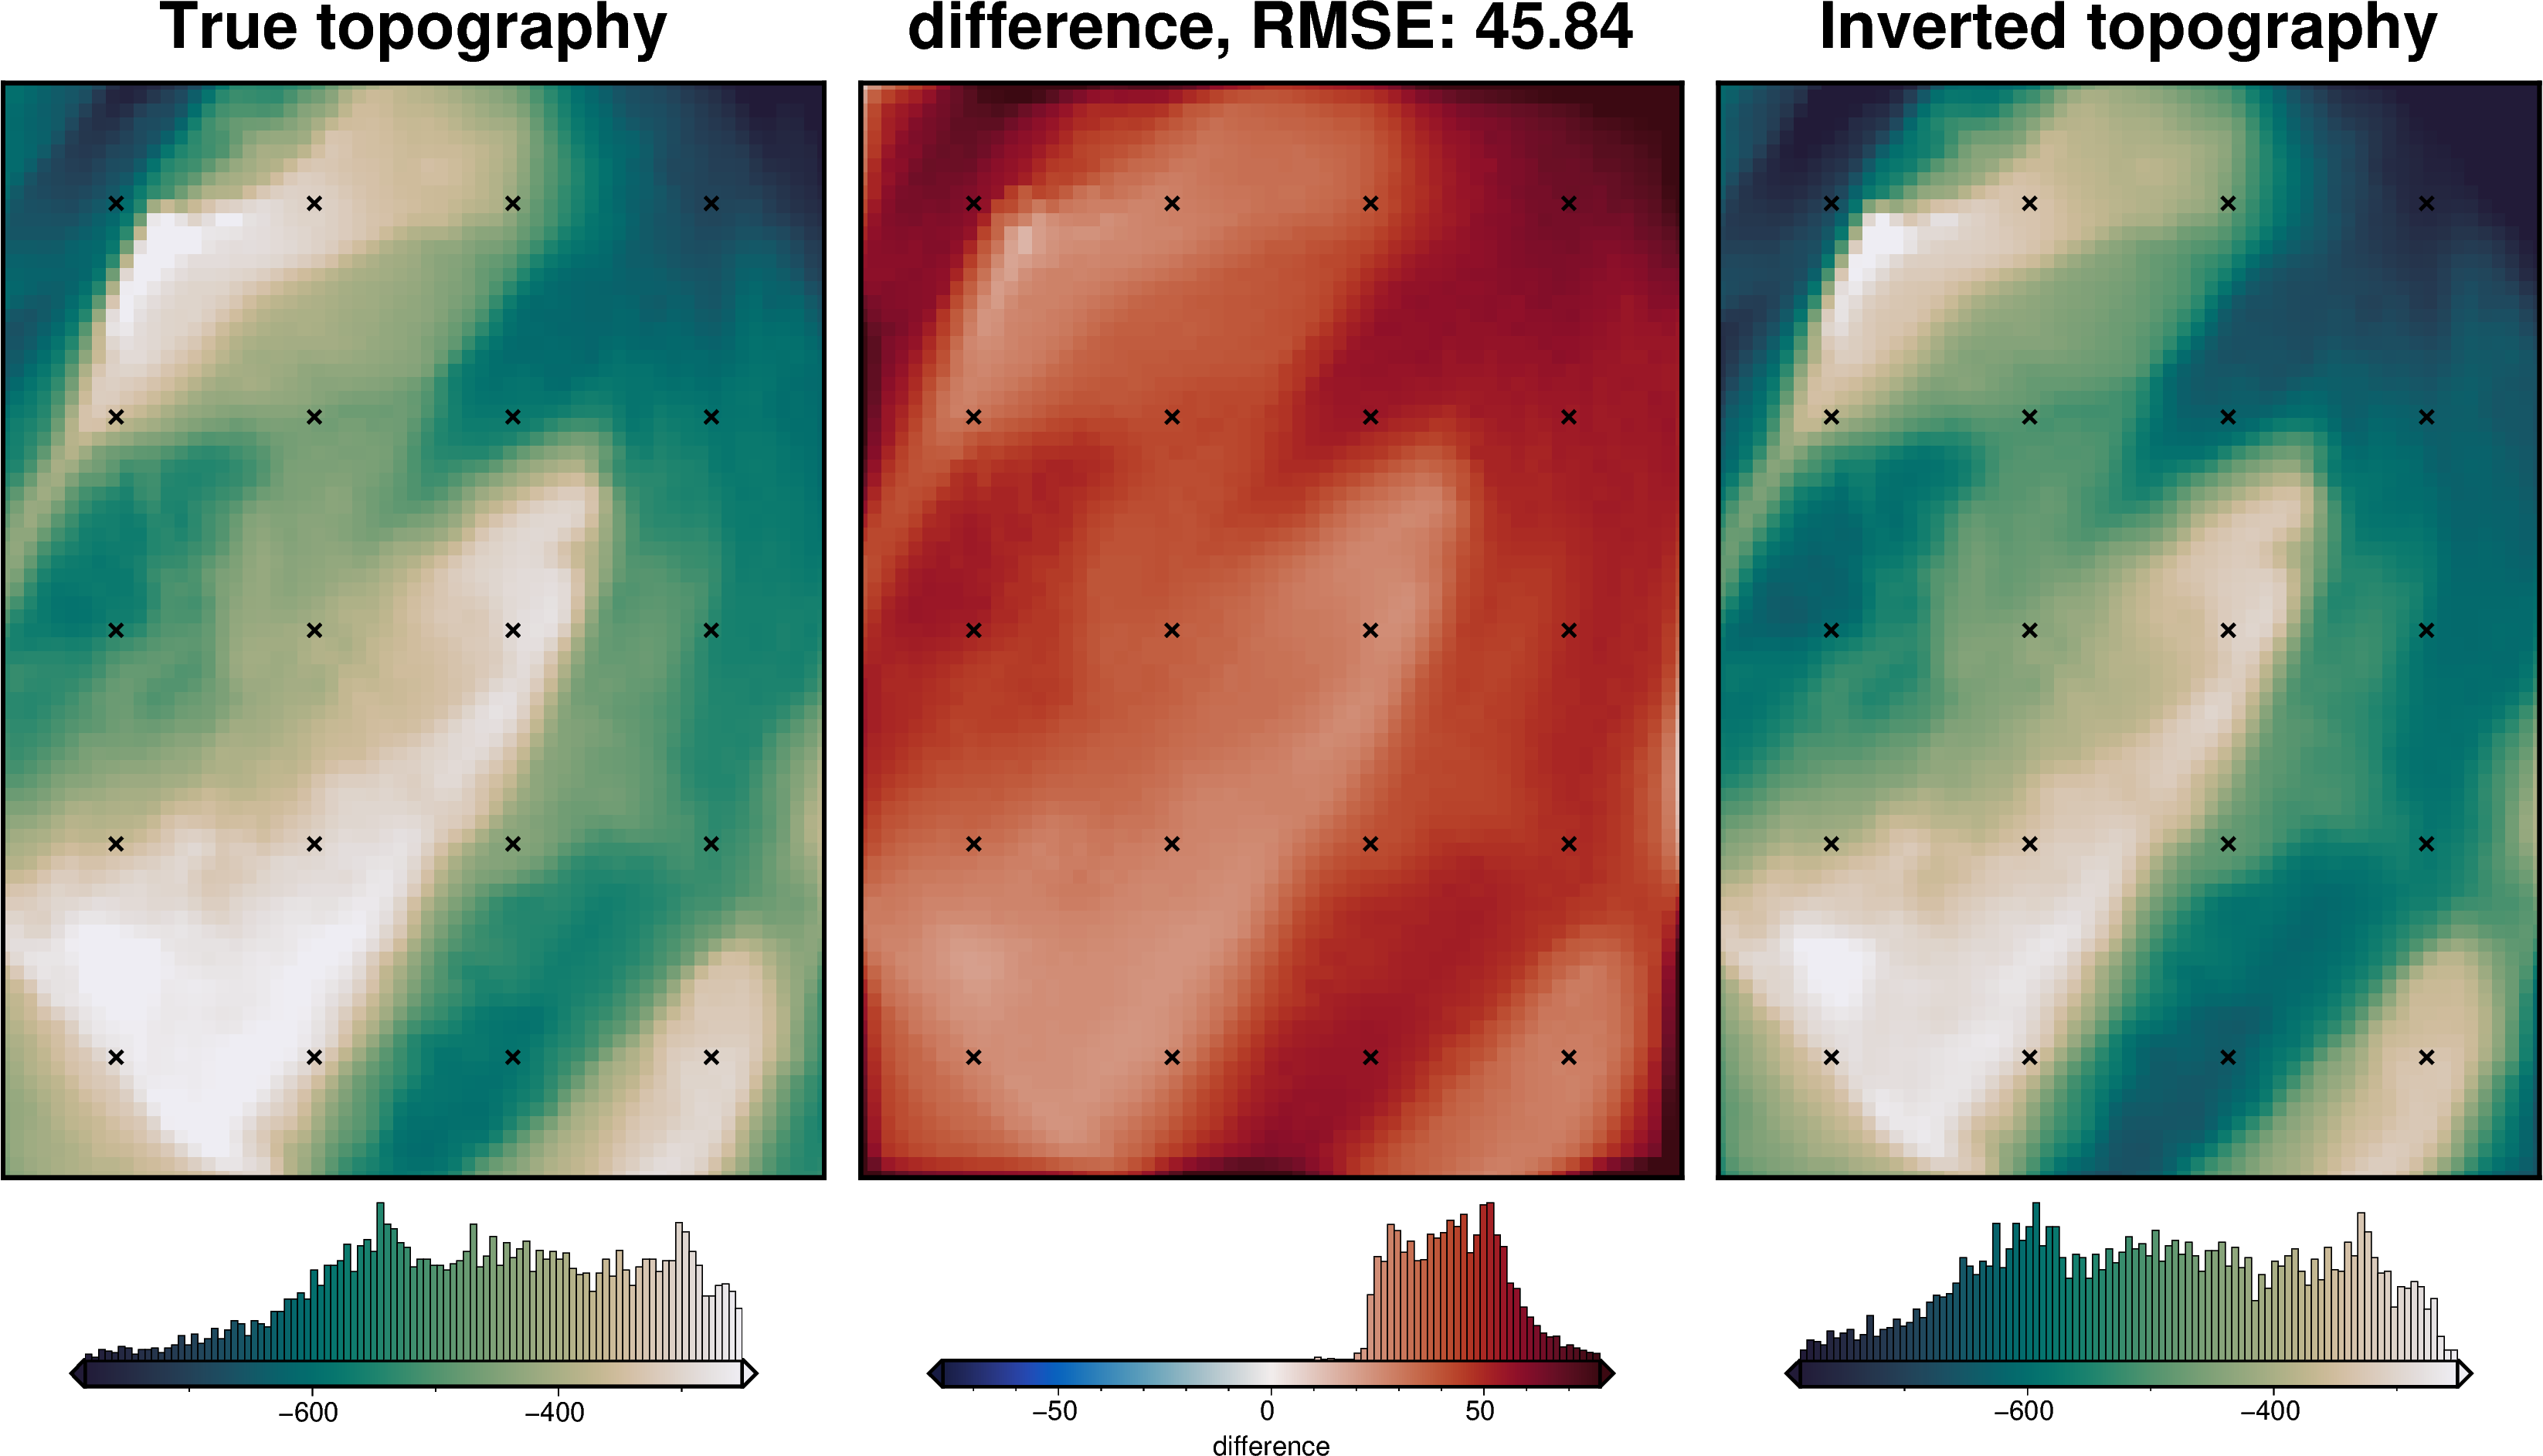

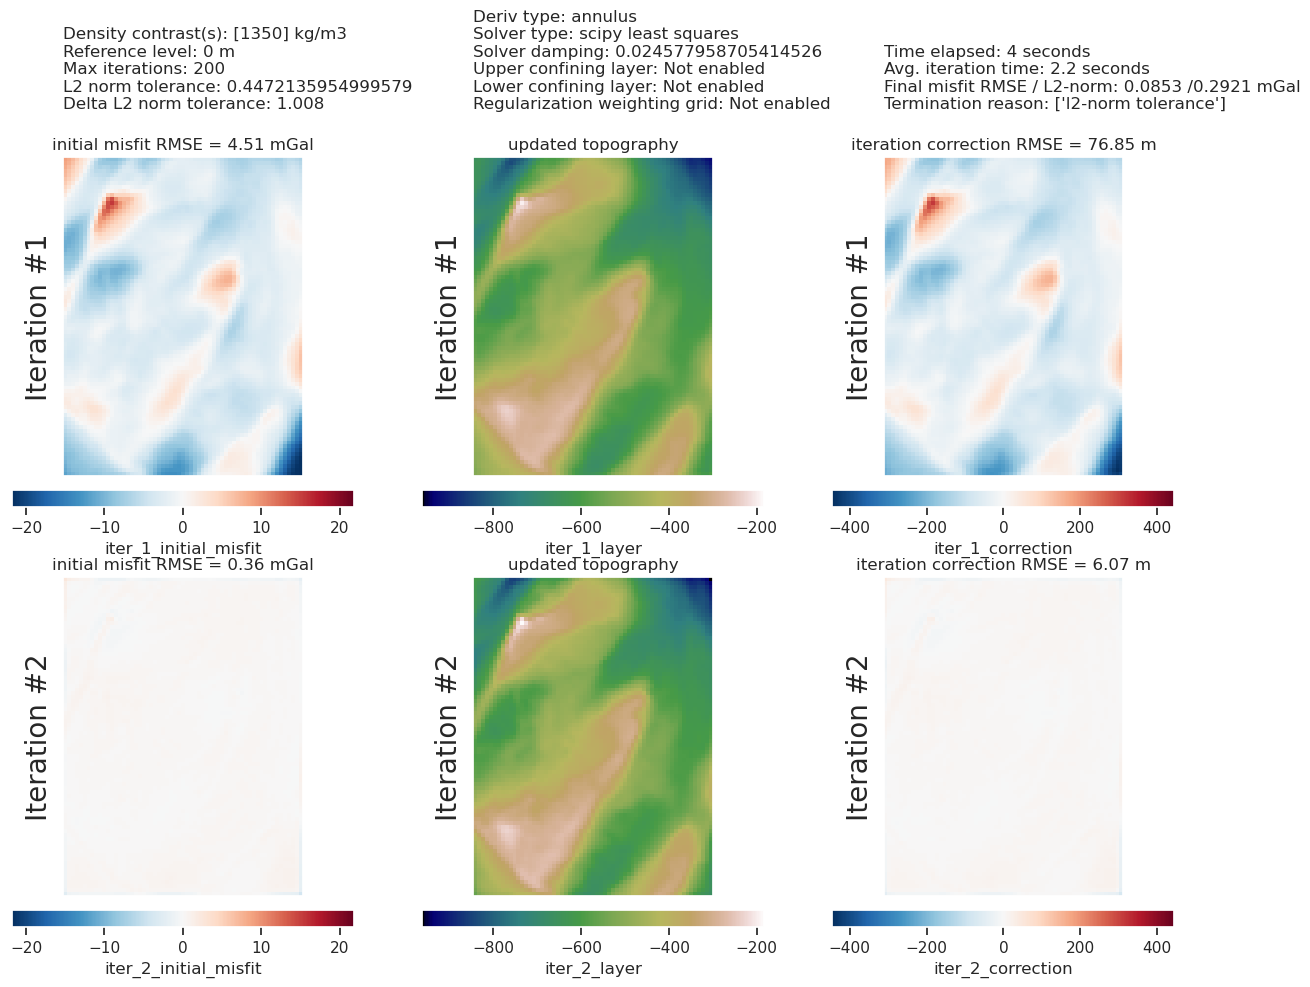

In [18]:
plotting.plot_convergence(
    grav_results,
    params=parameters,
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    bathymetry,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
)

In [19]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 43.25 m


# Density CV

INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_02_density_cv'
INFO:invert4geom:running zref and/or density contrast cross validation


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 9
INFO:invert4geom:	parameter: {'density_contrast': 1475.3568057991342}
INFO:invert4geom:	scores: [0.6026171326522775]
INFO:invert4geom:results saved to ../../results/Ross_Sea_02_density_cv_results.pickle


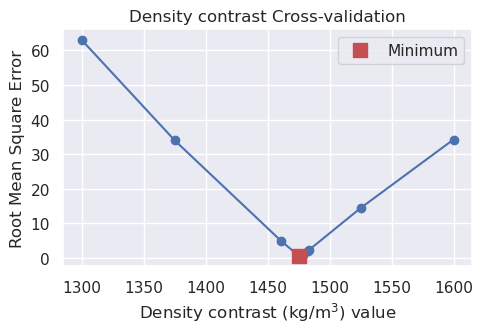

In [40]:
logging.getLogger().setLevel(logging.INFO)

# run the inversion workflow, including a cross validation for the damping parameter
results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    solver_damping=best_damping,
    starting_topography=starting_bathymetry,
    starting_prisms=starting_prisms,
    zref= 0,
    calculate_regional_misfit=True,
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    run_zref_or_density_cv=True,
    constraints_df=constraint_points,
    density_contrast_limits=(1300, 1600),
    zref_density_cv_trials=10,
    plot_cv=True,
    fname="../../results/Ross_Sea_02_density_cv",
    **kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [24]:
# load saved inversion results
with pathlib.Path("../../results/Ross_Sea_02_density_cv_results.pickle").open("rb") as f:
    results = pickle.load(f)

# load study
with pathlib.Path("../../results/Ross_Sea_02_density_cv_zref_density_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [25]:
best_density_contrast = study.best_params["density_contrast"]
print("optimal determined density contrast", best_density_contrast)
print("real density contrast", true_density_contrast)

optimal determined density contrast 1475.3568057991342
real density contrast 1476


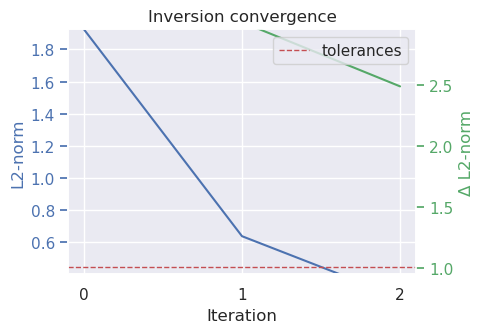

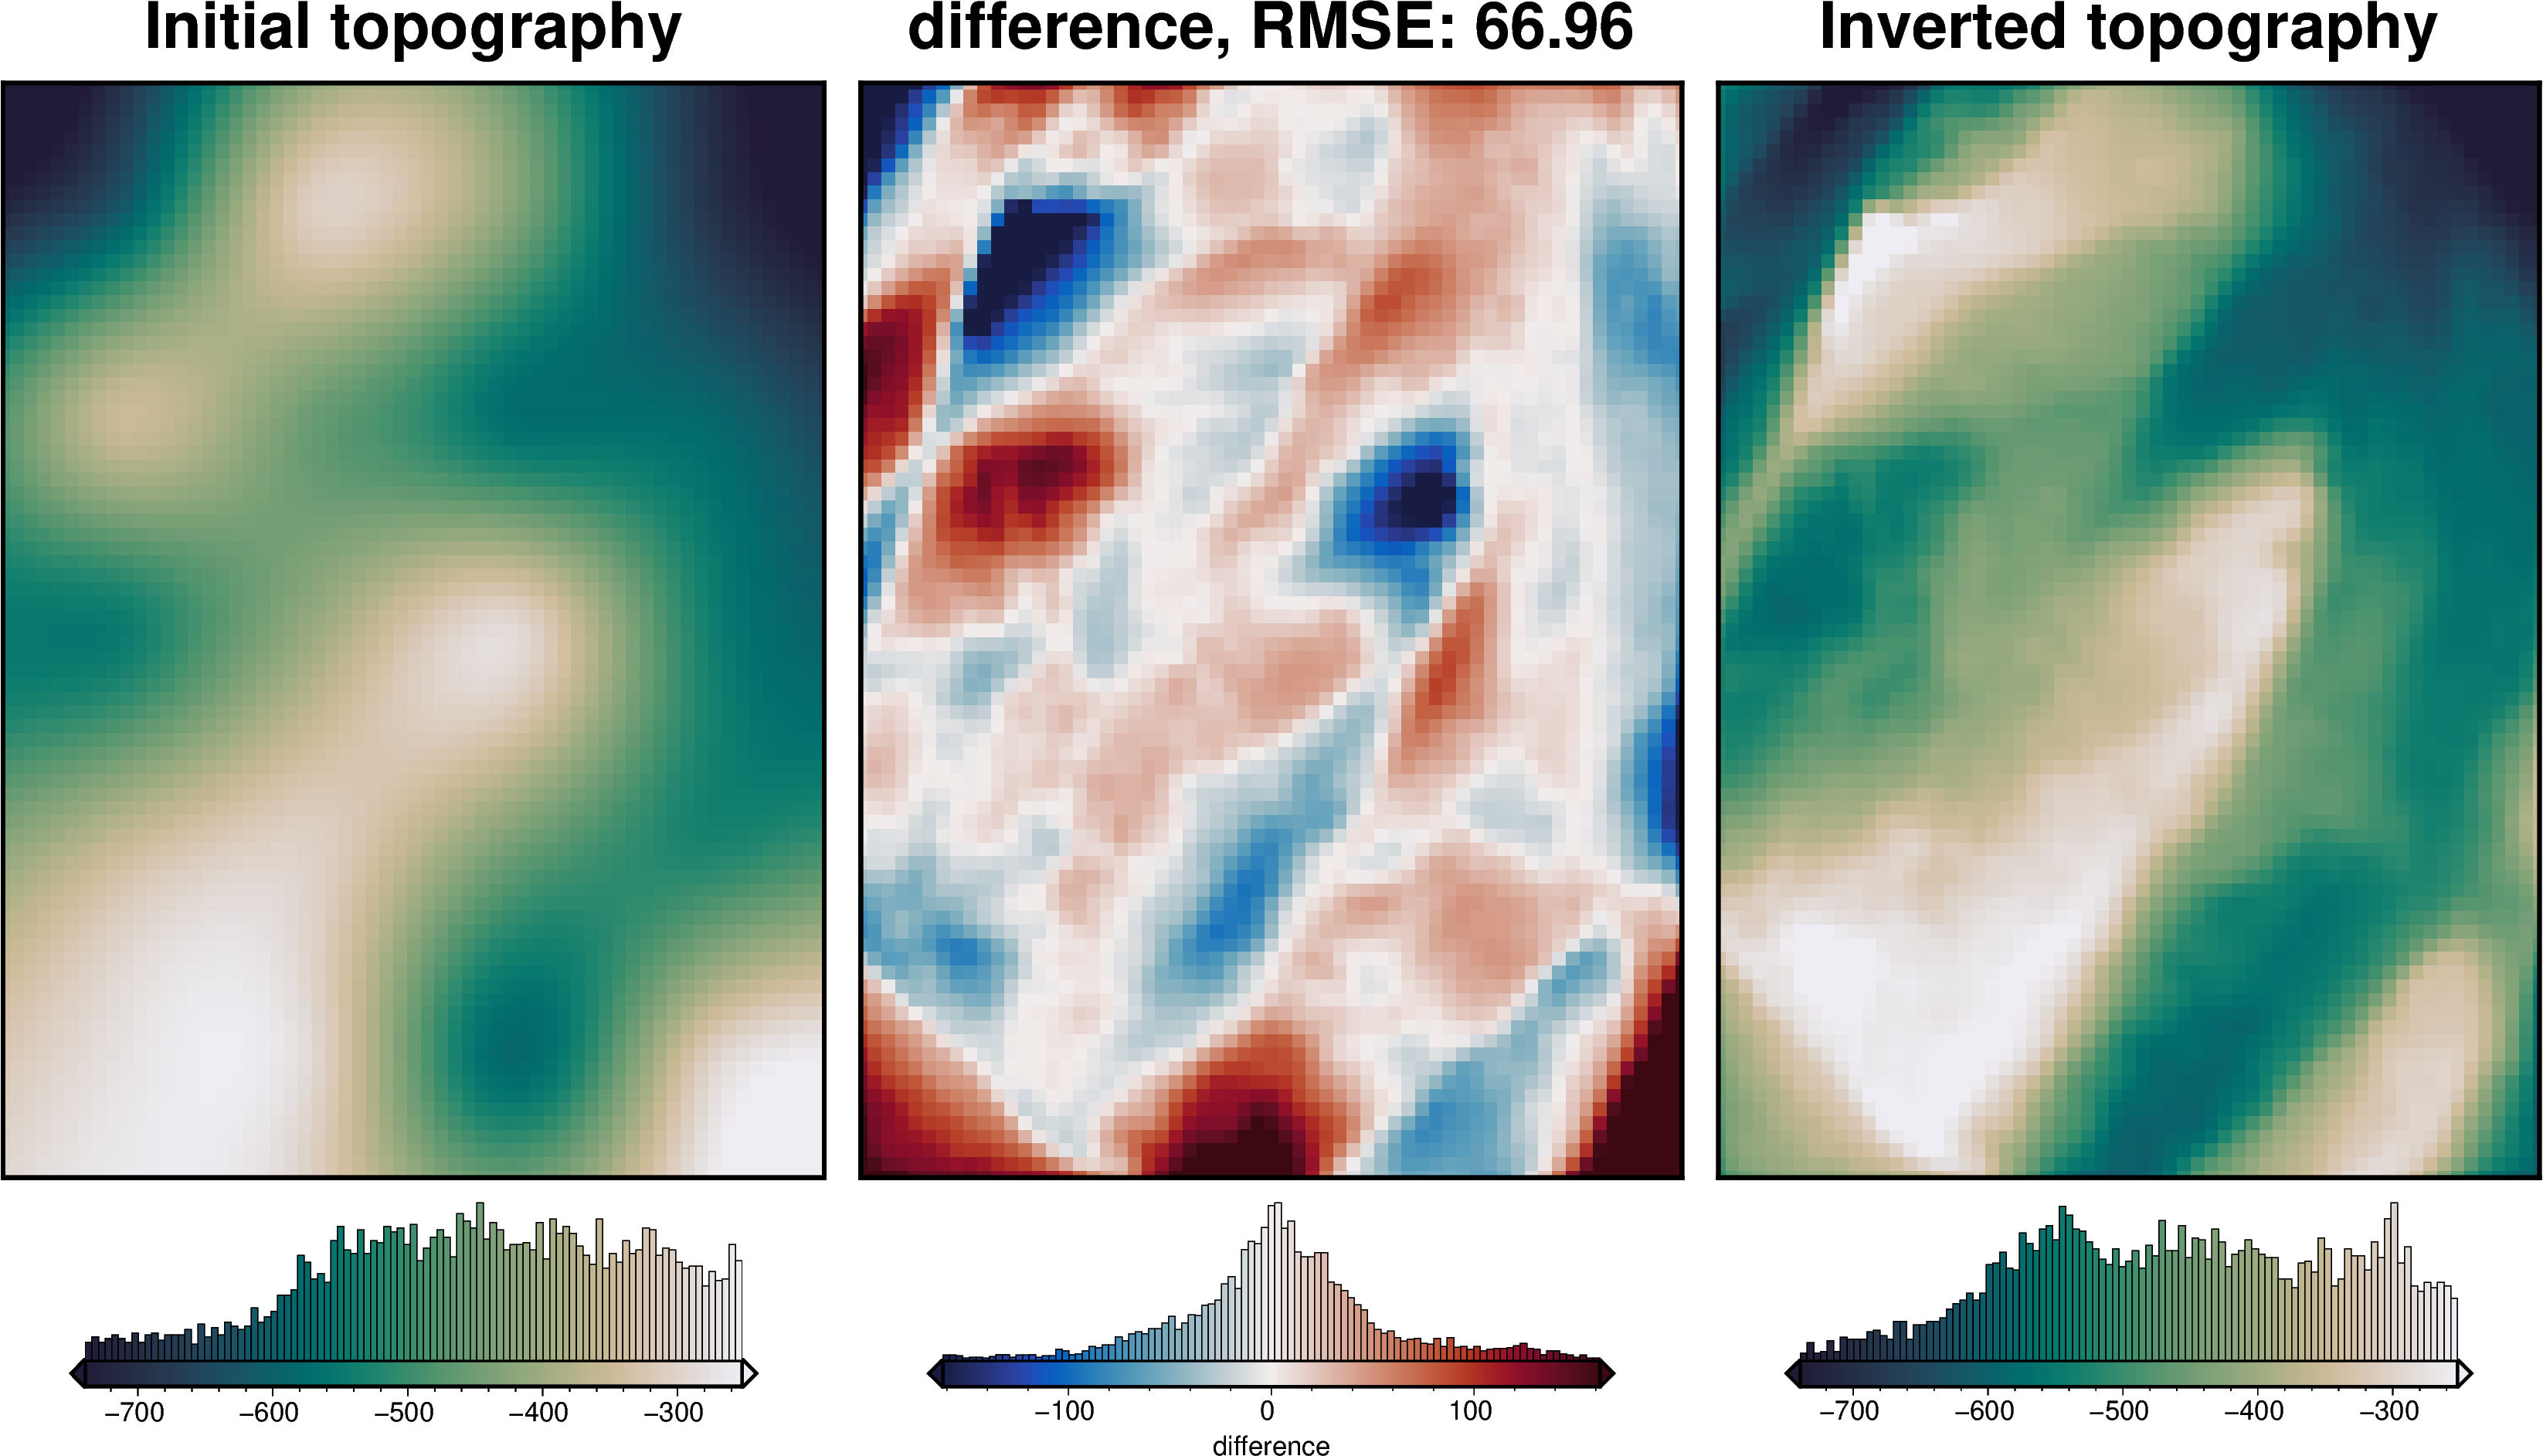

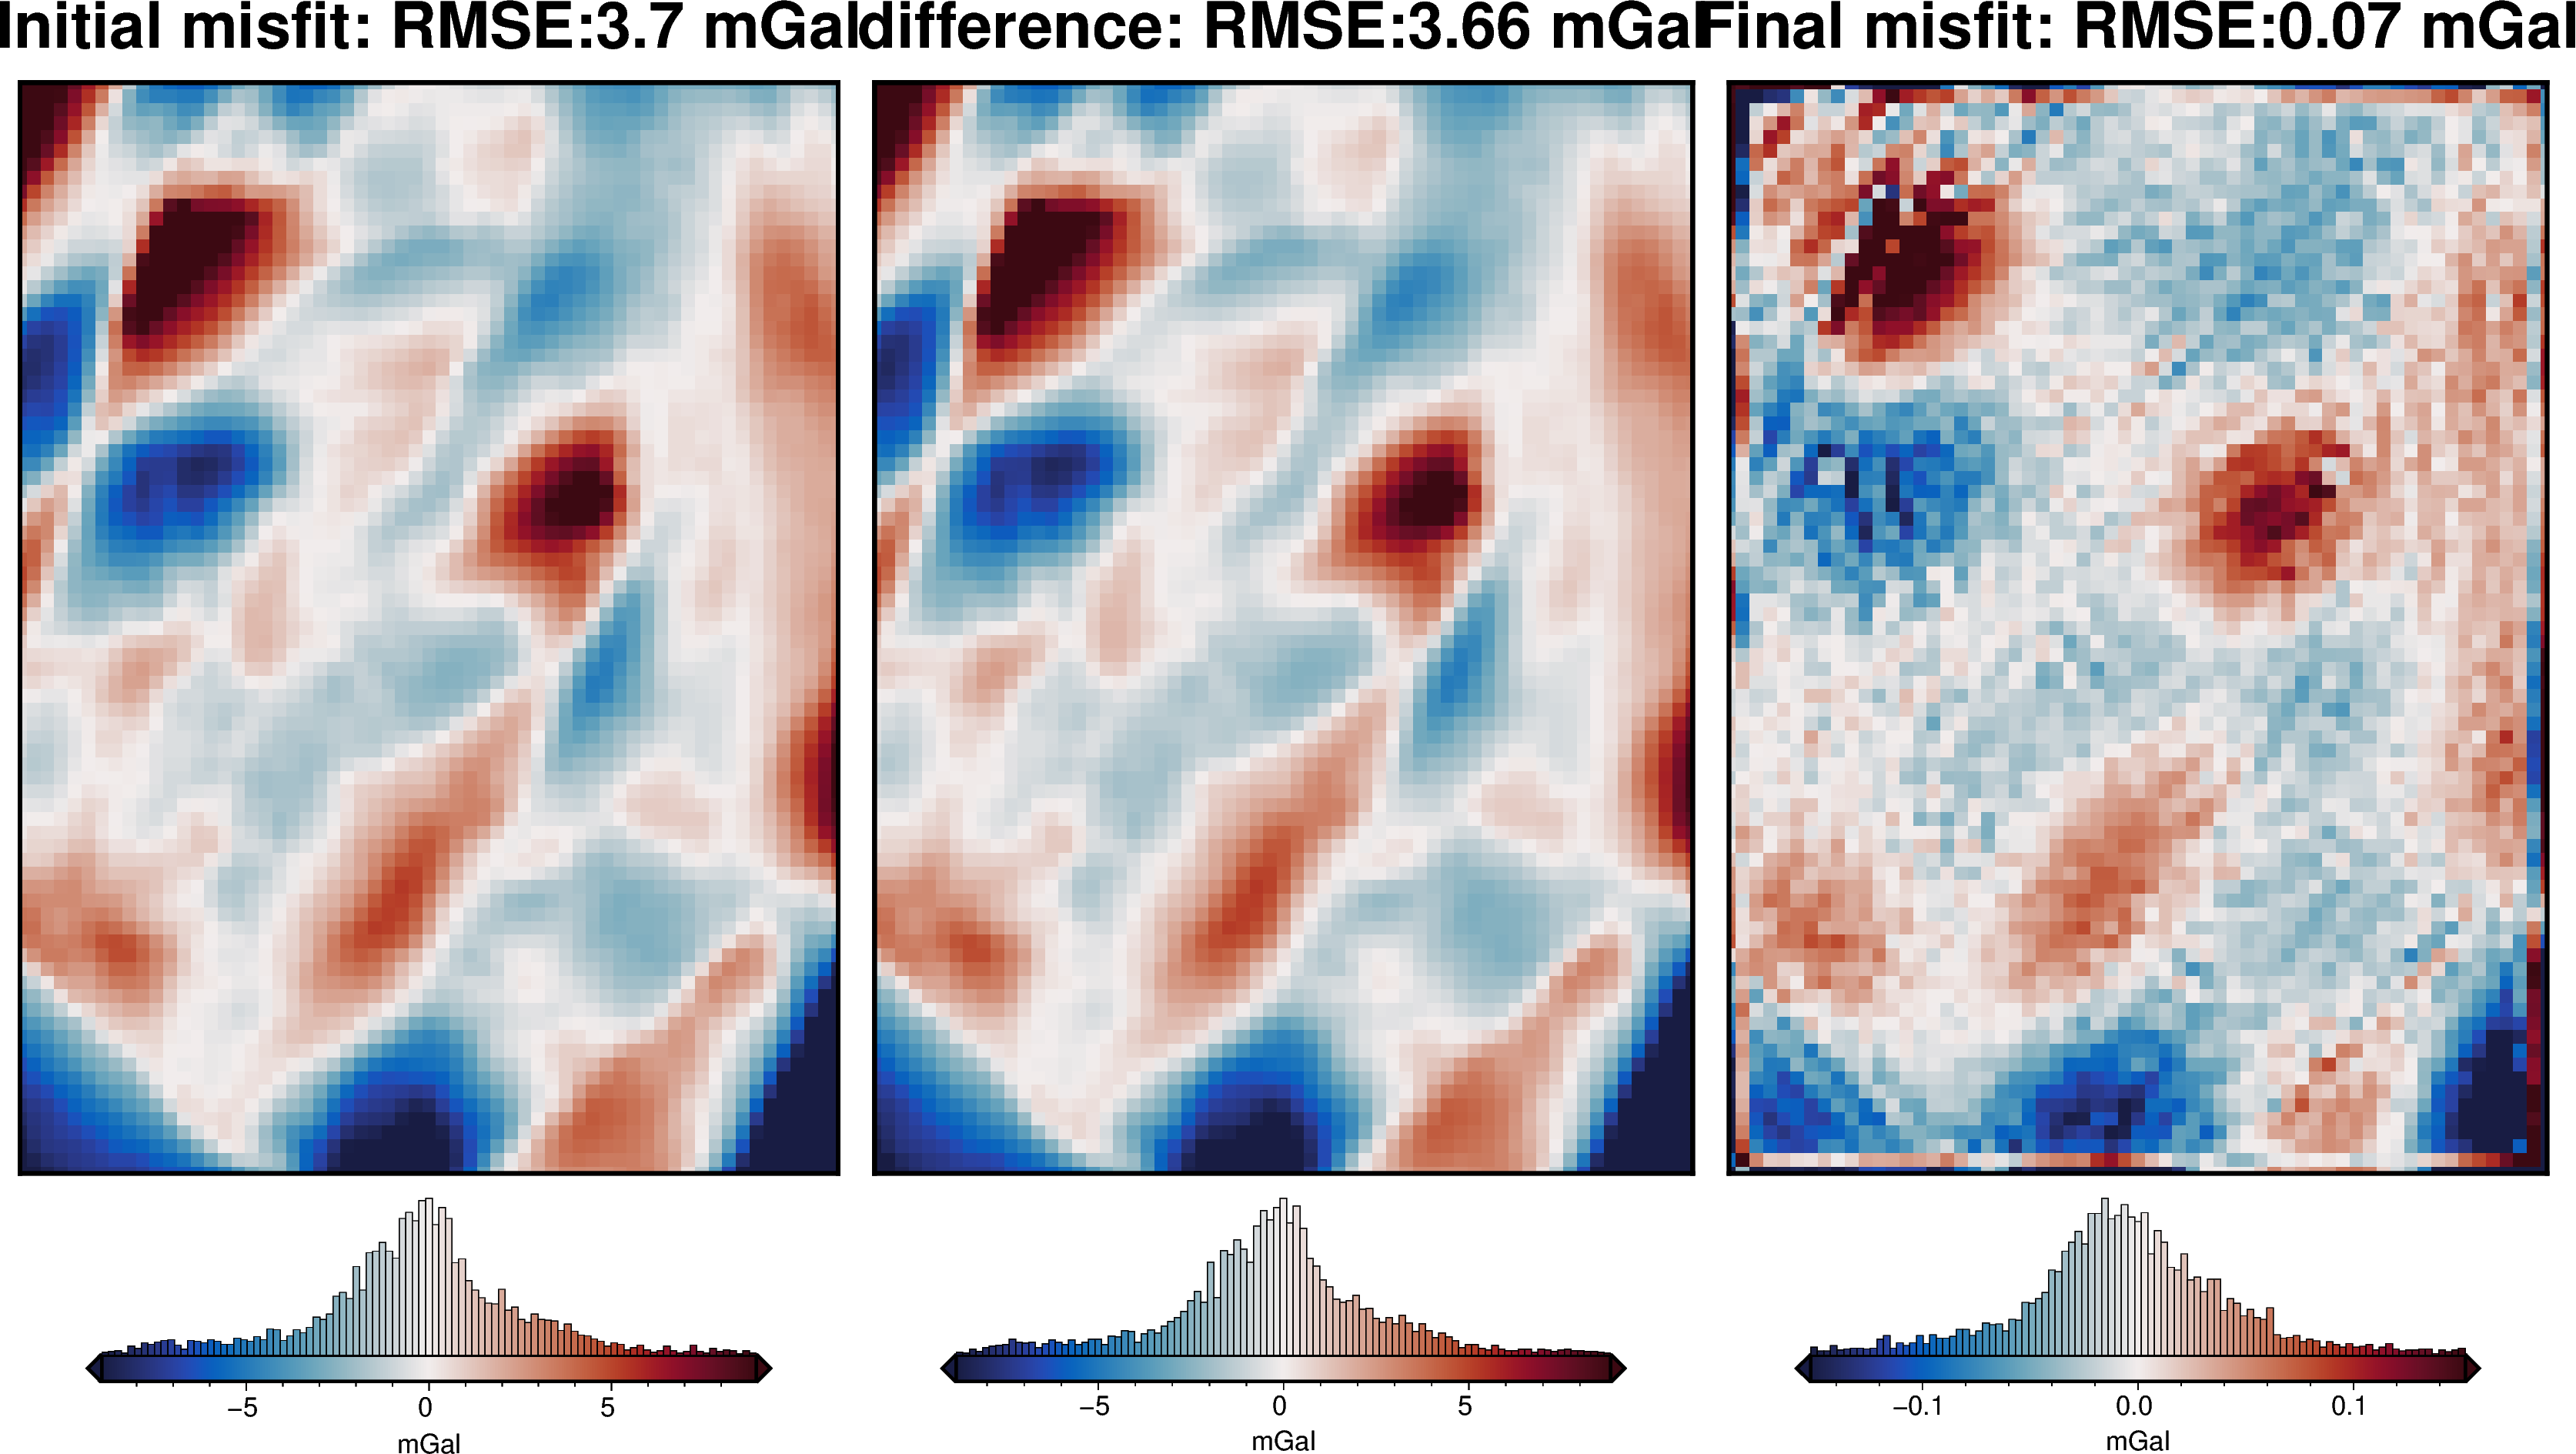

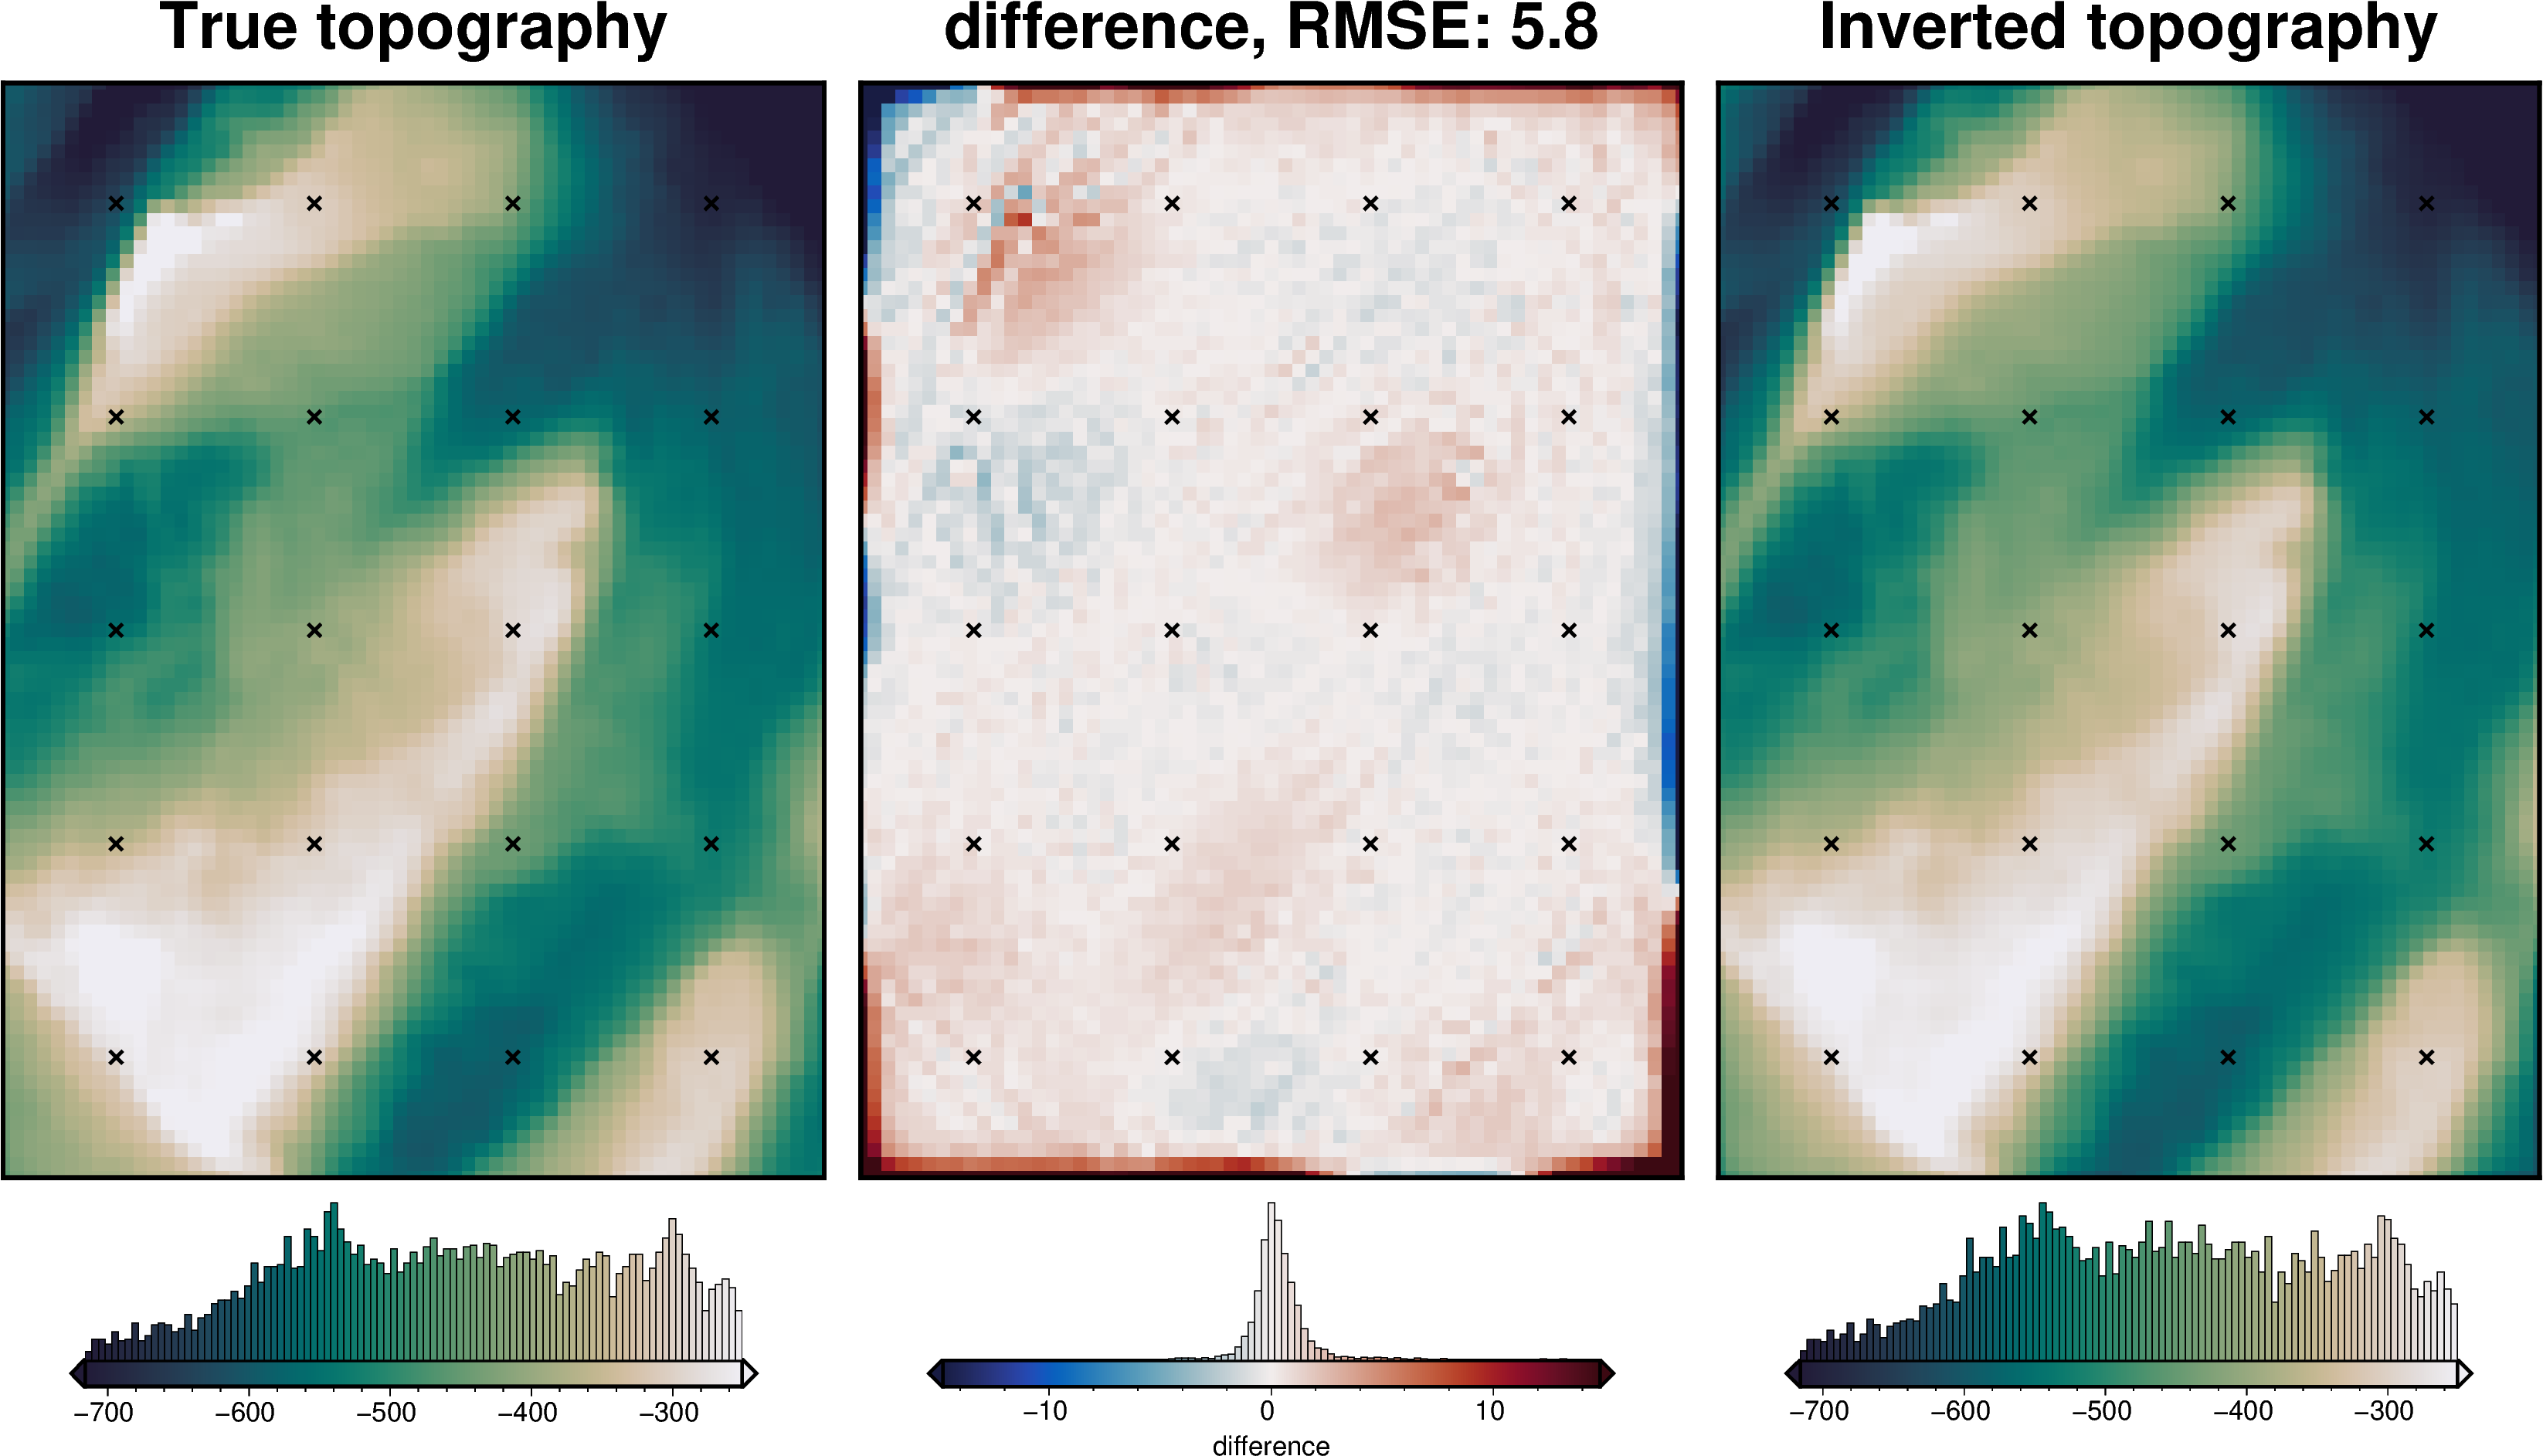

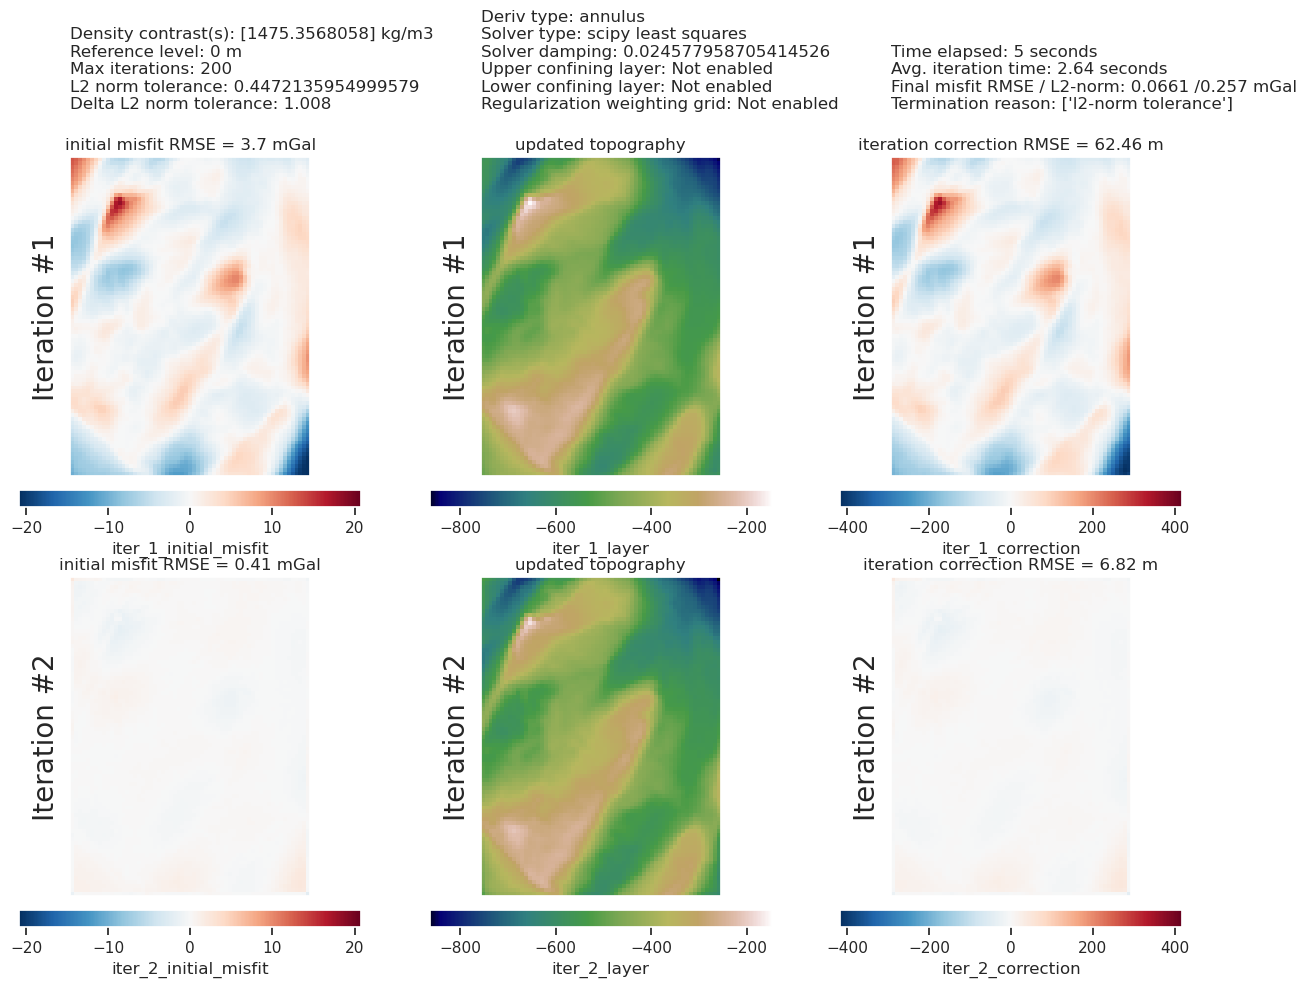

In [26]:
plotting.plot_convergence(
    grav_results,
    params=parameters,
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    bathymetry,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
)

In [27]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 0.60 m


In [28]:
# save to csv
constraint_points.to_csv("../../results/Ross_Sea_02_constraint_points.csv", index=False)

# Uncertainty analysis

## Inversion error

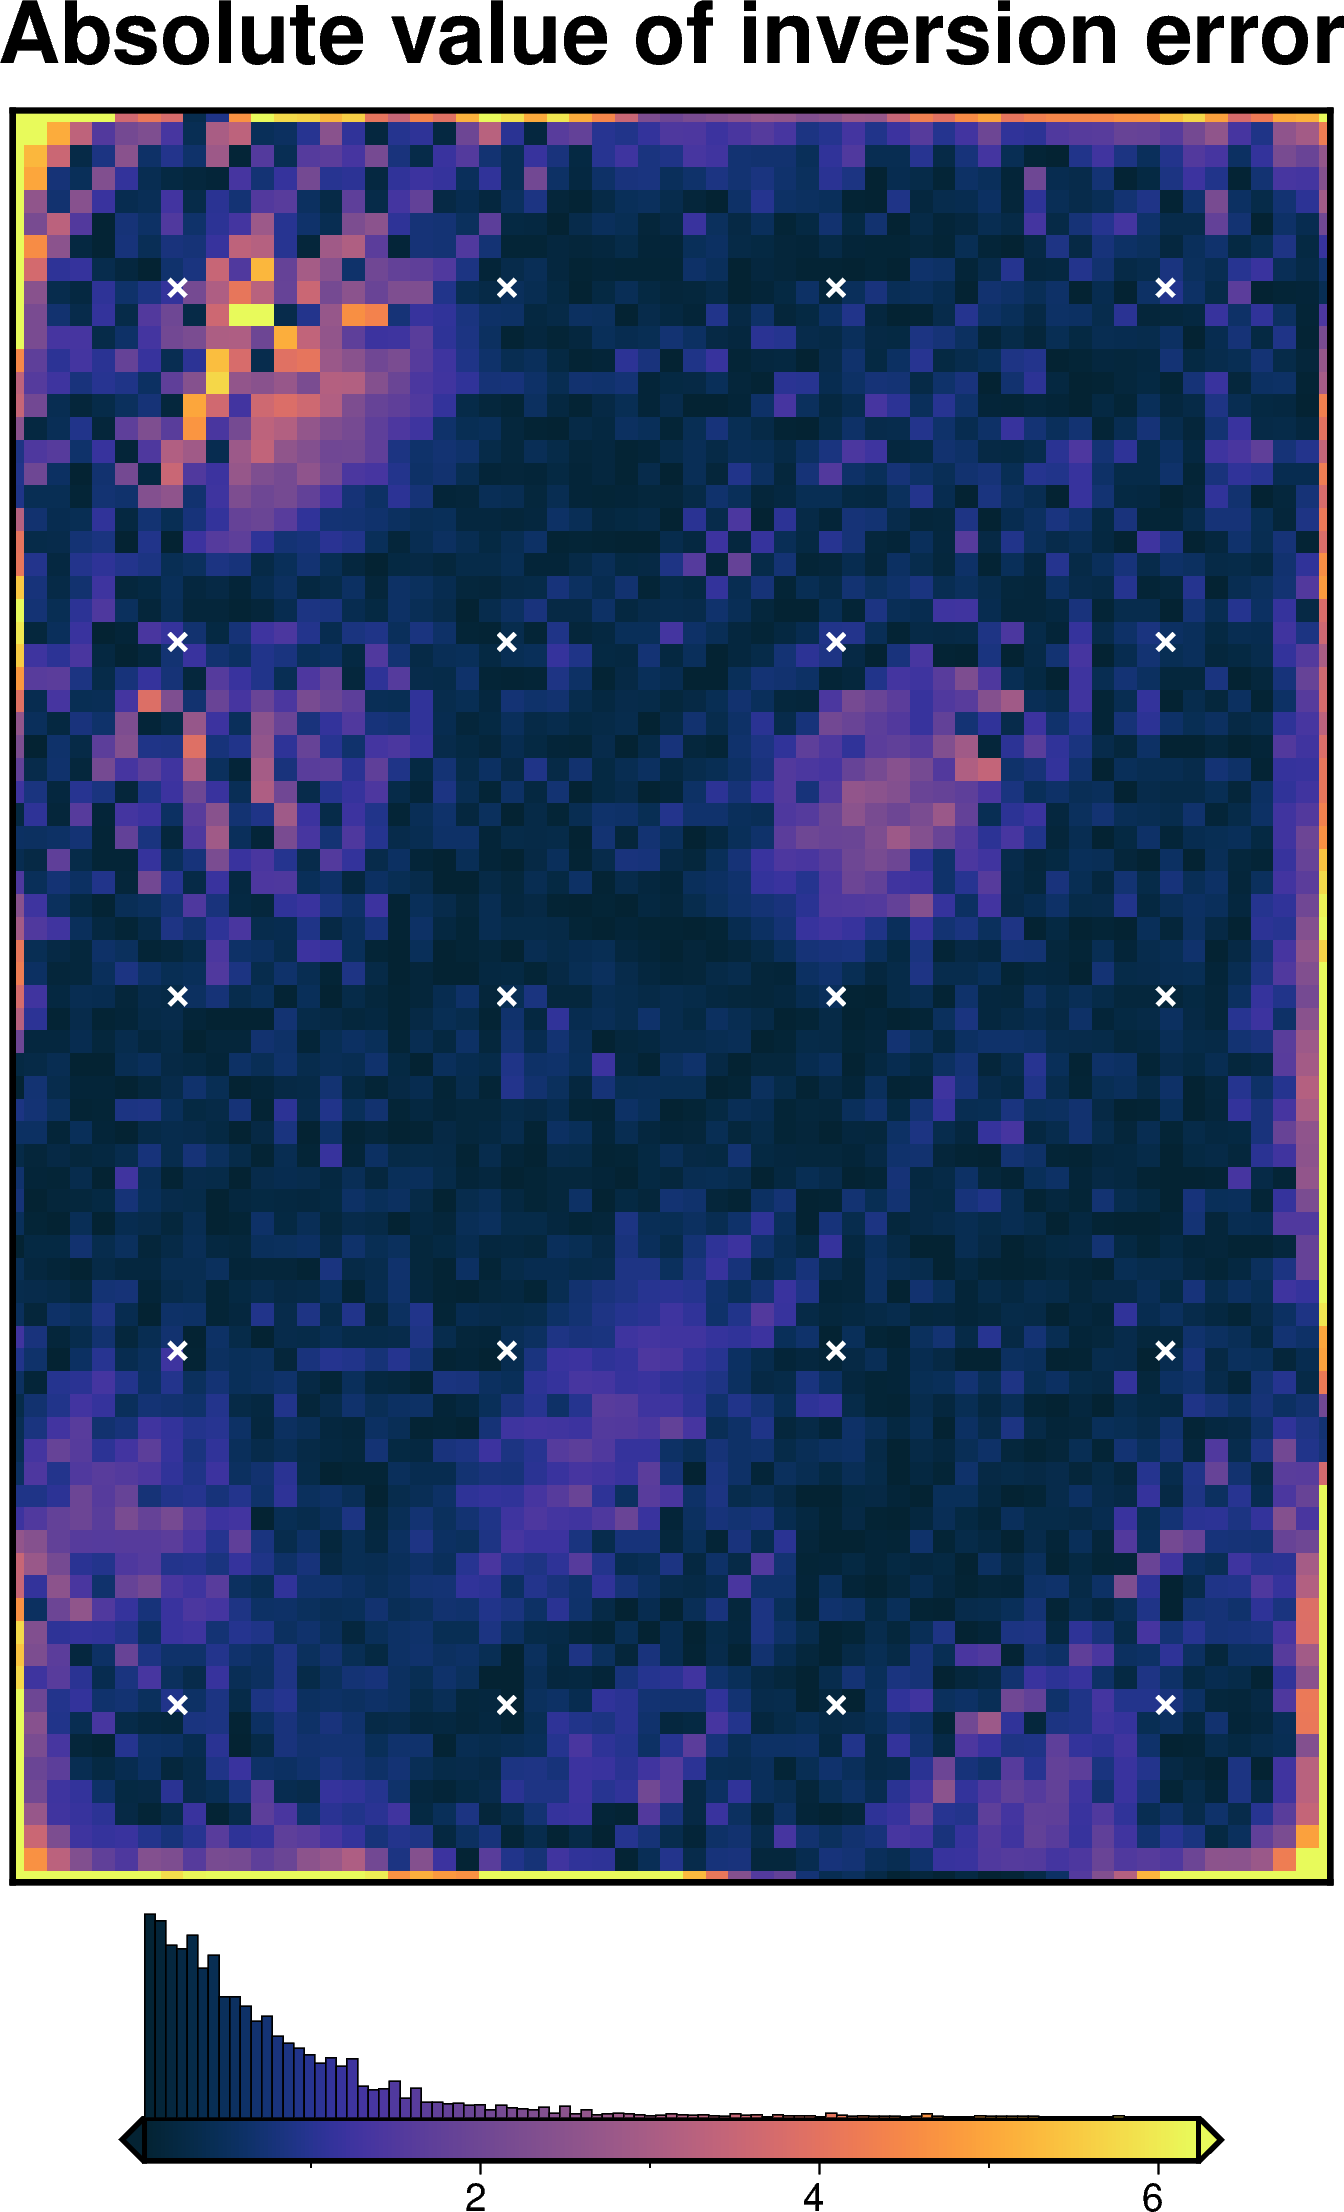

In [29]:
inversion_error = np.abs(bathymetry - final_topography)

fig = maps.plot_grd(
    inversion_error,
    region=vd.pad_region(inversion_region, -spacing),
    hist=True,
    cmap="thermal",
    title="Absolute value of inversion error",
    robust=True,
    points=constraint_points,
    points_style="x.2c",
    points_fill="white",
)
fig.show()

## Redo starting gravity and regional separation
use the optimal determined density contrast

In [30]:
# set the reference level from the prisms to 0
zref = 0
density_grid = xr.where(
    starting_bathymetry >=  zref,
    best_density_contrast,
    -best_density_contrast,
)
# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_bathymetry,
    zref,
    density=density_grid,
)
grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
regional_grav_kwargs = dict(
    grav_df=grav_df,
    method="constant",
    constant=0,
)
grav_df = regional.regional_separation(**regional_grav_kwargs)

  0%|          | 0/4941 [00:00<?, ?it/s]

In [31]:
# add best damping parameter to kwargs
kwargs["solver_damping"] = best_damping

# kwargs to reuse for all uncertainty analyses
uncert_kwargs = dict(
    grav_df=grav_df,
    density_contrast=best_density_contrast,
    zref=zref,
    starting_prisms=starting_prisms,
    starting_topography=starting_bathymetry,
    regional_grav_kwargs=regional_grav_kwargs,
    **kwargs,
)

## Solver damping component

In [ ]:
# load study
with pathlib.Path("../../results/Ross_Sea_02_damping_cv_damping_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

study_df = study.trials_dataframe().drop(columns=["user_attrs_results"])
study_df=study_df.sort_values("value")

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2=study_df[(np.abs(study_df.value_zscore) < 2)]

# pick damping standard deviation based on optimization
stdev = np.log10(study_df2.params_damping).std()
print(f"calculated stdev: {stdev}")
stdev = .05
print(f"using stdev: {stdev}")


calculated stdev: 0.3904326880097539
using stdev: 0.05


best: 0.024577958705414526 
std: 0.05 
+1std: 0.02757692323654669 
-1std: 0.021905128753613147


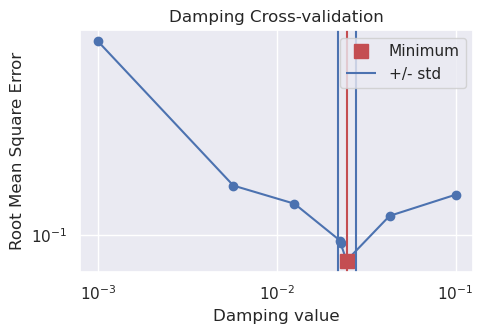

In [33]:
fig = plotting.plot_cv_scores(
    study_df.value,
    study_df.params_damping,
    param_name="Damping",
    logx=True,
    logy=True,
)
ax = fig.axes[0]

best = float(study_df2.params_damping.iloc[0])
upper = float(10**(np.log10(best)+stdev))
lower = float(10**(np.log10(best)-stdev))

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", stdev, "\n+1std:", upper, "\n-1std:", lower)

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.0247215783892229, min: 0.020337760506593267, max: 0.029702191346447755
INFO:invert4geom:all 10 runs already complete, loading results from files.


stochastic ensemble: 0it [00:00, ?it/s]

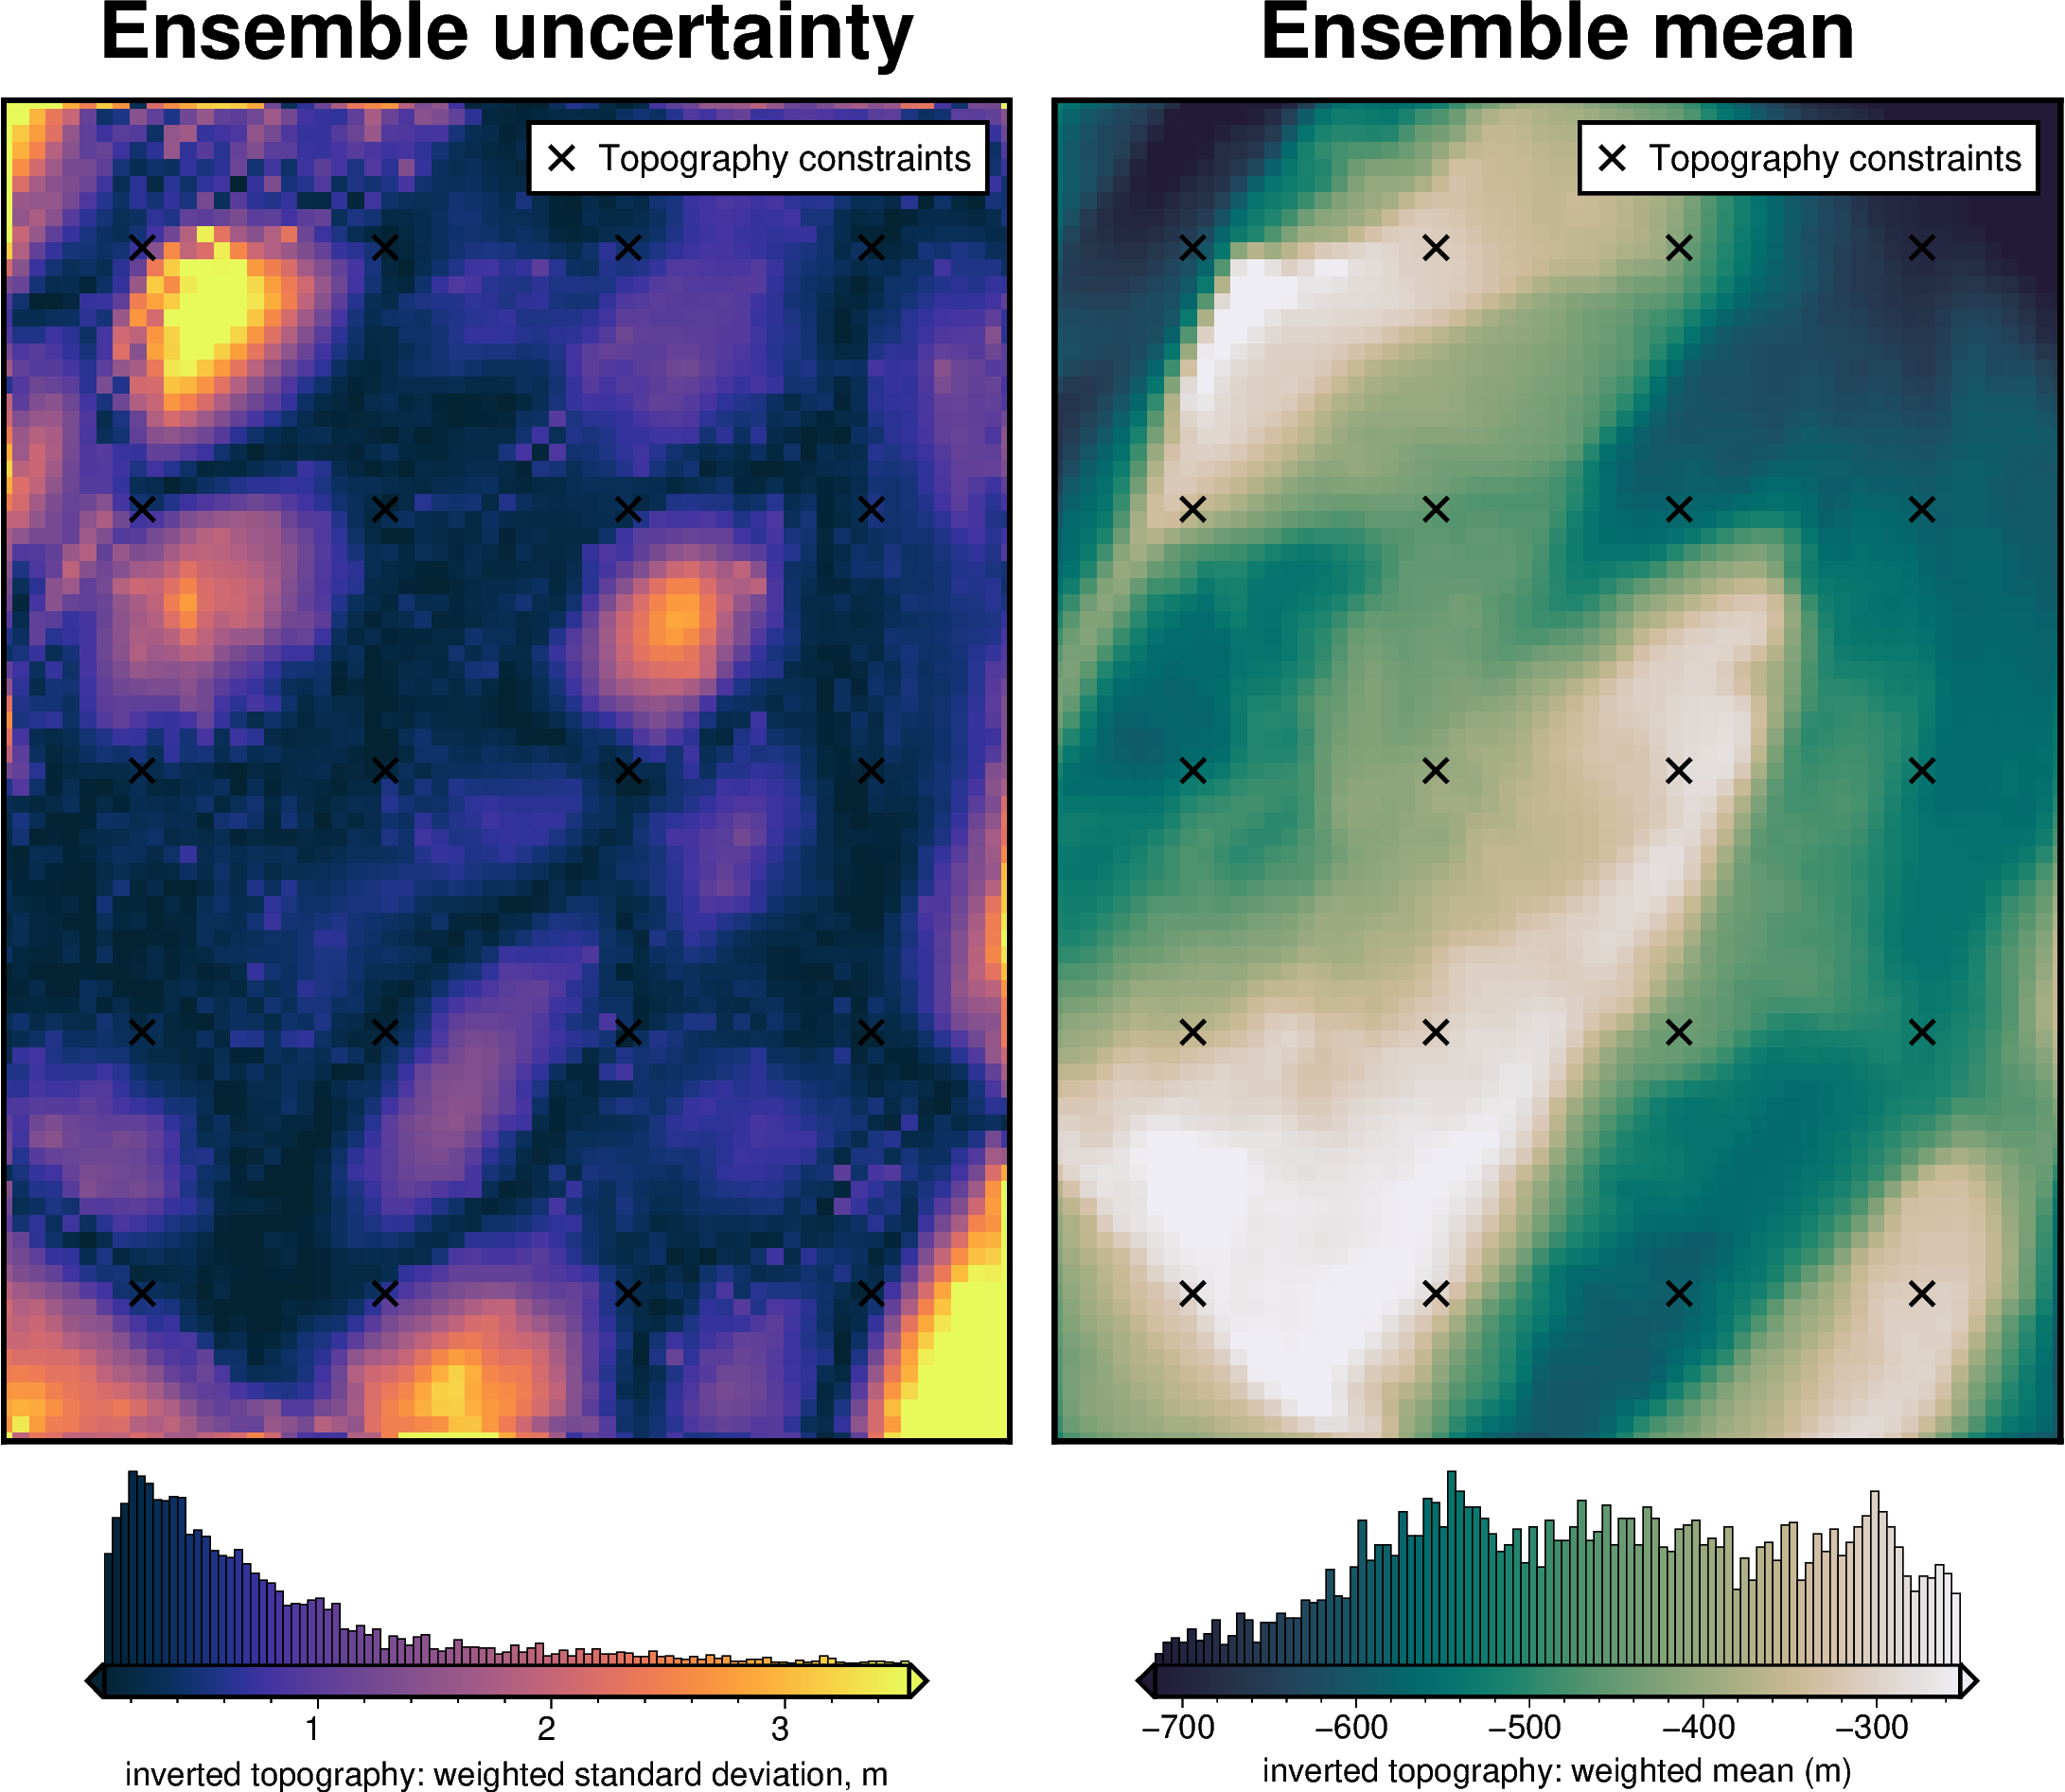

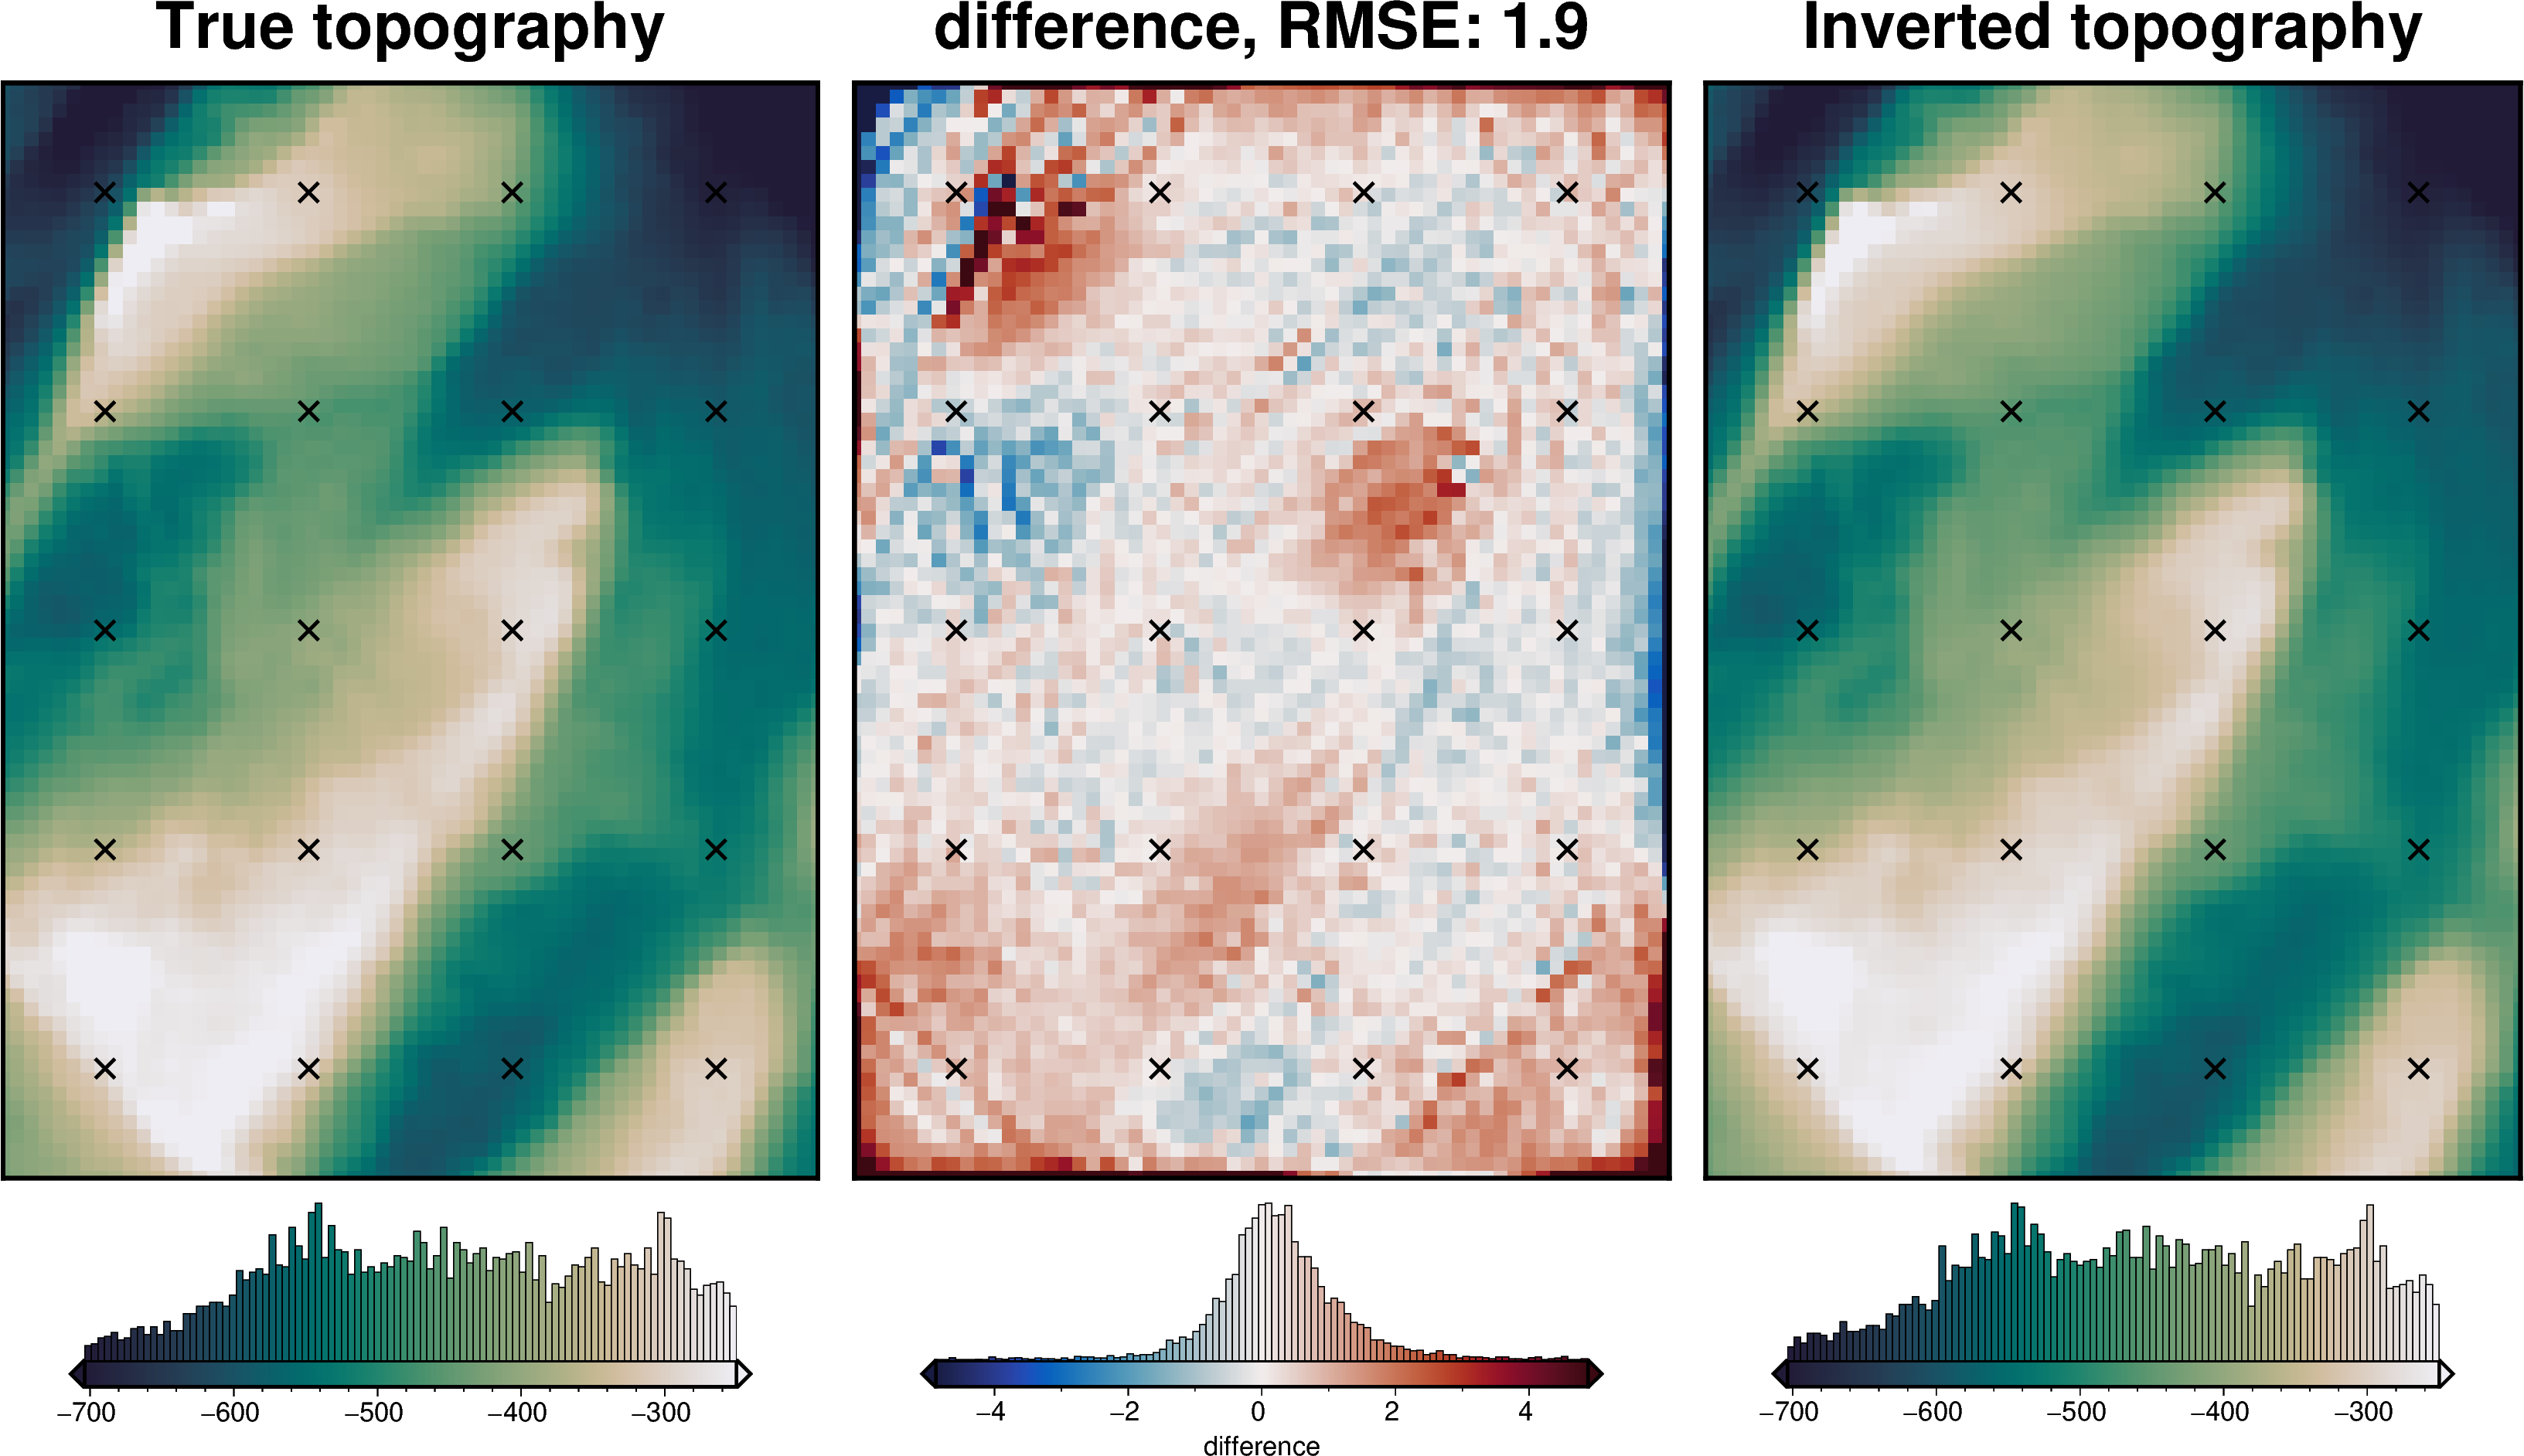

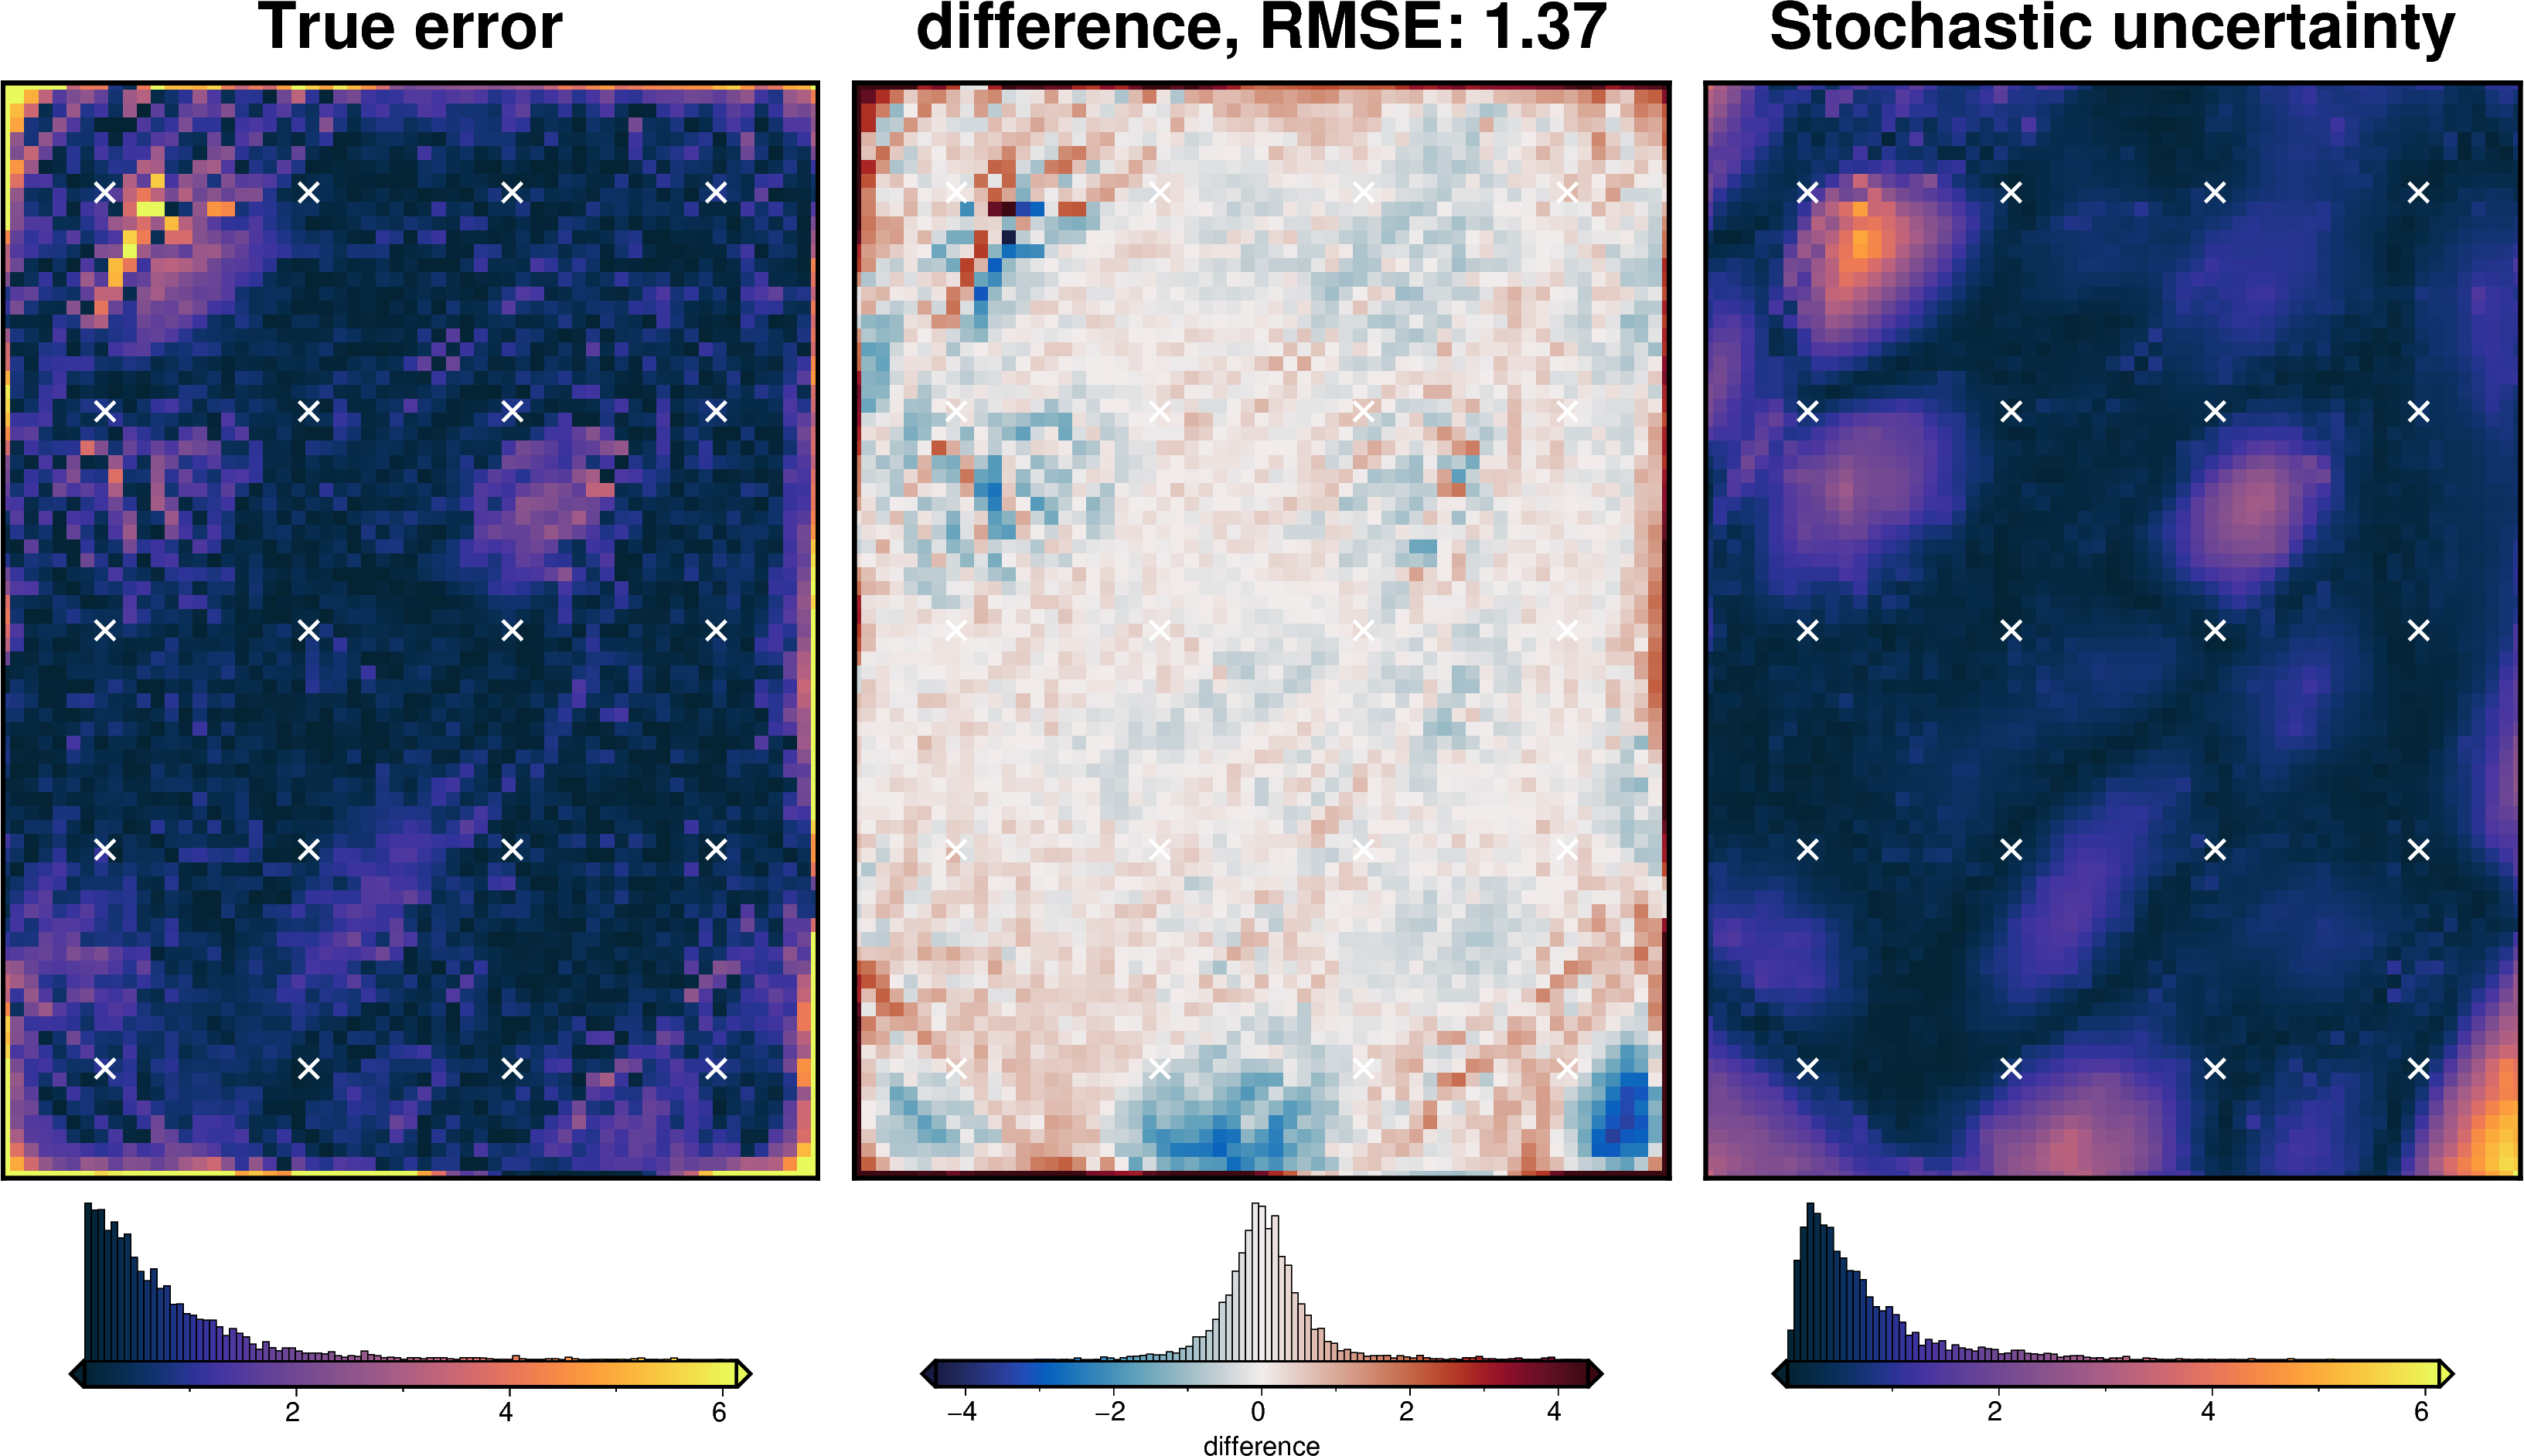

In [34]:
solver_dict = {
    "solver_damping": {
        "distribution": "normal",
        "loc": np.log10(best_damping),  # mean of base 10 exponent
        "scale": stdev,  # standard deviation of base 10 exponent
        "log": True,
    },
}
fname = "../../results/Ross_Sea_02_uncertainty_damping"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_damping_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=solver_dict,
    **uncert_kwargs,
)

stats_ds = RIS_plotting.uncert_plots(
    uncert_damping_results,
    inversion_region,
    spacing,
    bathymetry,
    constraint_points=constraint_points,
    weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
)

## Density component

In [35]:
true_density_contrast

1476

In [ ]:
# load study
with pathlib.Path("../../results/Ross_Sea_02_density_cv_zref_density_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

study_df = study.trials_dataframe()
study_df=study_df.sort_values("value")

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2=study_df[(np.abs(study_df.value_zscore) < 2)]

stdev = study_df2.params_density_contrast.std()
print(f"calculated stdev: {stdev}")

# manually pick a stdev
stdev = 5
print(f"using stdev: {stdev}")

calculated stdev: 58.91456267900016
using stdev: 5


best: 1475.3568057991342 
std: 5 
+1std: 1480.3568057991342 
-1std: 1470.3568057991342


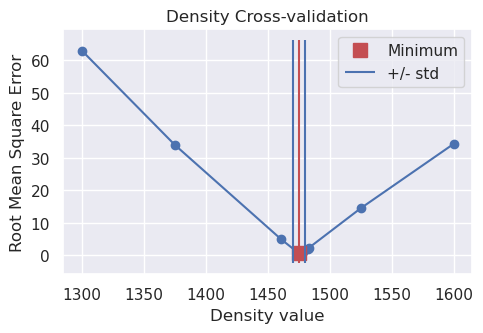

In [37]:
fig = plotting.plot_cv_scores(
    study.trials_dataframe().value.values,
    study.trials_dataframe().params_density_contrast.values,
    param_name="Density",
    logx=False,
    logy=False,
)
ax = fig.axes[0]

best = study_df2.params_density_contrast.iloc[0]
upper = best+stdev
lower = best-stdev

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", stdev, "\n+1std:", upper, "\n-1std:", lower)

INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 1475.3568057991342, min: 1467.132537664377, max: 1483.5810739338915
INFO:invert4geom:all 10 runs already complete, loading results from files.


stochastic ensemble: 0it [00:00, ?it/s]

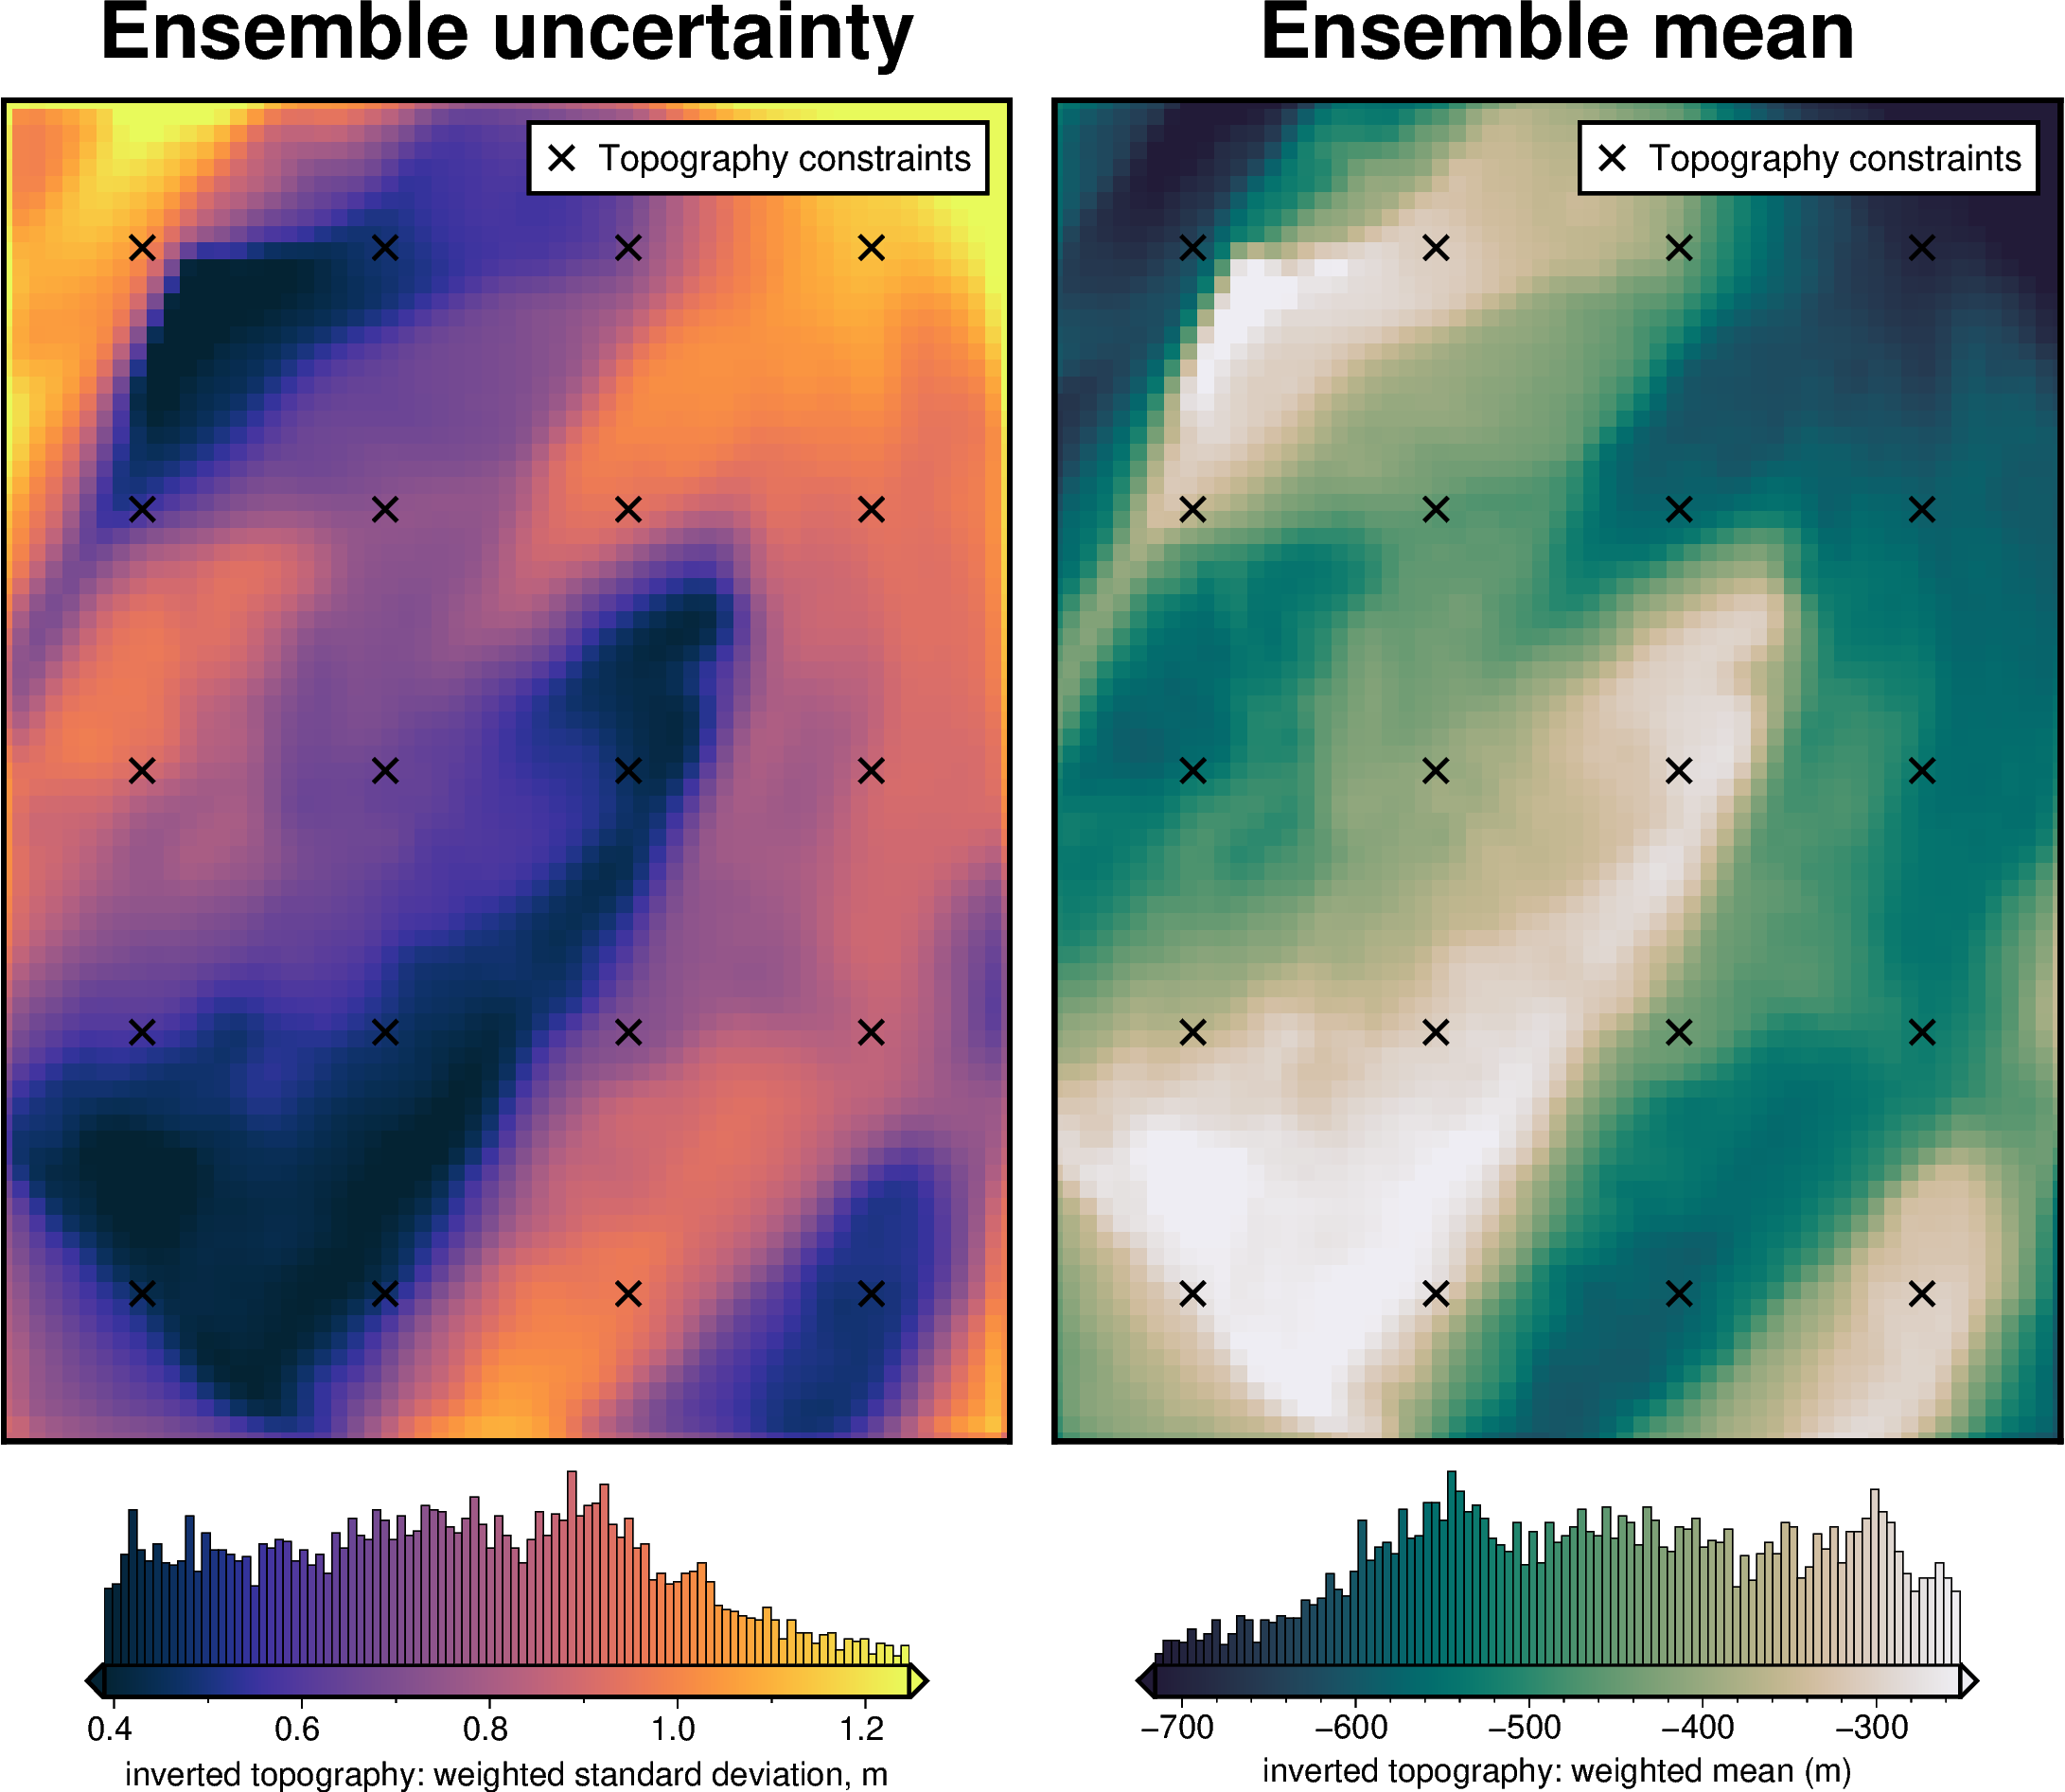

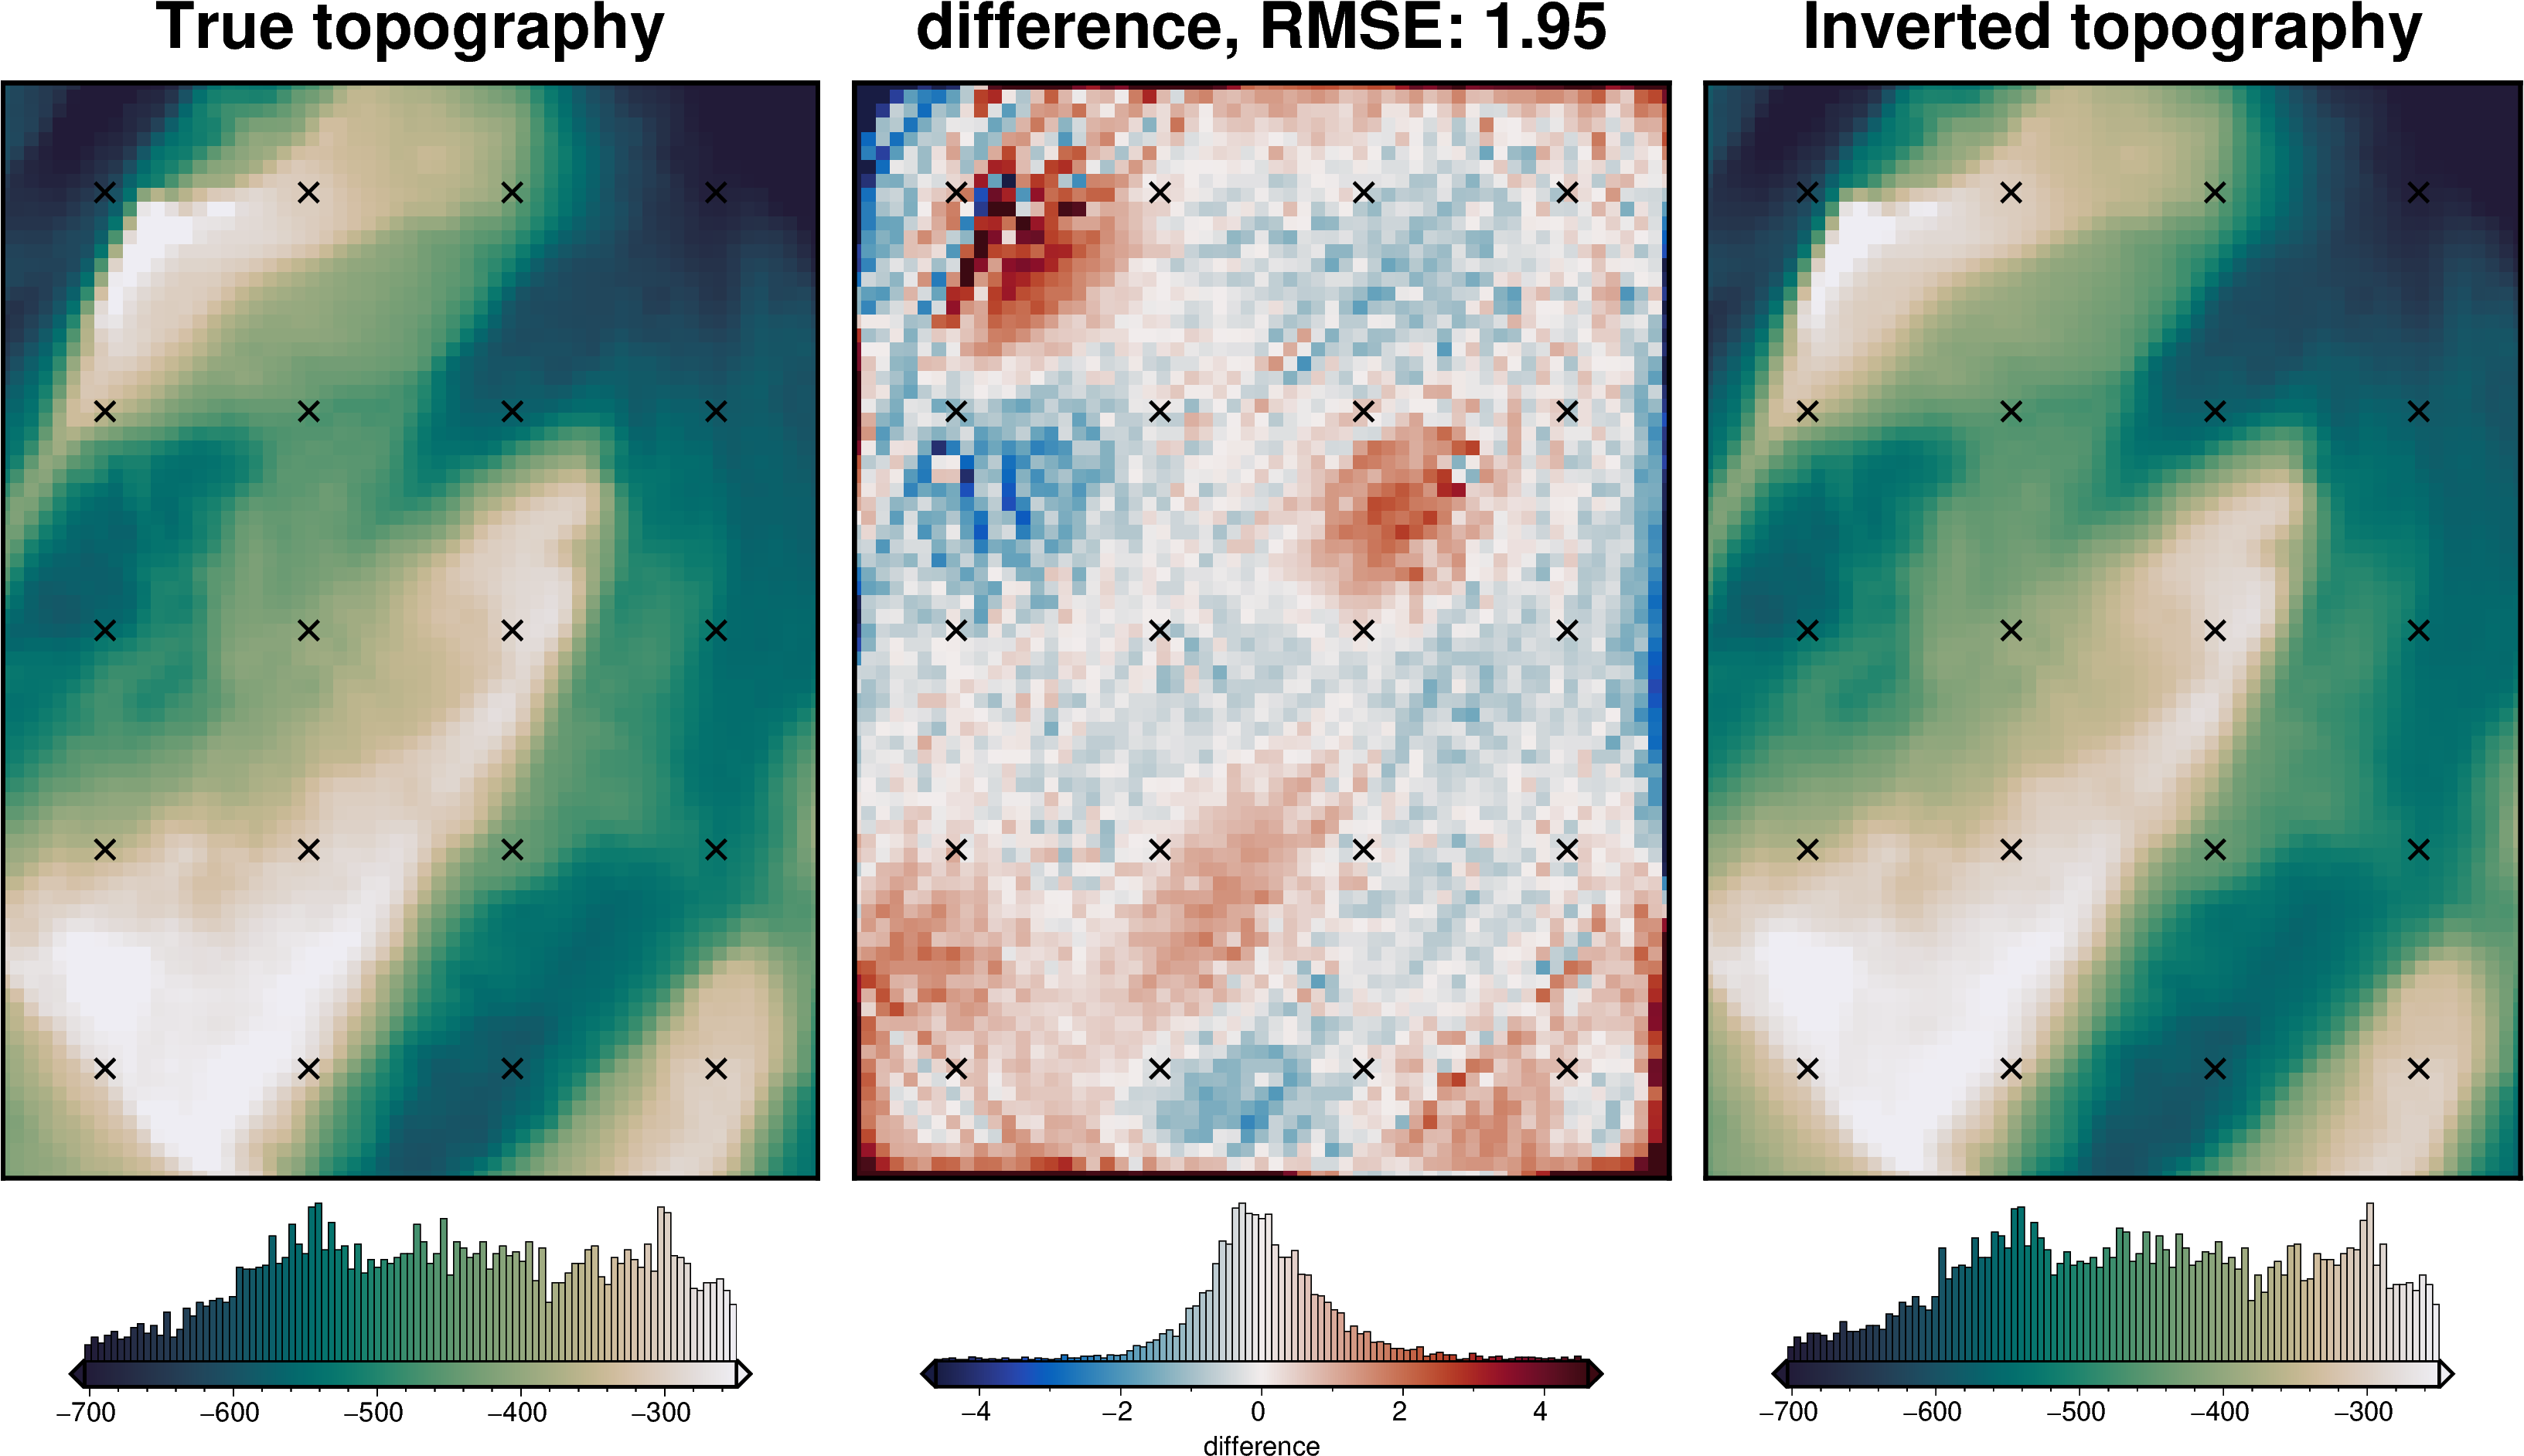

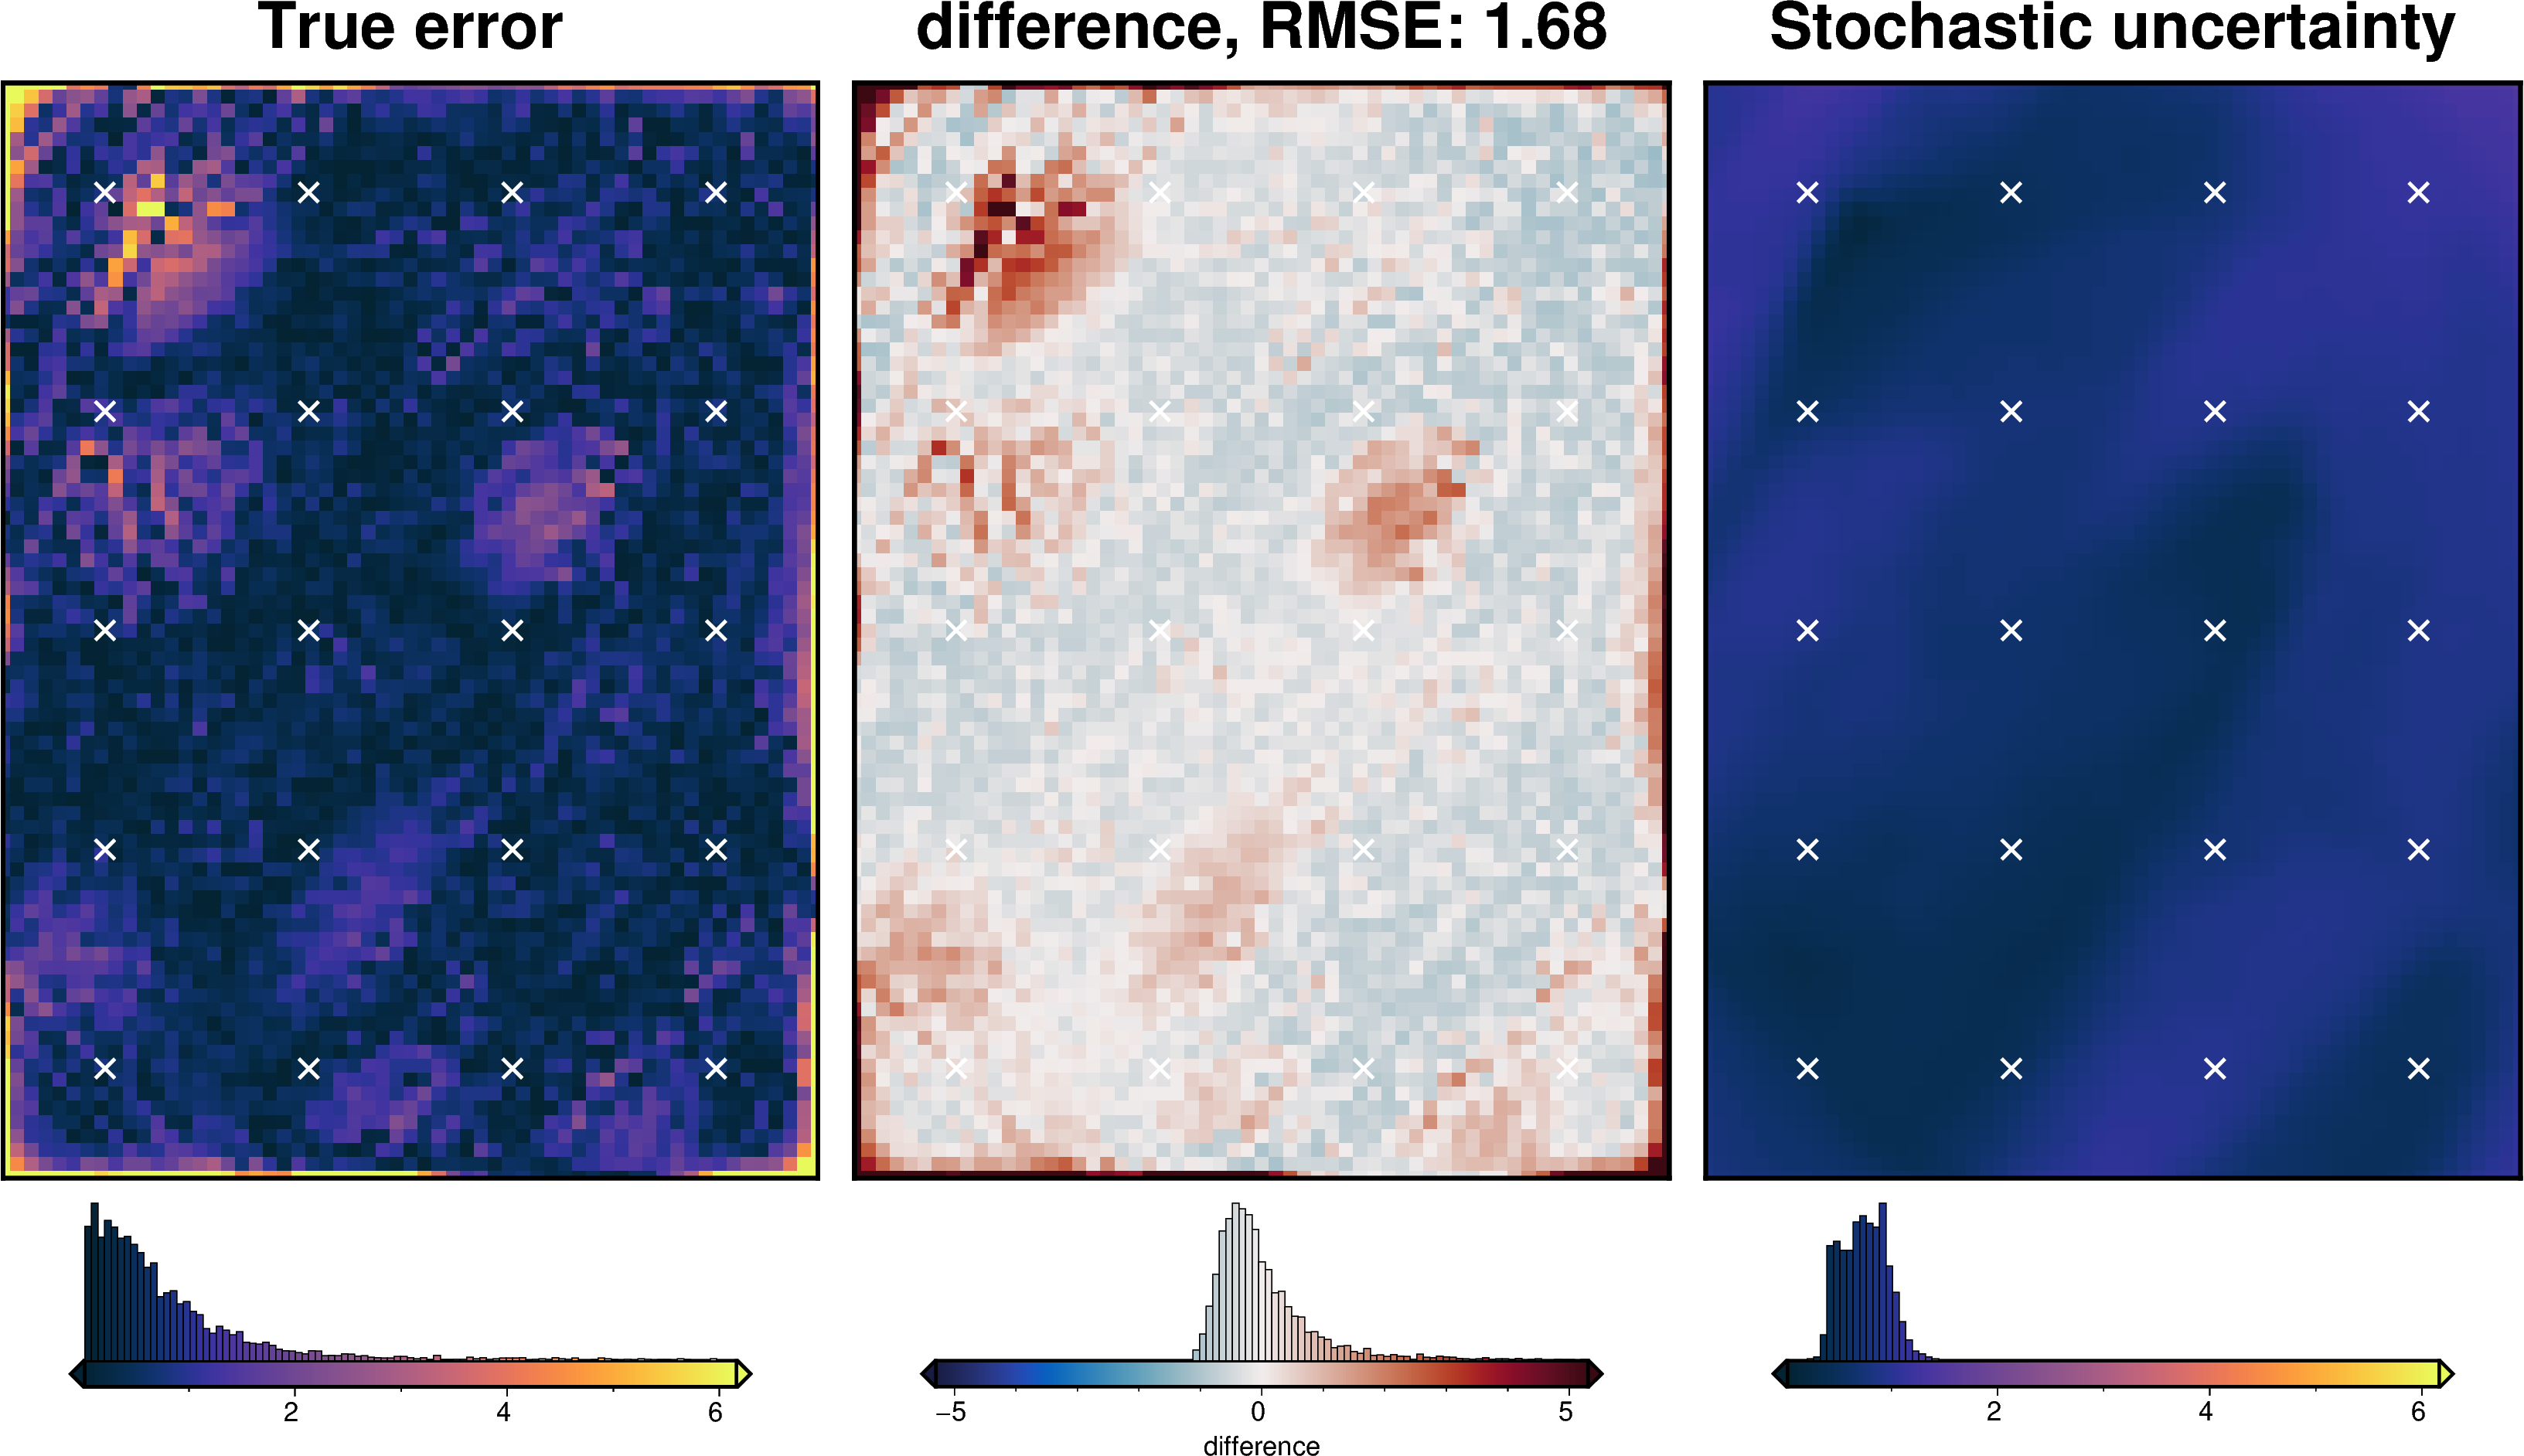

In [38]:
density_dict = {
    "density_contrast": {
        "distribution": "normal",
        "loc": best_density_contrast,
        "scale": stdev,
    },
}
fname = "../../results/Ross_Sea_02_uncertainty_density"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_density_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=density_dict,
    **uncert_kwargs,
)

stats_ds = RIS_plotting.uncert_plots(
    uncert_density_results,
    inversion_region,
    spacing,
    bathymetry,
    constraint_points=constraint_points,
    weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
)

## Total uncertainty

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.024731235362660794, min: 0.01961316179530637, max: 0.030799524341334046
INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 1475.3568057991342, min: 1465.556985876434, max: 1485.1566257218344
INFO:invert4geom:all 20 runs already complete, loading results from files.


stochastic ensemble: 0it [00:00, ?it/s]

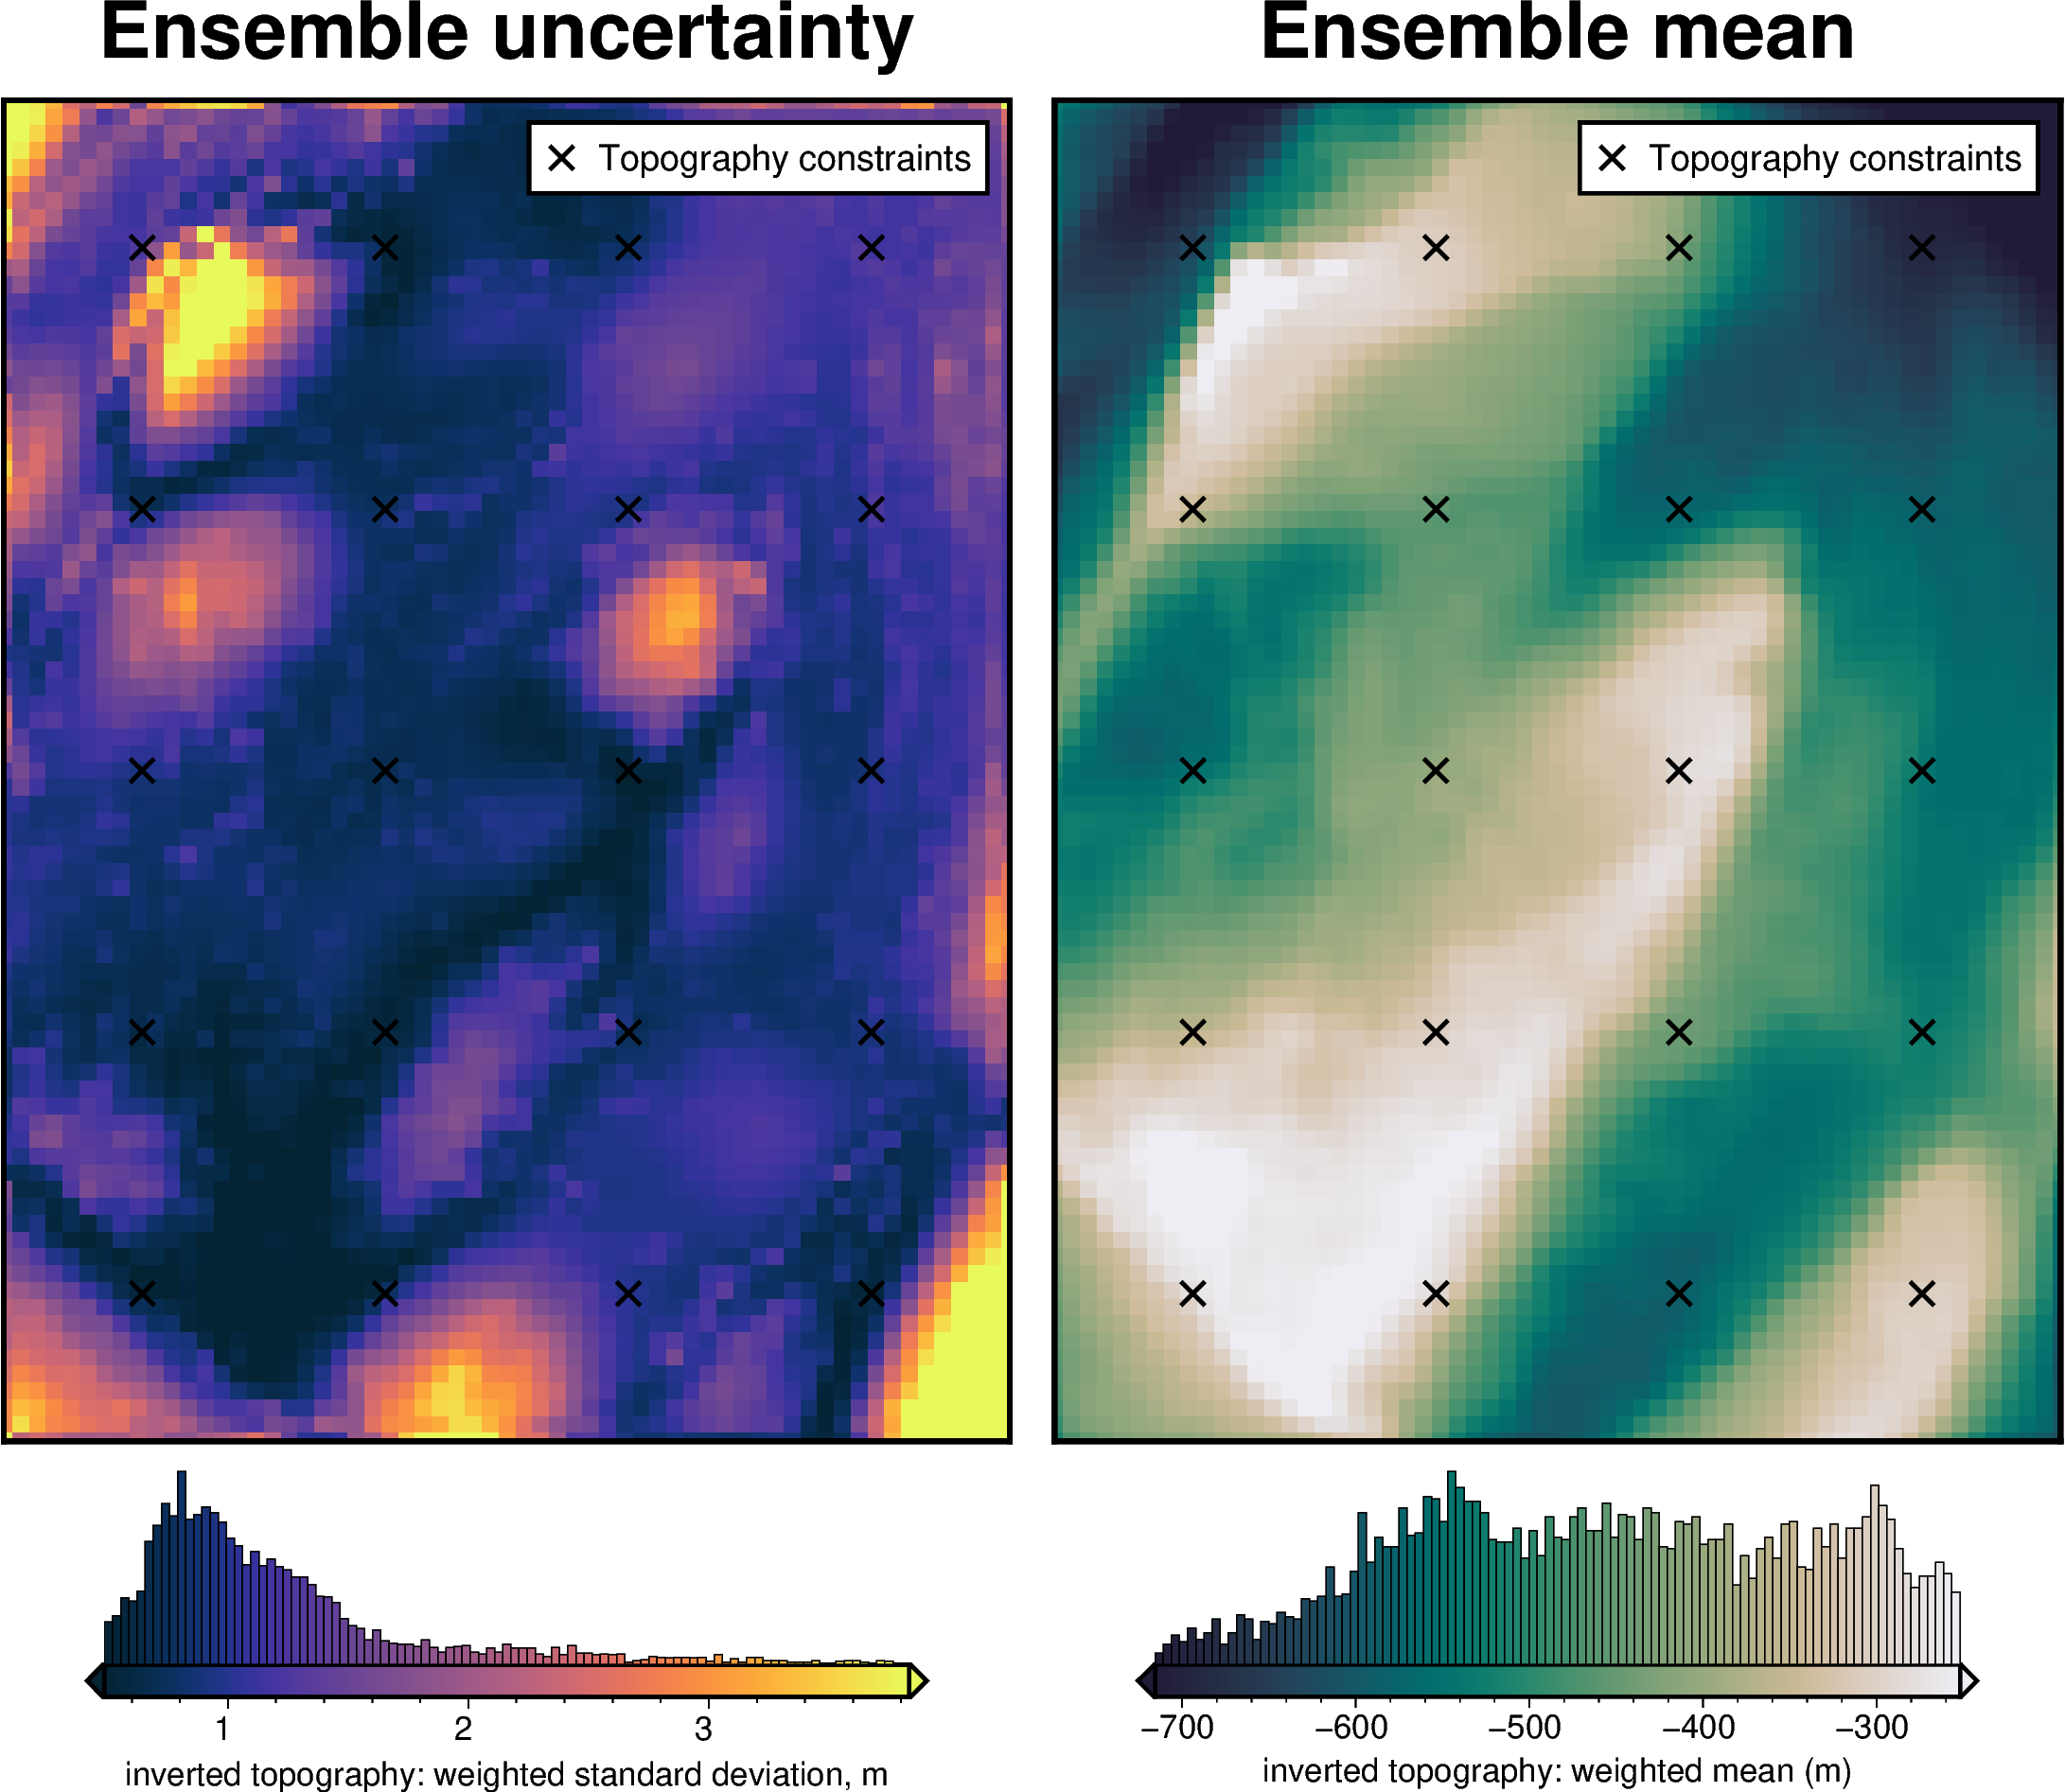

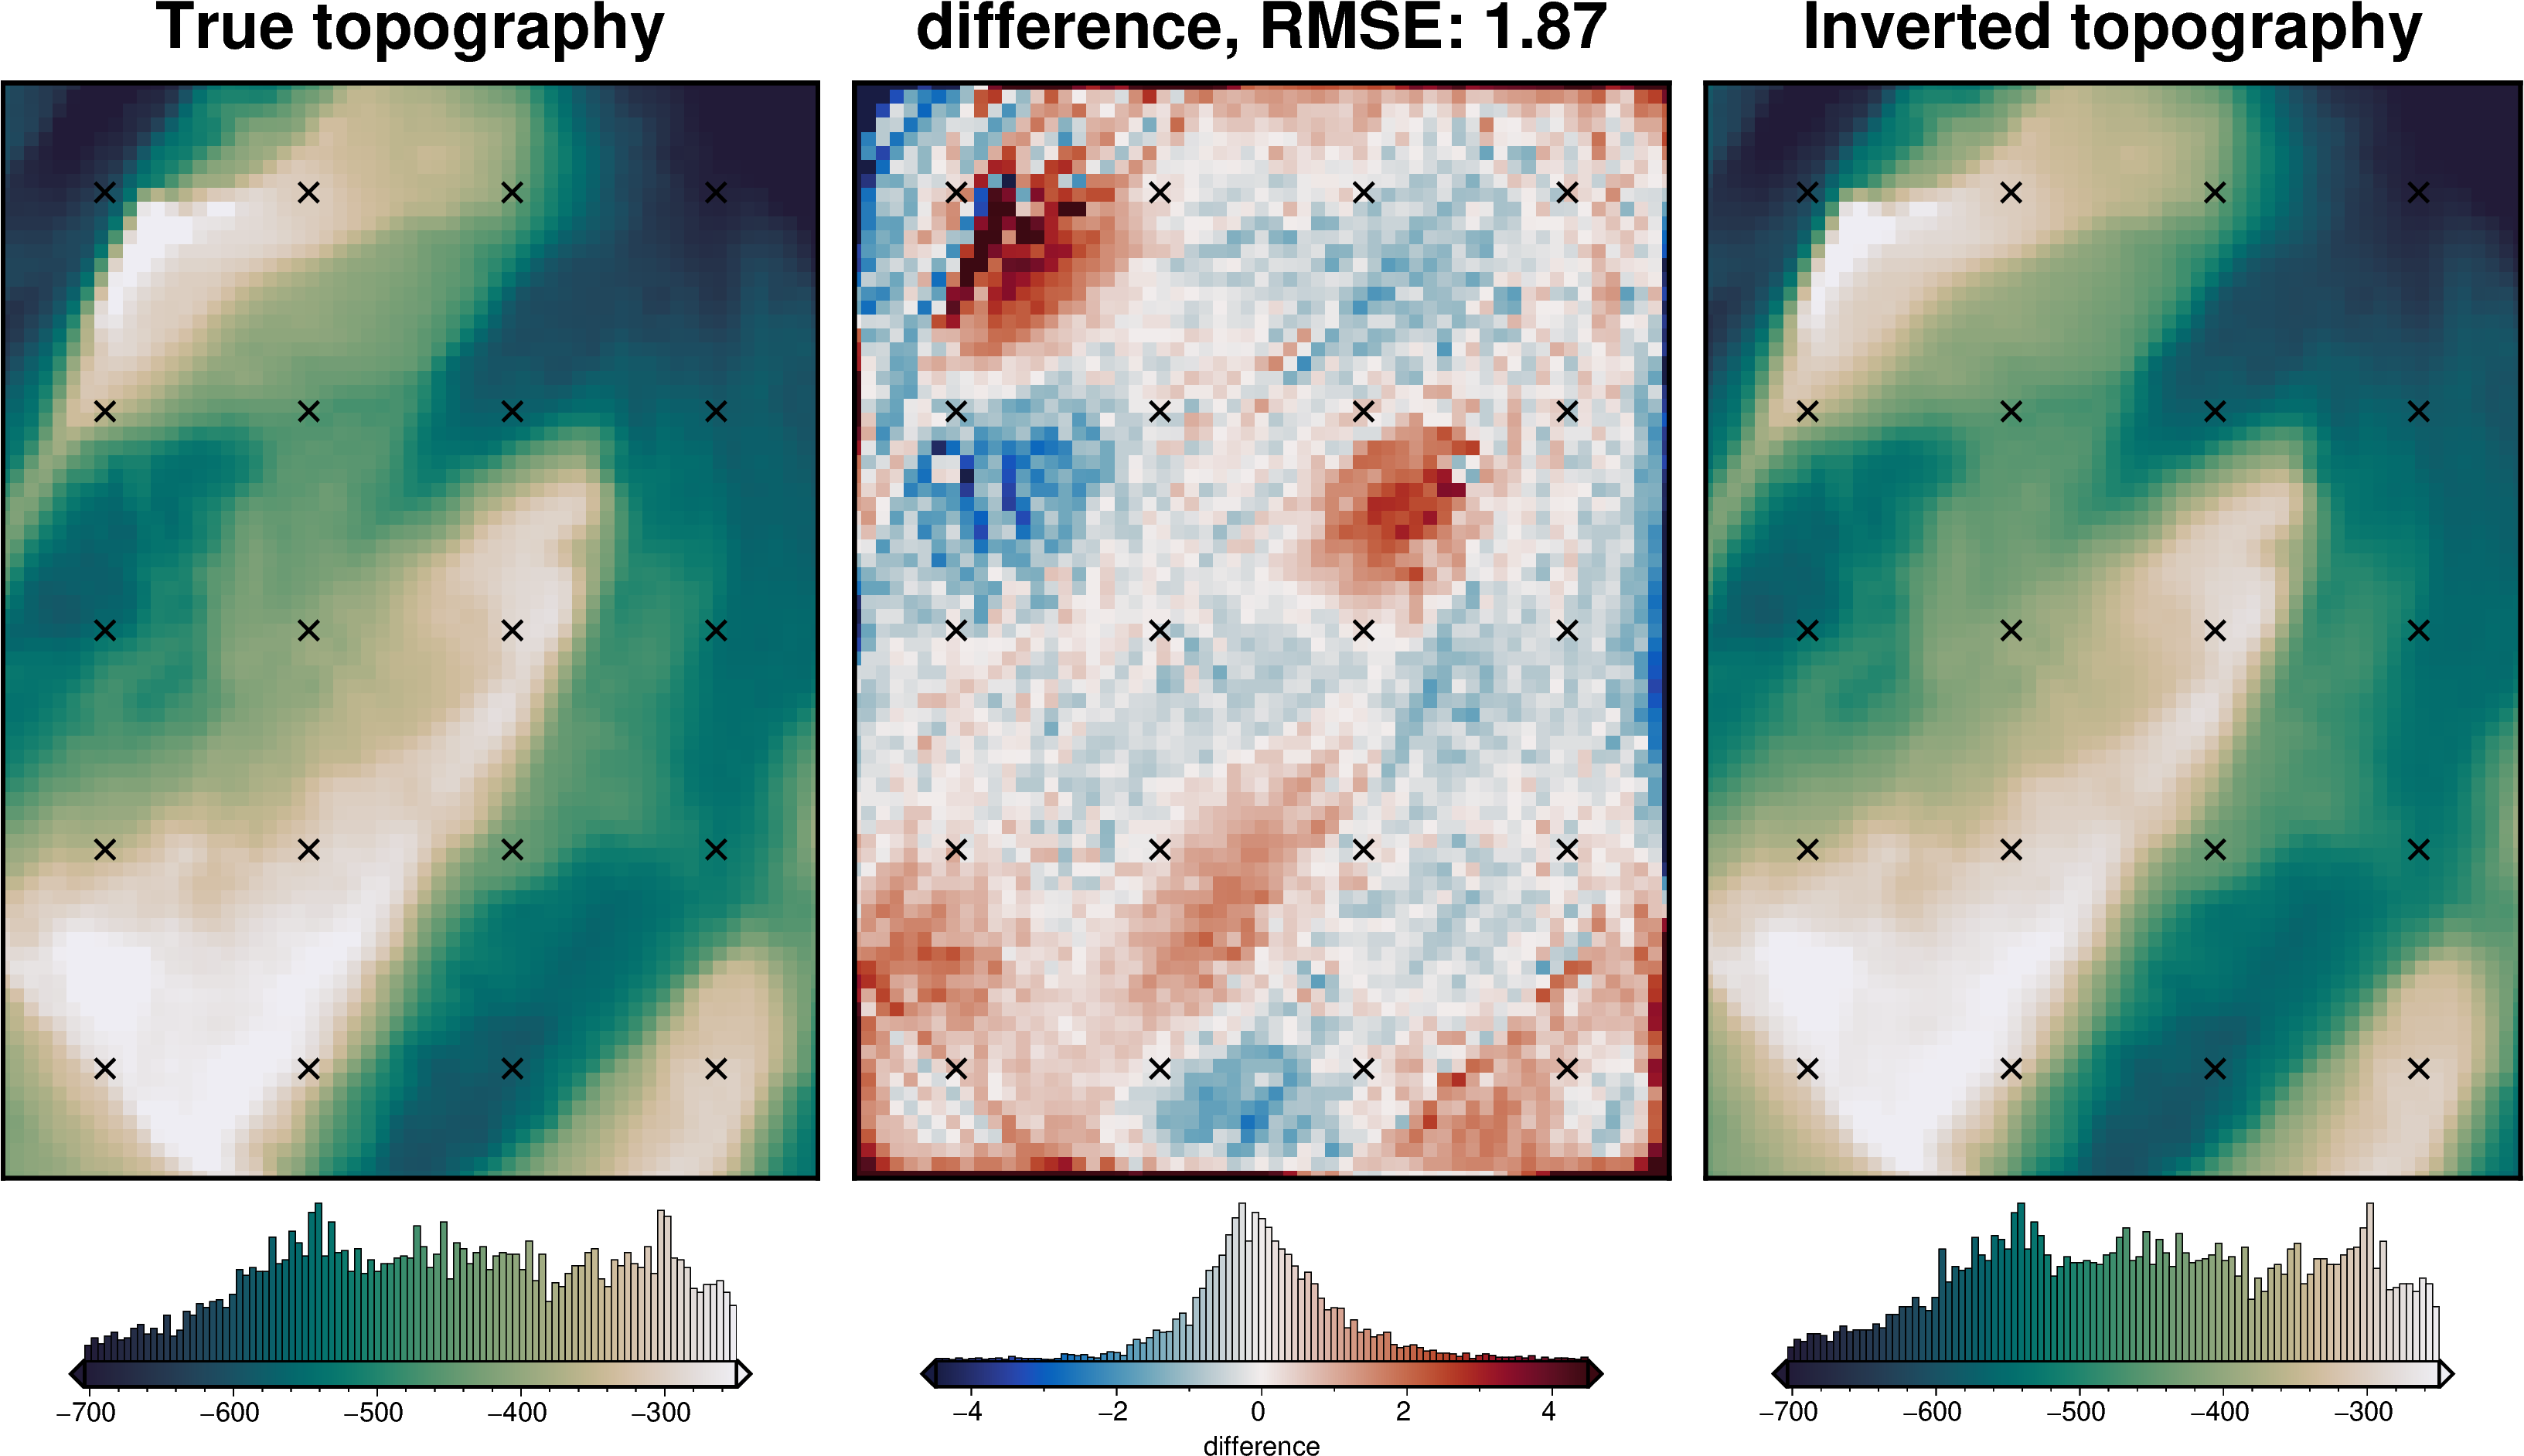

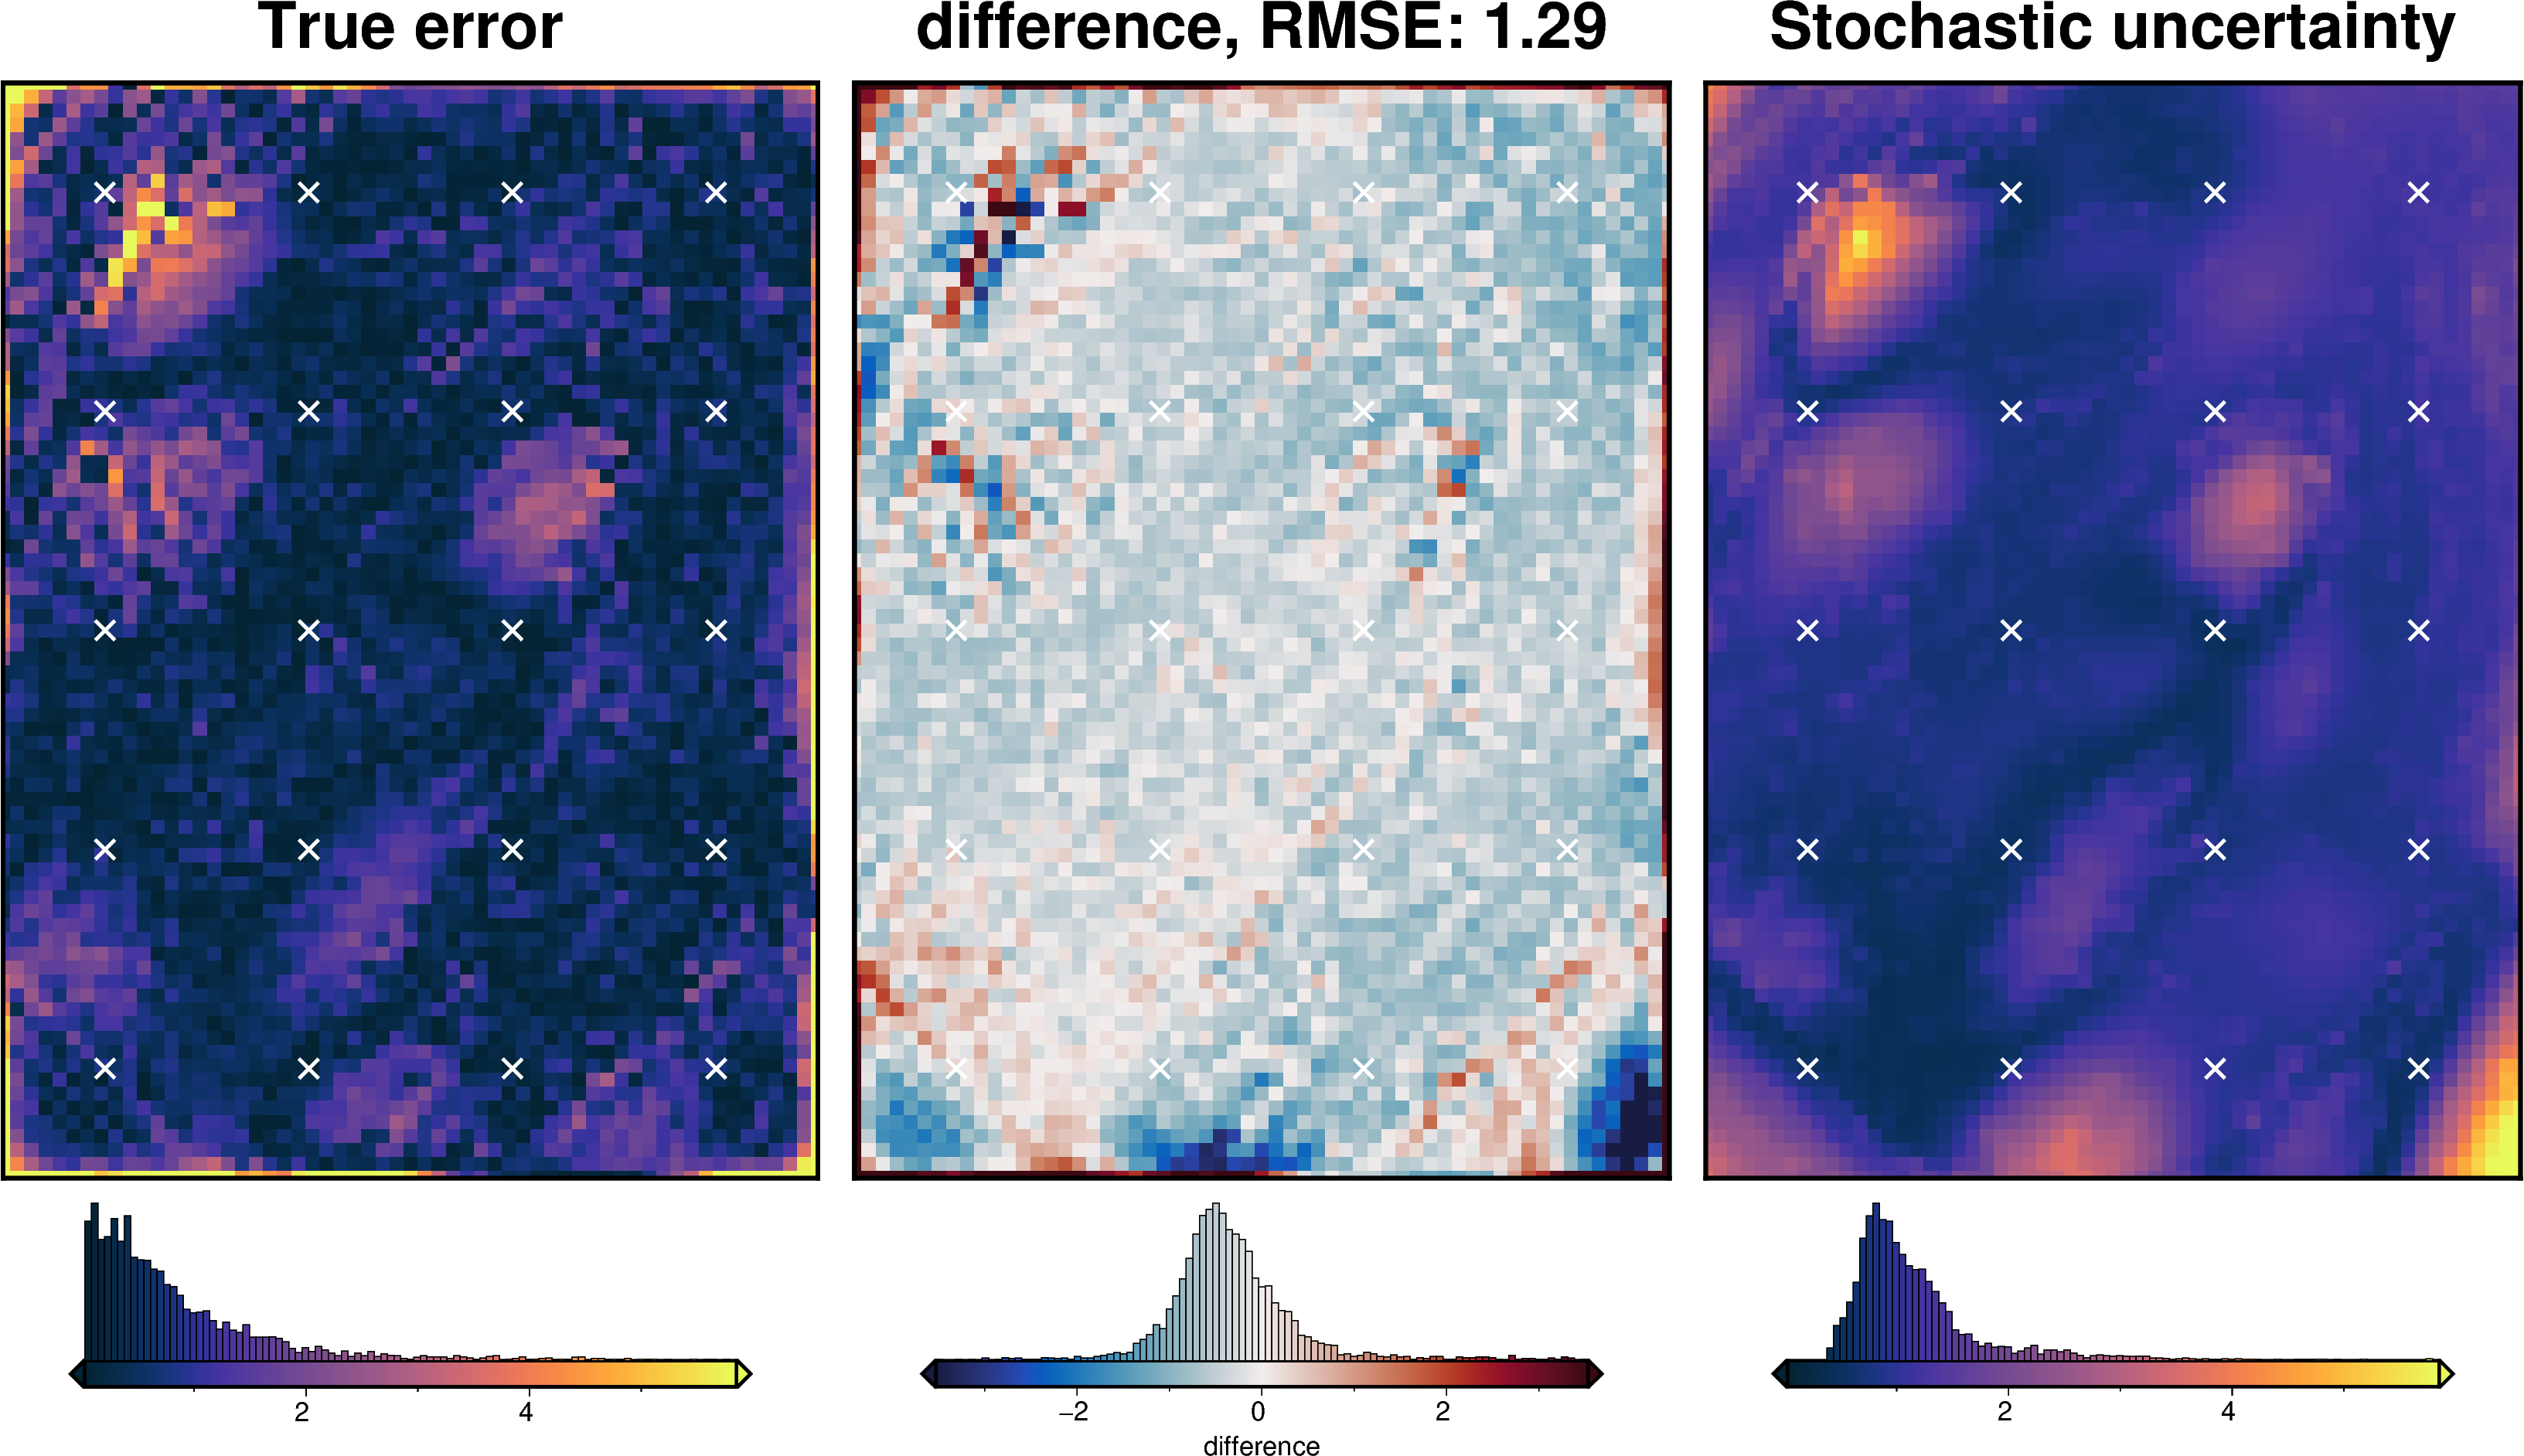

In [39]:
fname = "../../results/Ross_Sea_02_uncertainty_full"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    parameter_dict=solver_dict | density_dict,
    **uncert_kwargs,
)

stats_ds = RIS_plotting.uncert_plots(
    uncert_results,
    inversion_region,
    spacing,
    bathymetry,
    constraint_points=constraint_points,
    weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
)

### Comparing results

In [40]:
results = [
    uncert_results,
    uncert_density_results,
    uncert_damping_results,
]

# get cell-wise stats for each ensemble
stats = []
for r in results:
    ds = uncertainty.merged_stats(
        results=r,
        plot=False,
        constraints_df=constraint_points,
        weight_by="constraints",
        region=vd.pad_region(inversion_region, -spacing),
    )
    stats.append(ds)

In [41]:
names = [
    "full",
    "density",
    "damping",
]

# get the standard deviation of the ensemble of ensembles
stdevs = []
for i, s in enumerate(stats):
    stdevs.append(s.weighted_stdev.rename(f"{names[i]}_stdev"))

merged = xr.merge(stdevs)
merged

<xarray.Dataset> Size: 113kB
Dimensions:        (northing: 79, easting: 59)
Coordinates:
  * northing       (northing) float64 632B -1.795e+06 -1.79e+06 ... -1.405e+06
  * easting        (easting) float64 472B -3.5e+04 -3e+04 ... 2.5e+05 2.55e+05
Data variables:
    full_stdev     (northing, easting) float64 37kB 3.619 3.165 ... 1.531 1.615
    density_stdev  (northing, easting) float64 37kB 0.862 0.8006 ... 1.443 1.537
    damping_stdev  (northing, easting) float64 37kB 3.397 2.744 ... 0.9763 1.069

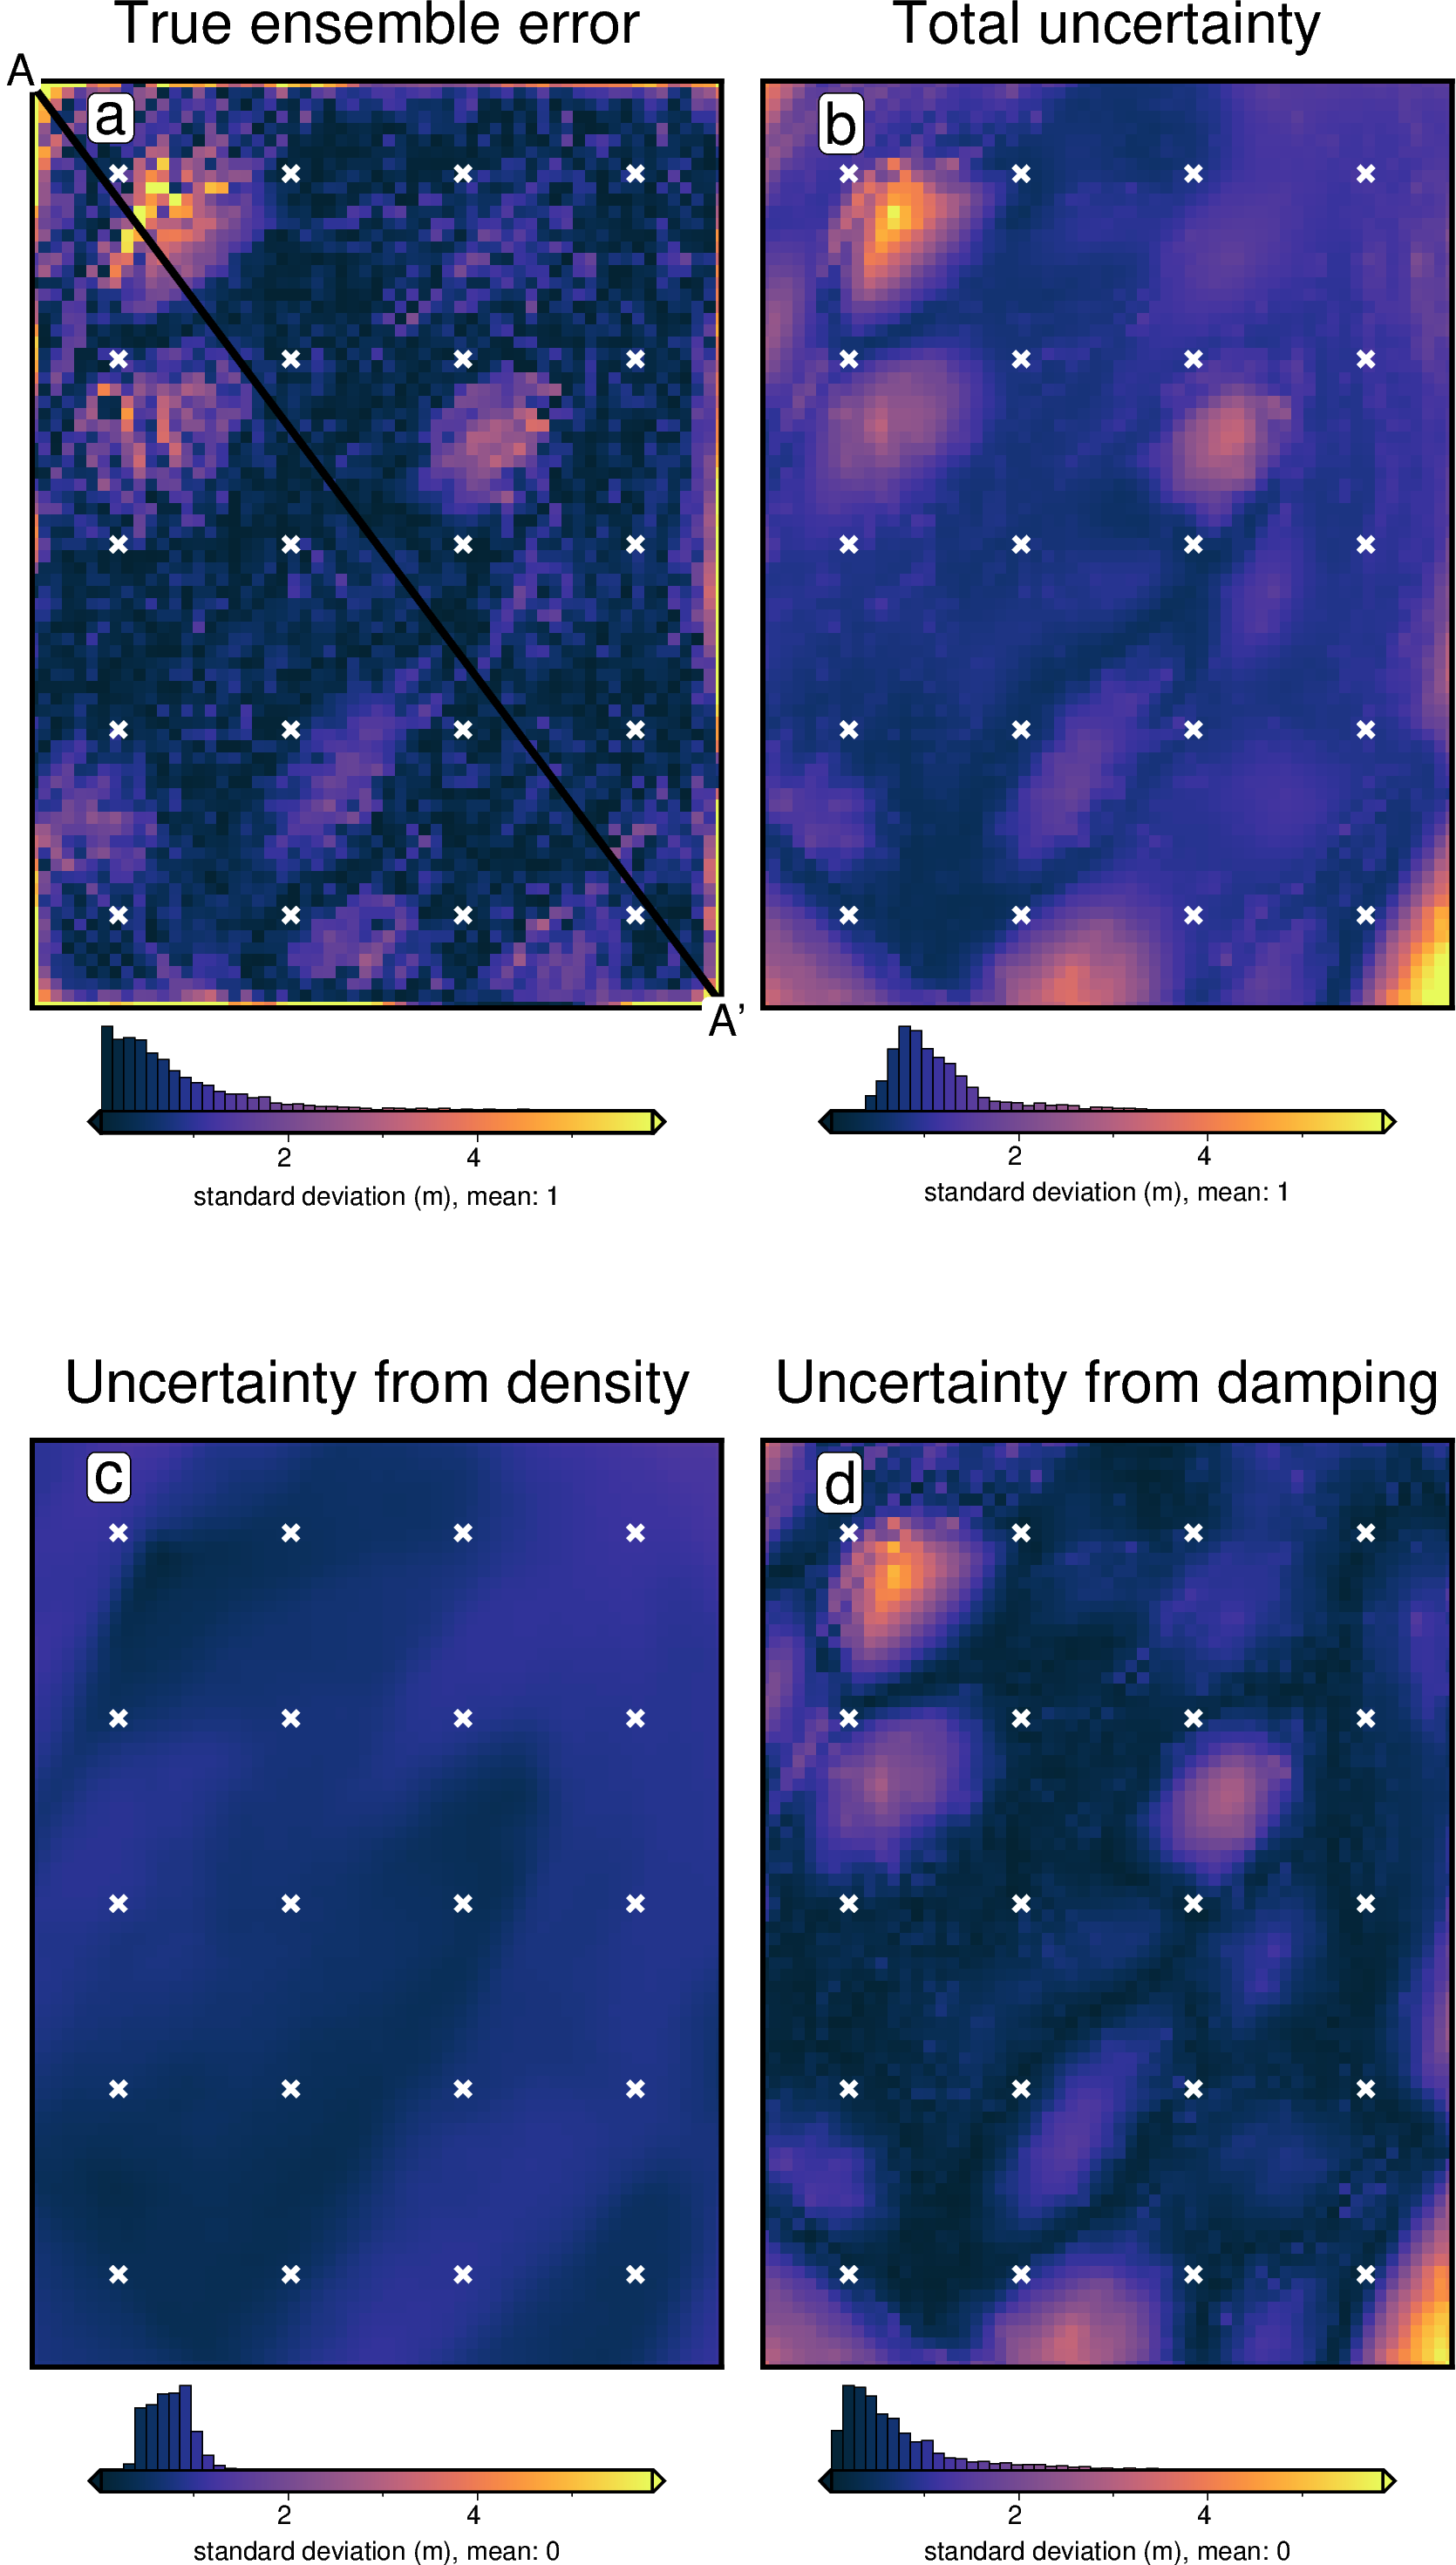

In [42]:
titles = [
    "True ensemble error",
    # "True indiv error",
    "Total uncertainty",
    "Uncertainty from density",
    "Uncertainty from damping",
]
grids = list(merged.data_vars.values())

grids.insert(0, np.abs(stats[0].weighted_mean - bathymetry))

# cpt_lims = polar_utils.get_min_max(grids[0], robust=True,)
cpt_lims = polar_utils.get_combined_min_max(grids, robust=True)

fig_height = 9
for i, g in enumerate(grids):
    xshift_amount = 1
    if i == 0:
        fig = None
        origin_shift = "initialize"
    elif i == 2:
        origin_shift = "both_shift"
        xshift_amount = -1
    else:
        origin_shift = "xshift"

    fig = maps.plot_grd(
        grid=g,
        fig_height=fig_height,
        # region=vd.pad_region(inversion_region, -3*spacing),
        title=titles[i],
        title_font="16p,Helvetica,black",
        cmap="thermal",
        cpt_lims = cpt_lims,
        robust=True,
        cbar_label=f"standard deviation (m), mean: {int(np.nanmean(g))}",
        hist=True,
        hist_bin_num=50,
        cbar_yoffset=1,
        fig=fig,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=-1.1,
    )
    fig.plot(
        x=constraint_points.easting,
        y=constraint_points.northing,
        style="x.2c",
        fill="white",
        pen="1.5p,white",
    )
    fig.text(
        position="TL",
        text=f"{string.ascii_lowercase[i]}",
        fill="white",
        pen=True,
        font="16p,Helvetica,black",
        offset="j.6/.2",
        clearance="+tO",
        no_clip=True,
    )
    if i == 0:
        # plot profiles location, and endpoints on map
        start = [inversion_region[0], inversion_region[3]]
        stop = [inversion_region[1], inversion_region[2]]
        fig.plot(
            vd.line_coordinates(start, stop, size=100),
            pen="2p,black",
        )
        fig.text(
            x=start[0],
            y=start[1],
            text="A",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
        fig.text(
            x=stop[0],
            y=stop[1],
            text="A' ",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
fig.show()

grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


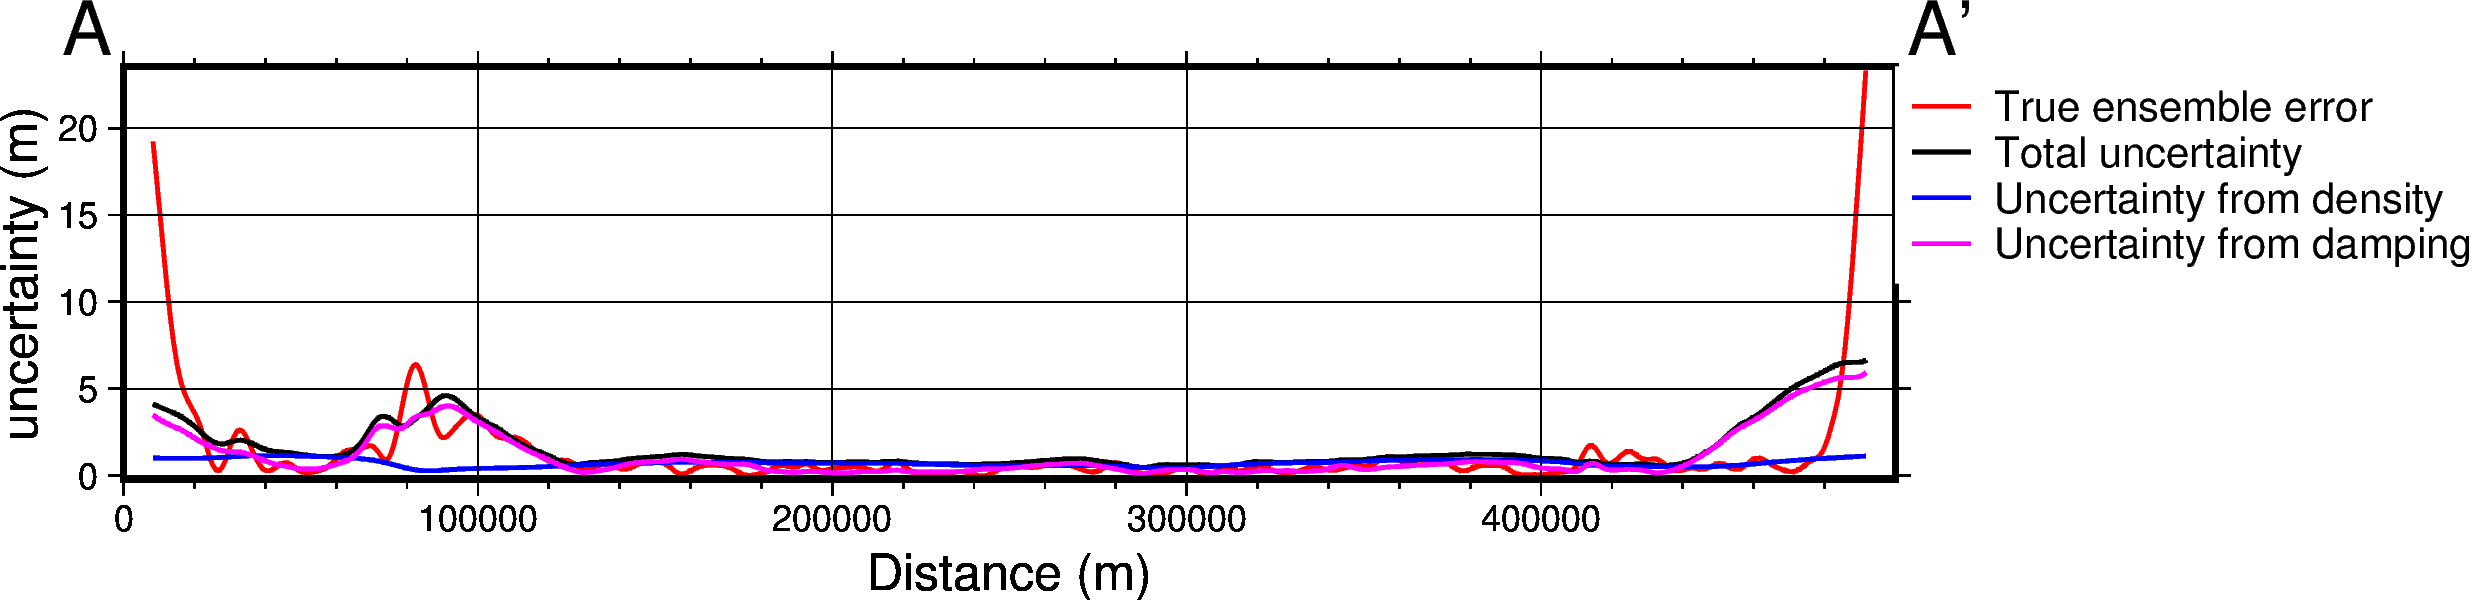

In [43]:
data_dict = profiles.make_data_dict(
    names=titles,
    grids=grids,
    colors=[
        "red",
        "black",
        "blue",
        "magenta",
        "cyan",
        "green",
        "purple",
    ],
)

fig, df_data = profiles.plot_data(
    "points",
    start=[inversion_region[0], inversion_region[3]],
    stop=[inversion_region[1], inversion_region[2]],
    num=10000,
    fig_height=4,
    fig_width=15,
    data_dict=data_dict,
    data_legend_loc="jTR+jTL",
    data_legend_box="+gwhite",
    data_buffer=0.01,
    data_frame=["neSW", "xafg+lDistance (m)", "yag+luncertainty (m)"],
    # data_pen_style=[None,None,"4_2:2p"],
    # data_pen_thickness=[1, 1.5, 1],
    share_yaxis=True,
    start_label="A",
    end_label="A' ",
)
fig.show()

INFO:root:grid regions dont match, using inner region (-35000.0, 255000.0, -1795000.0, -1405000.0)
INFO:root:returning original grid


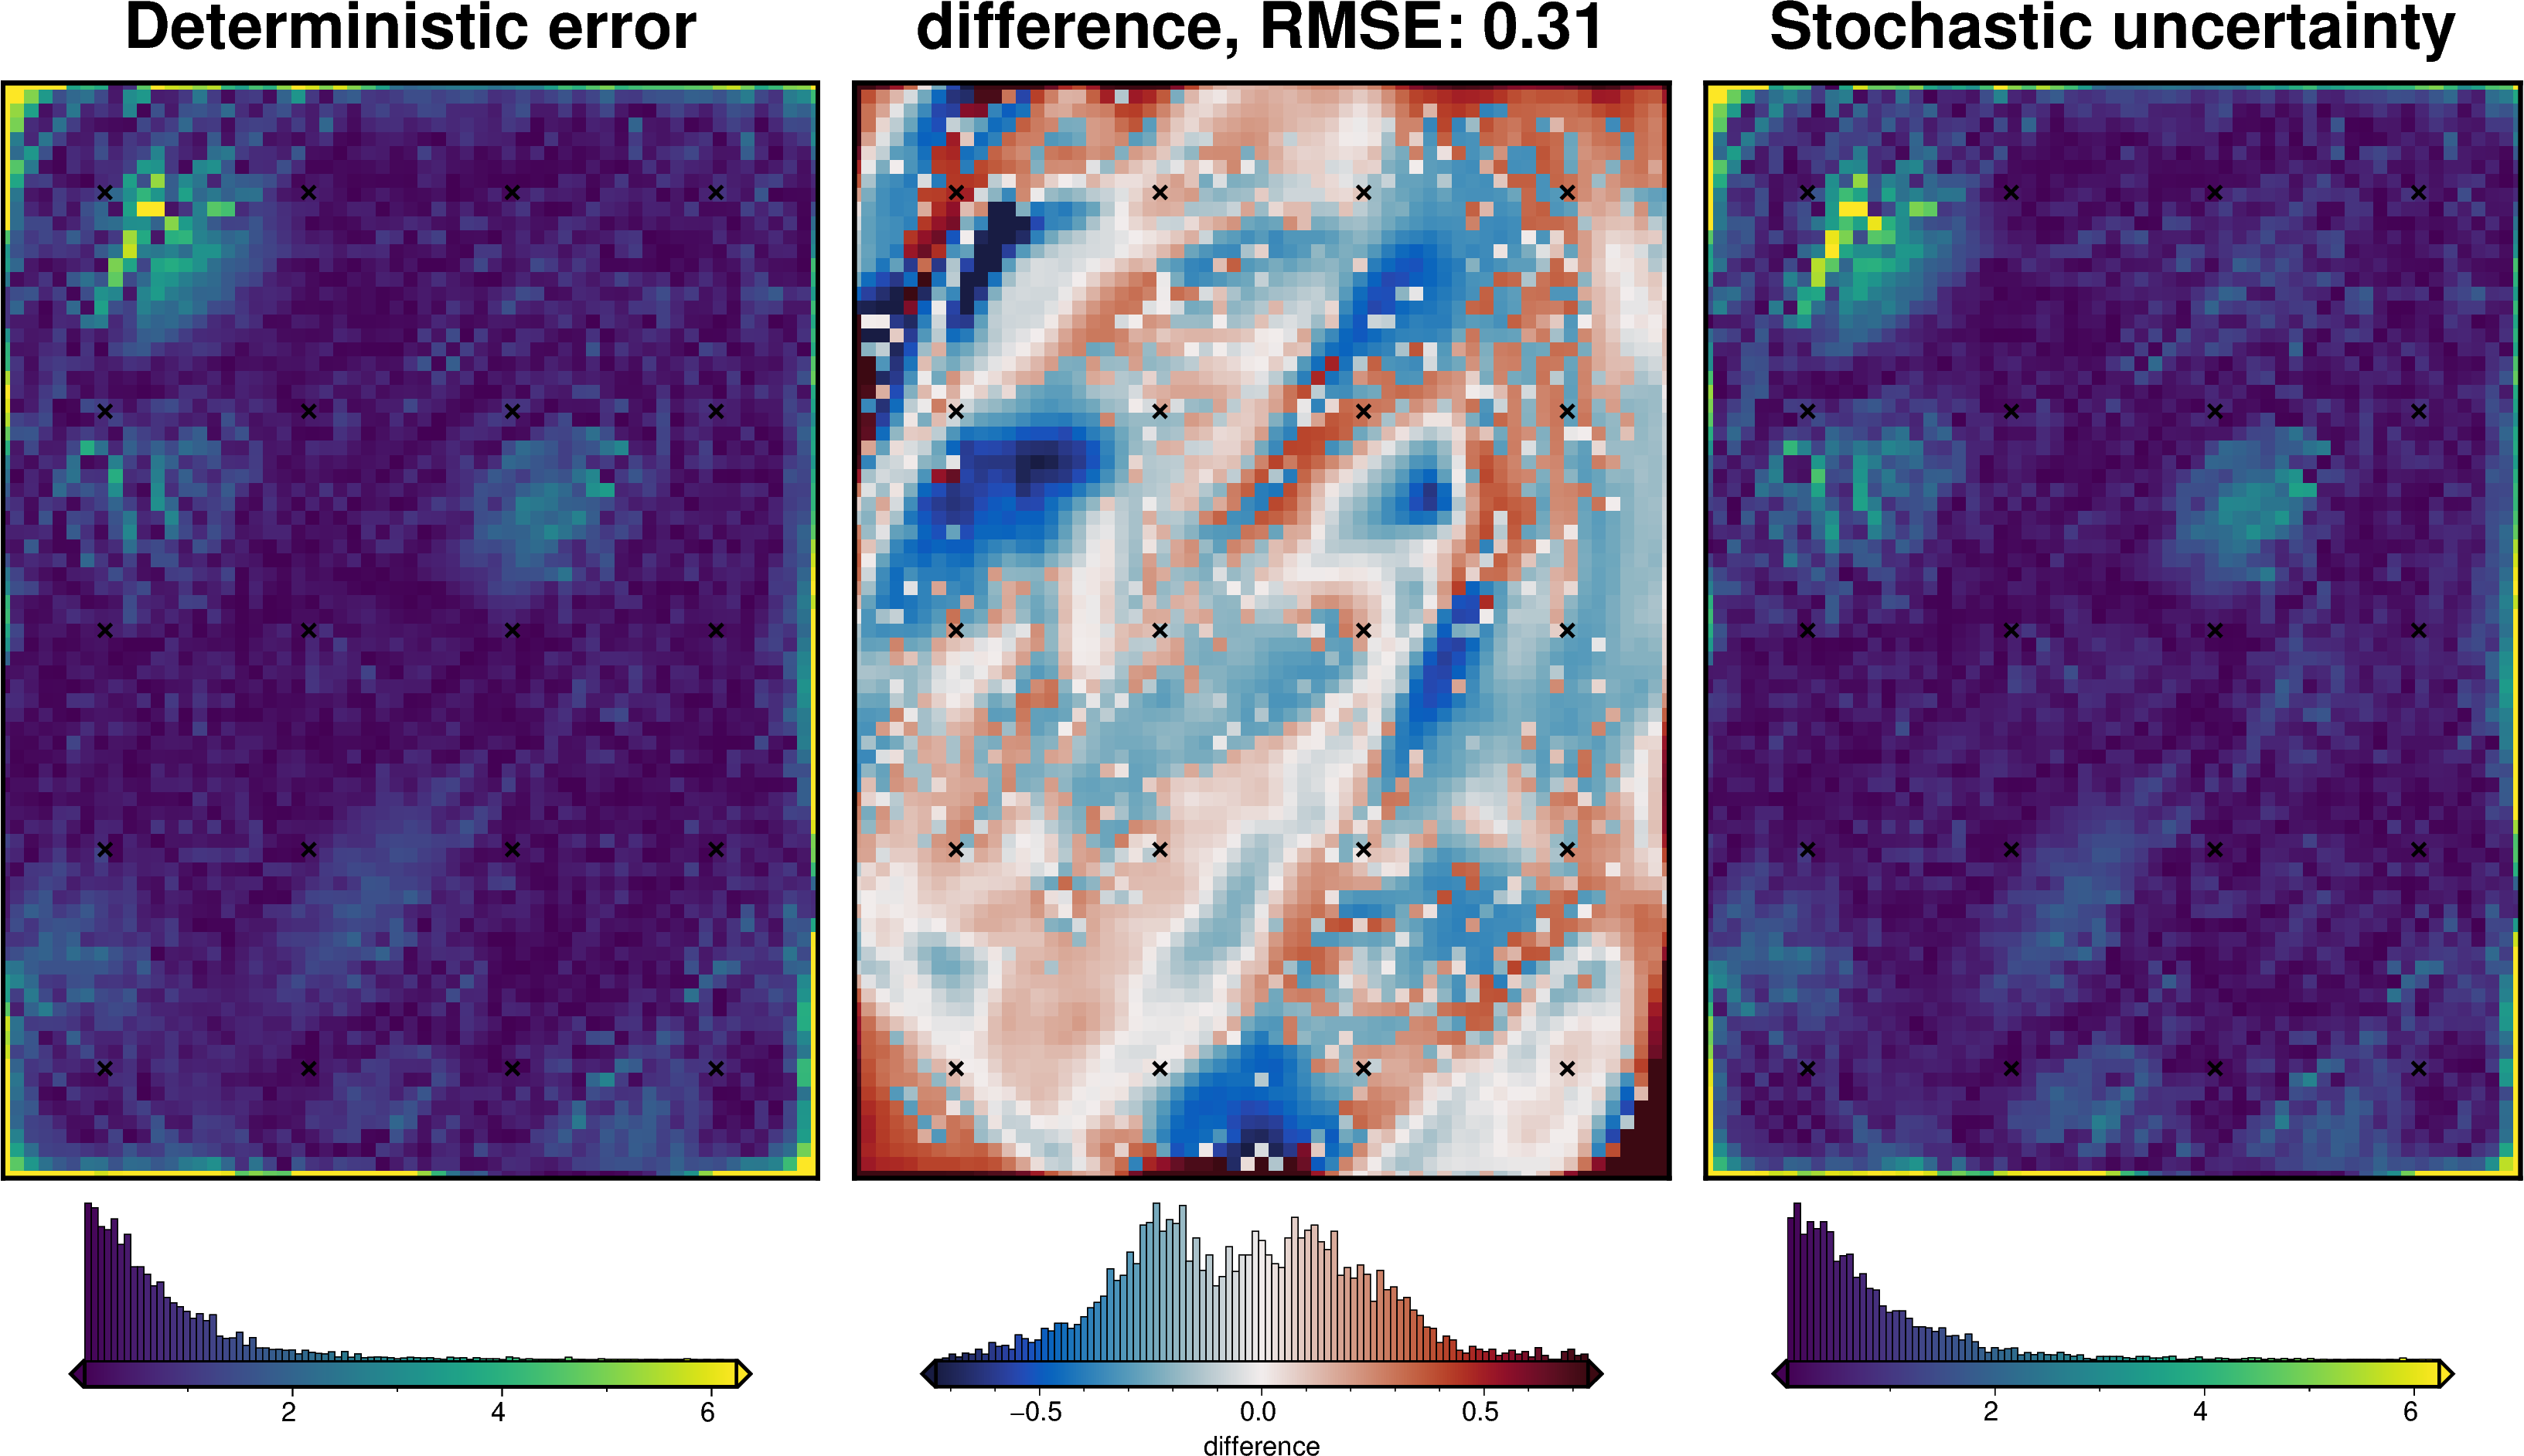

In [44]:
_ = polar_utils.grd_compare(
    inversion_error,
    np.abs(stats[0].weighted_mean - bathymetry),
    region=inversion_region,
    plot=True,
    grid1_name="Deterministic error",
    grid2_name="Stochastic uncertainty",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
)

In [45]:
# save results
merged.to_netcdf("../../results/Ross_Sea_02_sensitivity.nc")

In [46]:
stats_ds.to_netcdf("../../results/Ross_Sea_02_uncertainty.nc")